## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (1476, 256)
Hypercube shape: (1476, 256, 145)


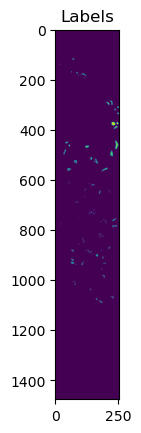

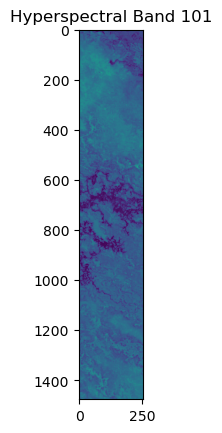

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'Botswana_gt.mat'
data_files = 'Botswana.mat'
label_files = 'Botswana_gt'
hypercube_files = 'Botswana'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 3248
Extracted windows shape: (3248, 5, 5, 145)
Corresponding labels shape: (3248,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 5)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 270 samples
Shuffled class indices for class '1'
Selected 5 training samples and 5 validation samples for class '1'

Class: 2: Found 101 samples
Shuffled class indices for class '2'
Selected 5 training samples and 5 validation samples for class '2'

Class: 3: Found 251 samples
Shuffled class indices for class '3'
Selected 5 training samples and 5 validation samples for class '3'

Class: 4: Found 215 samples
Shuffled class indices for class '4'
Selected 5 training samples and 5 validation samples for class '4'

Class: 5: Found 269 samples
Shuffled class indices for class '5'
Selected 5 training samples and 5 validation samples for class '5'

Class: 6: Found 269 samples
Shuffled class indices for class '6'
Selected 5 training samples and 5 validation samples for class '6'

Class: 7: Found 259 samples
Shuffled class indices for class '7'
Selecte


All datasets saved to the 'indices' folder.
(70, 5, 5, 145)
(70, 5, 5, 145)
(3108, 5, 5, 145)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 1 applied
DataLoaders created successfully!
Training batch size: 70
Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (2598, 5, 5, 145)
Validation data shape: (650, 5, 5, 145)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

145


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/41], Loss: 0.2217, PSNR: -10.9462


Epoch [1/50] Training Loss: 0.2132, PSNR: -8.8000
	[Val]   Batch [1/11] Loss: 0.2050, PSNR: -6.1546
	[Val]   Batch [10/11] Loss: 0.2051, PSNR: -8.3935
Epoch [1/50] Validation Loss: 0.2050, PSNR: -8.0855

LOG: Epoch [2/50]
	 Training Batch [1/41], Loss: 0.1973, PSNR: -7.9231


Epoch [2/50] Training Loss: 0.1913, PSNR: -8.4635
	[Val]   Batch [1/11] Loss: 0.1808, PSNR: -5.6099
	[Val]   Batch [10/11] Loss: 0.1811, PSNR: -7.8533
Epoch [2/50] Validation Loss: 0.1809, PSNR: -7.5419

LOG: Epoch [3/50]
	 Training Batch [1/41], Loss: 0.1764, PSNR: -5.5030


Epoch [3/50] Training Loss: 0.1705, PSNR: -8.0593
	[Val]   Batch [1/11] Loss: 0.1558, PSNR: -4.9629
	[Val]   Batch [10/11] Loss: 0.1563, PSNR: -7.2126
Epoch [3/50] Validation Loss: 0.1560, PSNR: -6.8986

LOG: Epoch [4/50]
	 Training Batch [1/41], Loss: 0.1565, PSNR: -6.5661


Epoch [4/50] Training Loss: 0.1503, PSNR: -7.2243
	[Val]   Batch [1/11] Loss: 0.1349, PSNR: -4.3364
	[Val]   Batch [10/11] Loss: 0.1352, PSNR: -6.5837
Epoch [4/50] Validation Loss: 0.1350, PSNR: -6.2701

LOG: Epoch [5/50]
	 Training Batch [1/41], Loss: 0.1377, PSNR: -6.3628


Epoch [5/50] Training Loss: 0.1311, PSNR: -6.7868
	[Val]   Batch [1/11] Loss: 0.1159, PSNR: -3.6786
	[Val]   Batch [10/11] Loss: 0.1161, PSNR: -5.9212
Epoch [5/50] Validation Loss: 0.1159, PSNR: -5.6088

LOG: Epoch [6/50]
	 Training Batch [1/41], Loss: 0.1182, PSNR: -5.6989


Epoch [6/50] Training Loss: 0.1134, PSNR: -6.1559
	[Val]   Batch [1/11] Loss: 0.1003, PSNR: -3.0504
	[Val]   Batch [10/11] Loss: 0.1005, PSNR: -5.2930
Epoch [6/50] Validation Loss: 0.1003, PSNR: -4.9811

LOG: Epoch [7/50]
	 Training Batch [1/41], Loss: 0.1030, PSNR: -7.6500


Epoch [7/50] Training Loss: 0.0977, PSNR: -5.2825
	[Val]   Batch [1/11] Loss: 0.0855, PSNR: -2.3574
	[Val]   Batch [10/11] Loss: 0.0857, PSNR: -4.6004
Epoch [7/50] Validation Loss: 0.0855, PSNR: -4.2878

LOG: Epoch [8/50]
	 Training Batch [1/41], Loss: 0.0887, PSNR: -2.5161


Epoch [8/50] Training Loss: 0.0841, PSNR: -4.8965
	[Val]   Batch [1/11] Loss: 0.0748, PSNR: -1.7743
	[Val]   Batch [10/11] Loss: 0.0749, PSNR: -4.0179
Epoch [8/50] Validation Loss: 0.0748, PSNR: -3.7057

LOG: Epoch [9/50]
	 Training Batch [1/41], Loss: 0.0765, PSNR: -3.1873


Epoch [9/50] Training Loss: 0.0724, PSNR: -4.0044
	[Val]   Batch [1/11] Loss: 0.0644, PSNR: -1.1264
	[Val]   Batch [10/11] Loss: 0.0645, PSNR: -3.3713
Epoch [9/50] Validation Loss: 0.0644, PSNR: -3.0580

LOG: Epoch [10/50]
	 Training Batch [1/41], Loss: 0.0661, PSNR: -4.9628


Epoch [10/50] Training Loss: 0.0628, PSNR: -3.4883
	[Val]   Batch [1/11] Loss: 0.0574, PSNR: -0.6298
	[Val]   Batch [10/11] Loss: 0.0576, PSNR: -2.8734
Epoch [10/50] Validation Loss: 0.0574, PSNR: -2.5607

LOG: Epoch [11/50]
	 Training Batch [1/41], Loss: 0.0574, PSNR: -2.5599


Epoch [11/50] Training Loss: 0.0547, PSNR: -2.7875
	[Val]   Batch [1/11] Loss: 0.0500, PSNR: -0.0263
	[Val]   Batch [10/11] Loss: 0.0501, PSNR: -2.2693
Epoch [11/50] Validation Loss: 0.0500, PSNR: -1.9565

LOG: Epoch [12/50]
	 Training Batch [1/41], Loss: 0.0495, PSNR: -1.9184


Epoch [12/50] Training Loss: 0.0480, PSNR: -2.2823
	[Val]   Batch [1/11] Loss: 0.0446, PSNR: 0.4712
	[Val]   Batch [10/11] Loss: 0.0446, PSNR: -1.7706
Epoch [12/50] Validation Loss: 0.0446, PSNR: -1.4589

LOG: Epoch [13/50]
	 Training Batch [1/41], Loss: 0.0444, PSNR: -2.3147


Epoch [13/50] Training Loss: 0.0424, PSNR: -1.7700
	[Val]   Batch [1/11] Loss: 0.0397, PSNR: 0.9757
	[Val]   Batch [10/11] Loss: 0.0398, PSNR: -1.2664
Epoch [13/50] Validation Loss: 0.0397, PSNR: -0.9547

LOG: Epoch [14/50]
	 Training Batch [1/41], Loss: 0.0390, PSNR: -0.8772


Epoch [14/50] Training Loss: 0.0378, PSNR: -1.3481
	[Val]   Batch [1/11] Loss: 0.0359, PSNR: 1.4166
	[Val]   Batch [10/11] Loss: 0.0359, PSNR: -0.8251
Epoch [14/50] Validation Loss: 0.0359, PSNR: -0.5138

LOG: Epoch [15/50]
	 Training Batch [1/41], Loss: 0.0342, PSNR: 0.3014


Epoch [15/50] Training Loss: 0.0338, PSNR: -0.8526
	[Val]   Batch [1/11] Loss: 0.0320, PSNR: 1.9115
	[Val]   Batch [10/11] Loss: 0.0320, PSNR: -0.3299
Epoch [15/50] Validation Loss: 0.0320, PSNR: -0.0186

LOG: Epoch [16/50]
	 Training Batch [1/41], Loss: 0.0317, PSNR: -1.4657


Epoch [16/50] Training Loss: 0.0305, PSNR: -0.5067
	[Val]   Batch [1/11] Loss: 0.0292, PSNR: 2.3148
	[Val]   Batch [10/11] Loss: 0.0292, PSNR: 0.0726
Epoch [16/50] Validation Loss: 0.0292, PSNR: 0.3853

LOG: Epoch [17/50]
	 Training Batch [1/41], Loss: 0.0289, PSNR: 1.0435


Epoch [17/50] Training Loss: 0.0276, PSNR: -0.0459
	[Val]   Batch [1/11] Loss: 0.0267, PSNR: 2.7034
	[Val]   Batch [10/11] Loss: 0.0267, PSNR: 0.4607
Epoch [17/50] Validation Loss: 0.0267, PSNR: 0.7745

LOG: Epoch [18/50]
	 Training Batch [1/41], Loss: 0.0268, PSNR: -1.5396


Epoch [18/50] Training Loss: 0.0251, PSNR: 0.5752
	[Val]   Batch [1/11] Loss: 0.0240, PSNR: 3.1631
	[Val]   Batch [10/11] Loss: 0.0240, PSNR: 0.9199
Epoch [18/50] Validation Loss: 0.0240, PSNR: 1.2341

LOG: Epoch [19/50]
	 Training Batch [1/41], Loss: 0.0236, PSNR: 0.8075


Epoch [19/50] Training Loss: 0.0230, PSNR: 0.8384
	[Val]   Batch [1/11] Loss: 0.0222, PSNR: 3.4914
	[Val]   Batch [10/11] Loss: 0.0223, PSNR: 1.2506
Epoch [19/50] Validation Loss: 0.0222, PSNR: 1.5626

LOG: Epoch [20/50]
	 Training Batch [1/41], Loss: 0.0216, PSNR: -0.6053


Epoch [20/50] Training Loss: 0.0211, PSNR: 1.3656
	[Val]   Batch [1/11] Loss: 0.0204, PSNR: 3.8669
	[Val]   Batch [10/11] Loss: 0.0204, PSNR: 1.6274
Epoch [20/50] Validation Loss: 0.0204, PSNR: 1.9390

LOG: Epoch [21/50]
	 Training Batch [1/41], Loss: 0.0201, PSNR: 1.7018


Epoch [21/50] Training Loss: 0.0194, PSNR: 1.5529
	[Val]   Batch [1/11] Loss: 0.0188, PSNR: 4.2329
	[Val]   Batch [10/11] Loss: 0.0188, PSNR: 1.9937
Epoch [21/50] Validation Loss: 0.0187, PSNR: 2.3056

LOG: Epoch [22/50]
	 Training Batch [1/41], Loss: 0.0185, PSNR: 0.8624


Epoch [22/50] Training Loss: 0.0179, PSNR: 1.9857
	[Val]   Batch [1/11] Loss: 0.0176, PSNR: 4.4980
	[Val]   Batch [10/11] Loss: 0.0176, PSNR: 2.2600
Epoch [22/50] Validation Loss: 0.0176, PSNR: 2.5714

LOG: Epoch [23/50]
	 Training Batch [1/41], Loss: 0.0169, PSNR: 1.8818


Epoch [23/50] Training Loss: 0.0166, PSNR: 2.2060
	[Val]   Batch [1/11] Loss: 0.0162, PSNR: 4.8635
	[Val]   Batch [10/11] Loss: 0.0162, PSNR: 2.6250
Epoch [23/50] Validation Loss: 0.0162, PSNR: 2.9372

LOG: Epoch [24/50]
	 Training Batch [1/41], Loss: 0.0159, PSNR: 4.9458


Epoch [24/50] Training Loss: 0.0154, PSNR: 2.4991
	[Val]   Batch [1/11] Loss: 0.0151, PSNR: 5.1823
	[Val]   Batch [10/11] Loss: 0.0151, PSNR: 2.9428
Epoch [24/50] Validation Loss: 0.0151, PSNR: 3.2555

LOG: Epoch [25/50]
	 Training Batch [1/41], Loss: 0.0144, PSNR: 4.0644


Epoch [25/50] Training Loss: 0.0144, PSNR: 2.9040
	[Val]   Batch [1/11] Loss: 0.0141, PSNR: 5.4847
	[Val]   Batch [10/11] Loss: 0.0141, PSNR: 3.2441
Epoch [25/50] Validation Loss: 0.0140, PSNR: 3.5577

LOG: Epoch [26/50]
	 Training Batch [1/41], Loss: 0.0136, PSNR: 2.7604


Epoch [26/50] Training Loss: 0.0134, PSNR: 3.3680
	[Val]   Batch [1/11] Loss: 0.0133, PSNR: 5.7401
	[Val]   Batch [10/11] Loss: 0.0133, PSNR: 3.4997
Epoch [26/50] Validation Loss: 0.0132, PSNR: 3.8124

LOG: Epoch [27/50]
	 Training Batch [1/41], Loss: 0.0132, PSNR: 5.7555


Epoch [27/50] Training Loss: 0.0125, PSNR: 3.5605
	[Val]   Batch [1/11] Loss: 0.0122, PSNR: 6.0880
	[Val]   Batch [10/11] Loss: 0.0122, PSNR: 3.8479
Epoch [27/50] Validation Loss: 0.0122, PSNR: 4.1600

LOG: Epoch [28/50]
	 Training Batch [1/41], Loss: 0.0121, PSNR: 2.7229


Epoch [28/50] Training Loss: 0.0118, PSNR: 3.7267
	[Val]   Batch [1/11] Loss: 0.0116, PSNR: 6.3362
	[Val]   Batch [10/11] Loss: 0.0116, PSNR: 4.0971
Epoch [28/50] Validation Loss: 0.0115, PSNR: 4.4083

LOG: Epoch [29/50]
	 Training Batch [1/41], Loss: 0.0114, PSNR: 6.3775


Epoch [29/50] Training Loss: 0.0110, PSNR: 4.0361
	[Val]   Batch [1/11] Loss: 0.0109, PSNR: 6.5996
	[Val]   Batch [10/11] Loss: 0.0109, PSNR: 4.3610
Epoch [29/50] Validation Loss: 0.0109, PSNR: 4.6718

LOG: Epoch [30/50]
	 Training Batch [1/41], Loss: 0.0103, PSNR: 2.8964


Epoch [30/50] Training Loss: 0.0104, PSNR: 4.3476
	[Val]   Batch [1/11] Loss: 0.0102, PSNR: 6.8625
	[Val]   Batch [10/11] Loss: 0.0102, PSNR: 4.6234
Epoch [30/50] Validation Loss: 0.0102, PSNR: 4.9354

LOG: Epoch [31/50]
	 Training Batch [1/41], Loss: 0.0098, PSNR: 2.7970


Epoch [31/50] Training Loss: 0.0098, PSNR: 4.6684
	[Val]   Batch [1/11] Loss: 0.0097, PSNR: 7.0964
	[Val]   Batch [10/11] Loss: 0.0097, PSNR: 4.8575
Epoch [31/50] Validation Loss: 0.0097, PSNR: 5.1701

LOG: Epoch [32/50]
	 Training Batch [1/41], Loss: 0.0097, PSNR: 5.4782


Epoch [32/50] Training Loss: 0.0092, PSNR: 4.6825
	[Val]   Batch [1/11] Loss: 0.0092, PSNR: 7.3345
	[Val]   Batch [10/11] Loss: 0.0092, PSNR: 5.0971
Epoch [32/50] Validation Loss: 0.0092, PSNR: 5.4089

LOG: Epoch [33/50]
	 Training Batch [1/41], Loss: 0.0087, PSNR: 5.9726


Epoch [33/50] Training Loss: 0.0087, PSNR: 4.8321
	[Val]   Batch [1/11] Loss: 0.0087, PSNR: 7.5841
	[Val]   Batch [10/11] Loss: 0.0087, PSNR: 5.3464
Epoch [33/50] Validation Loss: 0.0087, PSNR: 5.6587

LOG: Epoch [34/50]
	 Training Batch [1/41], Loss: 0.0084, PSNR: 3.4897


Epoch [34/50] Training Loss: 0.0083, PSNR: 5.0527
	[Val]   Batch [1/11] Loss: 0.0082, PSNR: 7.8244
	[Val]   Batch [10/11] Loss: 0.0082, PSNR: 5.5862
Epoch [34/50] Validation Loss: 0.0082, PSNR: 5.8992

LOG: Epoch [35/50]
	 Training Batch [1/41], Loss: 0.0079, PSNR: 6.0446


Epoch [35/50] Training Loss: 0.0079, PSNR: 5.4758
	[Val]   Batch [1/11] Loss: 0.0078, PSNR: 8.0382
	[Val]   Batch [10/11] Loss: 0.0078, PSNR: 5.7998
Epoch [35/50] Validation Loss: 0.0078, PSNR: 6.1132

LOG: Epoch [36/50]
	 Training Batch [1/41], Loss: 0.0075, PSNR: 5.6254


Epoch [36/50] Training Loss: 0.0075, PSNR: 5.6952
	[Val]   Batch [1/11] Loss: 0.0074, PSNR: 8.2865
	[Val]   Batch [10/11] Loss: 0.0074, PSNR: 6.0483
Epoch [36/50] Validation Loss: 0.0074, PSNR: 6.3617

LOG: Epoch [37/50]
	 Training Batch [1/41], Loss: 0.0074, PSNR: 6.6871


Epoch [37/50] Training Loss: 0.0071, PSNR: 6.0900
	[Val]   Batch [1/11] Loss: 0.0070, PSNR: 8.5021
	[Val]   Batch [10/11] Loss: 0.0070, PSNR: 6.2634
Epoch [37/50] Validation Loss: 0.0070, PSNR: 6.5774

LOG: Epoch [38/50]
	 Training Batch [1/41], Loss: 0.0071, PSNR: 8.4703


Epoch [38/50] Training Loss: 0.0067, PSNR: 6.2697
	[Val]   Batch [1/11] Loss: 0.0067, PSNR: 8.7093
	[Val]   Batch [10/11] Loss: 0.0067, PSNR: 6.4706
Epoch [38/50] Validation Loss: 0.0067, PSNR: 6.7849

LOG: Epoch [39/50]
	 Training Batch [1/41], Loss: 0.0067, PSNR: 6.4625


Epoch [39/50] Training Loss: 0.0064, PSNR: 6.5221
	[Val]   Batch [1/11] Loss: 0.0064, PSNR: 8.9082
	[Val]   Batch [10/11] Loss: 0.0064, PSNR: 6.6701
Epoch [39/50] Validation Loss: 0.0064, PSNR: 6.9843

LOG: Epoch [40/50]
	 Training Batch [1/41], Loss: 0.0062, PSNR: 7.1199


Epoch [40/50] Training Loss: 0.0061, PSNR: 6.5715
	[Val]   Batch [1/11] Loss: 0.0061, PSNR: 9.1192
	[Val]   Batch [10/11] Loss: 0.0061, PSNR: 6.8813
Epoch [40/50] Validation Loss: 0.0061, PSNR: 7.1954

LOG: Epoch [41/50]
	 Training Batch [1/41], Loss: 0.0058, PSNR: 5.8976


Epoch [41/50] Training Loss: 0.0059, PSNR: 6.7457
	[Val]   Batch [1/11] Loss: 0.0058, PSNR: 9.3211
	[Val]   Batch [10/11] Loss: 0.0058, PSNR: 7.0839
Epoch [41/50] Validation Loss: 0.0058, PSNR: 7.3967

LOG: Epoch [42/50]
	 Training Batch [1/41], Loss: 0.0057, PSNR: 6.9899


Epoch [42/50] Training Loss: 0.0056, PSNR: 6.9876
	[Val]   Batch [1/11] Loss: 0.0056, PSNR: 9.5067
	[Val]   Batch [10/11] Loss: 0.0056, PSNR: 7.2692
Epoch [42/50] Validation Loss: 0.0056, PSNR: 7.5828

LOG: Epoch [43/50]
	 Training Batch [1/41], Loss: 0.0053, PSNR: 8.1383


Epoch [43/50] Training Loss: 0.0054, PSNR: 7.1576
	[Val]   Batch [1/11] Loss: 0.0053, PSNR: 9.6821
	[Val]   Batch [10/11] Loss: 0.0053, PSNR: 7.4441
Epoch [43/50] Validation Loss: 0.0053, PSNR: 7.7587

LOG: Epoch [44/50]
	 Training Batch [1/41], Loss: 0.0052, PSNR: 9.7835


Epoch [44/50] Training Loss: 0.0051, PSNR: 7.3805
	[Val]   Batch [1/11] Loss: 0.0051, PSNR: 9.8817
	[Val]   Batch [10/11] Loss: 0.0051, PSNR: 7.6433
Epoch [44/50] Validation Loss: 0.0051, PSNR: 7.9591

LOG: Epoch [45/50]
	 Training Batch [1/41], Loss: 0.0050, PSNR: 7.1469


Epoch [45/50] Training Loss: 0.0049, PSNR: 7.6372
	[Val]   Batch [1/11] Loss: 0.0049, PSNR: 10.0687
	[Val]   Batch [10/11] Loss: 0.0049, PSNR: 7.8305
Epoch [45/50] Validation Loss: 0.0049, PSNR: 8.1457

LOG: Epoch [46/50]
	 Training Batch [1/41], Loss: 0.0048, PSNR: 8.8629


Epoch [46/50] Training Loss: 0.0047, PSNR: 7.8546
	[Val]   Batch [1/11] Loss: 0.0047, PSNR: 10.2242
	[Val]   Batch [10/11] Loss: 0.0047, PSNR: 7.9858
Epoch [46/50] Validation Loss: 0.0047, PSNR: 8.3011

LOG: Epoch [47/50]
	 Training Batch [1/41], Loss: 0.0048, PSNR: 10.1094


Epoch [47/50] Training Loss: 0.0045, PSNR: 7.9558
	[Val]   Batch [1/11] Loss: 0.0045, PSNR: 10.4036
	[Val]   Batch [10/11] Loss: 0.0045, PSNR: 8.1652
Epoch [47/50] Validation Loss: 0.0045, PSNR: 8.4806

LOG: Epoch [48/50]
	 Training Batch [1/41], Loss: 0.0043, PSNR: 10.6012


Epoch [48/50] Training Loss: 0.0044, PSNR: 8.1717
	[Val]   Batch [1/11] Loss: 0.0044, PSNR: 10.5751
	[Val]   Batch [10/11] Loss: 0.0044, PSNR: 8.3369
Epoch [48/50] Validation Loss: 0.0043, PSNR: 8.6525

LOG: Epoch [49/50]
	 Training Batch [1/41], Loss: 0.0042, PSNR: 10.7733


Epoch [49/50] Training Loss: 0.0042, PSNR: 8.3265
	[Val]   Batch [1/11] Loss: 0.0042, PSNR: 10.7533
	[Val]   Batch [10/11] Loss: 0.0042, PSNR: 8.5161
Epoch [49/50] Validation Loss: 0.0042, PSNR: 8.8308

LOG: Epoch [50/50]
	 Training Batch [1/41], Loss: 0.0039, PSNR: 6.7862


Epoch [50/50] Training Loss: 0.0040, PSNR: 8.3845
	[Val]   Batch [1/11] Loss: 0.0040, PSNR: 10.9184
	[Val]   Batch [10/11] Loss: 0.0040, PSNR: 8.6816
Epoch [50/50] Validation Loss: 0.0040, PSNR: 8.9961


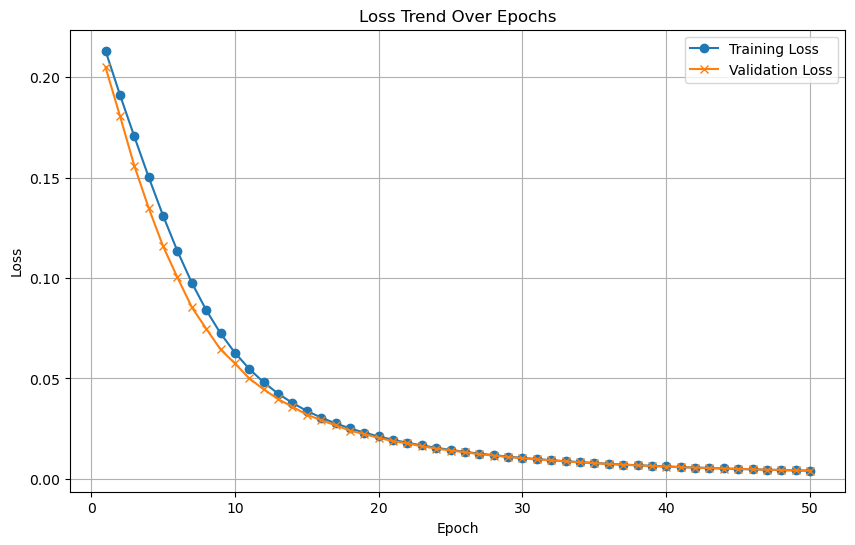

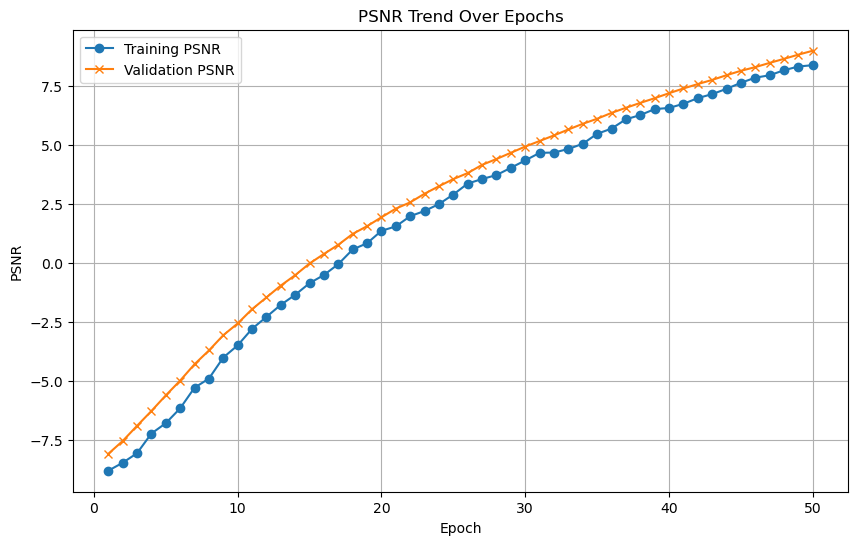

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/1 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...
    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/13 for test dataset.
Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training


Epoch [1/1000] completed, Average Training Loss: 2.6633
    Validation Batch [1/1], Loss: 2.6453
Validation Loss: 2.6453, Validation Accuracy: 7.14%
Validation loss improved from inf to 2.6453. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.6144
    Validation Batch [1/1], Loss: 2.6452
Validation Loss: 2.6452, Validation Accuracy: 7.14%
Validation loss improved from 2.6453 to 2.6452. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.5696
    Validation Batch [1/1], Loss: 2.6452
Validation Loss: 2.6452, Validation Accuracy: 7.14%
Validation loss improved from 2.6452 to 2.6452. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.5514
    Validation Batch [1/1], Loss: 2.6452
Validation Loss: 2.6452, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [5/1000] - Training
Epoch [5/1000] completed, Average Trai

Epoch [22/1000] completed, Average Training Loss: 2.3057
    Validation Batch [1/1], Loss: 2.6457
Validation Loss: 2.6457, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [23/1000] - Training
Epoch [23/1000] completed, Average Training Loss: 2.2851
    Validation Batch [1/1], Loss: 2.6458
Validation Loss: 2.6458, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [24/1000] - Training
Epoch [24/1000] completed, Average Training Loss: 2.2880
    Validation Batch [1/1], Loss: 2.6459
Validation Loss: 2.6459, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [25/1000] - Training
Epoch [25/1000] completed, Average Training Loss: 2.2736
    Validation Batch [1/1], Loss: 2.6460
Validation Loss: 2.6460, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [26/1000] - Training
Epoch [26/1000] completed, Average Training Loss: 2.2741
    Validat

    Validation Batch [1/1], Loss: 2.6460
Validation Loss: 2.6460, Validation Accuracy: 7.14%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [31/1000] - Training
Epoch [31/1000] completed, Average Training Loss: 2.2337
    Validation Batch [1/1], Loss: 2.6459
Validation Loss: 2.6459, Validation Accuracy: 11.43%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [32/1000] - Training
Epoch [32/1000] completed, Average Training Loss: 2.2329
    Validation Batch [1/1], Loss: 2.6457
Validation Loss: 2.6457, Validation Accuracy: 17.14%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [33/1000] - Training
Epoch [33/1000] completed, Average Training Loss: 2.1639
    Validation Batch [1/1], Loss: 2.6453
Validation Loss: 2.6453, Validation Accuracy: 20.00%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [34/1000] - Training
Epoch [34/1000] completed, Average Training Loss: 2.2001
    Validation Batch [1/1], Loss: 2.6448
Validation Loss: 2.6448,

    Validation Batch [1/1], Loss: 2.6328
Validation Loss: 2.6328, Validation Accuracy: 15.71%
Validation loss improved from 2.6343 to 2.6328. Saving model...

LOG: Epoch [53/1000] - Training
Epoch [53/1000] completed, Average Training Loss: 2.0211
    Validation Batch [1/1], Loss: 2.6312
Validation Loss: 2.6312, Validation Accuracy: 15.71%
Validation loss improved from 2.6328 to 2.6312. Saving model...

LOG: Epoch [54/1000] - Training
Epoch [54/1000] completed, Average Training Loss: 2.0060
    Validation Batch [1/1], Loss: 2.6293
Validation Loss: 2.6293, Validation Accuracy: 17.14%
Validation loss improved from 2.6312 to 2.6293. Saving model...

LOG: Epoch [55/1000] - Training
Epoch [55/1000] completed, Average Training Loss: 2.0202
    Validation Batch [1/1], Loss: 2.6270
Validation Loss: 2.6270, Validation Accuracy: 20.00%
Validation loss improved from 2.6293 to 2.6270. Saving model...

LOG: Epoch [56/1000] - Training
Epoch [56/1000] completed, Average Training Loss: 1.9890
    Vali

Epoch [62/1000] completed, Average Training Loss: 1.9634
    Validation Batch [1/1], Loss: 2.5864
Validation Loss: 2.5864, Validation Accuracy: 21.43%
Validation loss improved from 2.5937 to 2.5864. Saving model...

LOG: Epoch [63/1000] - Training
Epoch [63/1000] completed, Average Training Loss: 1.9964
    Validation Batch [1/1], Loss: 2.5793
Validation Loss: 2.5793, Validation Accuracy: 20.00%
Validation loss improved from 2.5864 to 2.5793. Saving model...

LOG: Epoch [64/1000] - Training
Epoch [64/1000] completed, Average Training Loss: 1.9537
    Validation Batch [1/1], Loss: 2.5721
Validation Loss: 2.5721, Validation Accuracy: 18.57%
Validation loss improved from 2.5793 to 2.5721. Saving model...

LOG: Epoch [65/1000] - Training
Epoch [65/1000] completed, Average Training Loss: 1.9553
    Validation Batch [1/1], Loss: 2.5630
Validation Loss: 2.5630, Validation Accuracy: 21.43%
Validation loss improved from 2.5721 to 2.5630. Saving model...

LOG: Epoch [66/1000] - Training
Epoch [6

    Validation Batch [1/1], Loss: 2.2438
Validation Loss: 2.2438, Validation Accuracy: 34.29%
Validation loss improved from 2.2694 to 2.2438. Saving model...

LOG: Epoch [84/1000] - Training
Epoch [84/1000] completed, Average Training Loss: 1.7745
    Validation Batch [1/1], Loss: 2.2274
Validation Loss: 2.2274, Validation Accuracy: 35.71%
Validation loss improved from 2.2438 to 2.2274. Saving model...

LOG: Epoch [85/1000] - Training
Epoch [85/1000] completed, Average Training Loss: 1.7923
    Validation Batch [1/1], Loss: 2.2188
Validation Loss: 2.2188, Validation Accuracy: 34.29%
Validation loss improved from 2.2274 to 2.2188. Saving model...

LOG: Epoch [86/1000] - Training
Epoch [86/1000] completed, Average Training Loss: 1.7823
    Validation Batch [1/1], Loss: 2.2097
Validation Loss: 2.2097, Validation Accuracy: 32.86%
Validation loss improved from 2.2188 to 2.2097. Saving model...

LOG: Epoch [87/1000] - Training
Epoch [87/1000] completed, Average Training Loss: 1.7647
    Vali

    Validation Batch [1/1], Loss: 2.0931
Validation Loss: 2.0931, Validation Accuracy: 37.14%
Validation loss improved from 2.1166 to 2.0931. Saving model...

LOG: Epoch [93/1000] - Training
Epoch [93/1000] completed, Average Training Loss: 1.7059
    Validation Batch [1/1], Loss: 2.0674
Validation Loss: 2.0674, Validation Accuracy: 34.29%
Validation loss improved from 2.0931 to 2.0674. Saving model...

LOG: Epoch [94/1000] - Training
Epoch [94/1000] completed, Average Training Loss: 1.7207
    Validation Batch [1/1], Loss: 2.0547
Validation Loss: 2.0547, Validation Accuracy: 35.71%
Validation loss improved from 2.0674 to 2.0547. Saving model...

LOG: Epoch [95/1000] - Training
Epoch [95/1000] completed, Average Training Loss: 1.7556
    Validation Batch [1/1], Loss: 2.0481
Validation Loss: 2.0481, Validation Accuracy: 37.14%
Validation loss improved from 2.0547 to 2.0481. Saving model...

LOG: Epoch [96/1000] - Training
Epoch [96/1000] completed, Average Training Loss: 1.7345
    Vali

    Validation Batch [1/1], Loss: 1.8561
Validation Loss: 1.8561, Validation Accuracy: 51.43%
Validation loss improved from 1.8588 to 1.8561. Saving model...

LOG: Epoch [115/1000] - Training
Epoch [115/1000] completed, Average Training Loss: 1.5433
    Validation Batch [1/1], Loss: 1.8391
Validation Loss: 1.8391, Validation Accuracy: 52.86%
Validation loss improved from 1.8561 to 1.8391. Saving model...

LOG: Epoch [116/1000] - Training
Epoch [116/1000] completed, Average Training Loss: 1.5458
    Validation Batch [1/1], Loss: 1.8240
Validation Loss: 1.8240, Validation Accuracy: 58.57%
Validation loss improved from 1.8391 to 1.8240. Saving model...

LOG: Epoch [117/1000] - Training
Epoch [117/1000] completed, Average Training Loss: 1.5524
    Validation Batch [1/1], Loss: 1.8198
Validation Loss: 1.8198, Validation Accuracy: 60.00%
Validation loss improved from 1.8240 to 1.8198. Saving model...

LOG: Epoch [118/1000] - Training
Epoch [118/1000] completed, Average Training Loss: 1.5184


Epoch [123/1000] completed, Average Training Loss: 1.5094
    Validation Batch [1/1], Loss: 1.8108
Validation Loss: 1.8108, Validation Accuracy: 54.29%
Validation loss improved from 1.8137 to 1.8108. Saving model...

LOG: Epoch [124/1000] - Training
Epoch [124/1000] completed, Average Training Loss: 1.5084
    Validation Batch [1/1], Loss: 1.8173
Validation Loss: 1.8173, Validation Accuracy: 52.86%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [125/1000] - Training
Epoch [125/1000] completed, Average Training Loss: 1.4845
    Validation Batch [1/1], Loss: 1.7936
Validation Loss: 1.7936, Validation Accuracy: 55.71%
Validation loss improved from 1.8108 to 1.7936. Saving model...

LOG: Epoch [126/1000] - Training
Epoch [126/1000] completed, Average Training Loss: 1.4765
    Validation Batch [1/1], Loss: 1.7760
Validation Loss: 1.7760, Validation Accuracy: 61.43%
Validation loss improved from 1.7936 to 1.7760. Saving model...

LOG: Epoch [127/1000] - Training
Epoch [127/1000

Epoch [146/1000] completed, Average Training Loss: 1.2794
    Validation Batch [1/1], Loss: 1.6765
Validation Loss: 1.6765, Validation Accuracy: 60.00%
Validation loss improved from 1.6784 to 1.6765. Saving model...

LOG: Epoch [147/1000] - Training
Epoch [147/1000] completed, Average Training Loss: 1.3223
    Validation Batch [1/1], Loss: 1.6573
Validation Loss: 1.6573, Validation Accuracy: 62.86%
Validation loss improved from 1.6765 to 1.6573. Saving model...

LOG: Epoch [148/1000] - Training
Epoch [148/1000] completed, Average Training Loss: 1.3302
    Validation Batch [1/1], Loss: 1.6628
Validation Loss: 1.6628, Validation Accuracy: 65.71%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [149/1000] - Training
Epoch [149/1000] completed, Average Training Loss: 1.2959
    Validation Batch [1/1], Loss: 1.6684
Validation Loss: 1.6684, Validation Accuracy: 64.29%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [150/1000] - Training
Epoch [150/1000] completed, Av

    Validation Batch [1/1], Loss: 1.6350
Validation Loss: 1.6350, Validation Accuracy: 64.29%
Validation loss improved from 1.6357 to 1.6350. Saving model...

LOG: Epoch [156/1000] - Training
Epoch [156/1000] completed, Average Training Loss: 1.2447
    Validation Batch [1/1], Loss: 1.6253
Validation Loss: 1.6253, Validation Accuracy: 62.86%
Validation loss improved from 1.6350 to 1.6253. Saving model...

LOG: Epoch [157/1000] - Training
Epoch [157/1000] completed, Average Training Loss: 1.2708
    Validation Batch [1/1], Loss: 1.6193
Validation Loss: 1.6193, Validation Accuracy: 65.71%
Validation loss improved from 1.6253 to 1.6193. Saving model...

LOG: Epoch [158/1000] - Training
Epoch [158/1000] completed, Average Training Loss: 1.2333
    Validation Batch [1/1], Loss: 1.6104
Validation Loss: 1.6104, Validation Accuracy: 65.71%
Validation loss improved from 1.6193 to 1.6104. Saving model...

LOG: Epoch [159/1000] - Training
Epoch [159/1000] completed, Average Training Loss: 1.2556


Epoch [178/1000] completed, Average Training Loss: 1.1409
    Validation Batch [1/1], Loss: 1.5283
Validation Loss: 1.5283, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [179/1000] - Training
Epoch [179/1000] completed, Average Training Loss: 1.0944
    Validation Batch [1/1], Loss: 1.5282
Validation Loss: 1.5282, Validation Accuracy: 61.43%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [180/1000] - Training
Epoch [180/1000] completed, Average Training Loss: 1.1152
    Validation Batch [1/1], Loss: 1.5286
Validation Loss: 1.5286, Validation Accuracy: 61.43%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [181/1000] - Training
Epoch [181/1000] completed, Average Training Loss: 1.1639
    Validation Batch [1/1], Loss: 1.5318
Validation Loss: 1.5318, Validation Accuracy: 60.00%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [182/1000] - Training
Epoch [182/1000] completed, Average Training Loss: 1.0962
  

    Validation Batch [1/1], Loss: 1.4967
Validation Loss: 1.4967, Validation Accuracy: 62.86%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [187/1000] - Training
Epoch [187/1000] completed, Average Training Loss: 1.0581
    Validation Batch [1/1], Loss: 1.4942
Validation Loss: 1.4942, Validation Accuracy: 61.43%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [188/1000] - Training
Epoch [188/1000] completed, Average Training Loss: 1.0673
    Validation Batch [1/1], Loss: 1.4881
Validation Loss: 1.4881, Validation Accuracy: 61.43%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [189/1000] - Training
Epoch [189/1000] completed, Average Training Loss: 1.0394
    Validation Batch [1/1], Loss: 1.4703
Validation Loss: 1.4703, Validation Accuracy: 62.86%
Validation loss improved from 1.4877 to 1.4703. Saving model...

LOG: Epoch [190/1000] - Training
Epoch [190/1000] completed, Average Training Loss: 1.0431
    Validation Batch [1/1], Loss: 1.4610
Vali

Epoch [208/1000] completed, Average Training Loss: 0.9125
    Validation Batch [1/1], Loss: 1.3760
Validation Loss: 1.3760, Validation Accuracy: 67.14%
Validation loss improved from 1.3792 to 1.3760. Saving model...

LOG: Epoch [209/1000] - Training
Epoch [209/1000] completed, Average Training Loss: 0.9406
    Validation Batch [1/1], Loss: 1.3723
Validation Loss: 1.3723, Validation Accuracy: 67.14%
Validation loss improved from 1.3760 to 1.3723. Saving model...

LOG: Epoch [210/1000] - Training
Epoch [210/1000] completed, Average Training Loss: 0.8642
    Validation Batch [1/1], Loss: 1.3679
Validation Loss: 1.3679, Validation Accuracy: 68.57%
Validation loss improved from 1.3723 to 1.3679. Saving model...

LOG: Epoch [211/1000] - Training
Epoch [211/1000] completed, Average Training Loss: 0.8653
    Validation Batch [1/1], Loss: 1.3657
Validation Loss: 1.3657, Validation Accuracy: 70.00%
Validation loss improved from 1.3679 to 1.3657. Saving model...

LOG: Epoch [212/1000] - Training


    Validation Batch [1/1], Loss: 1.3460
Validation Loss: 1.3460, Validation Accuracy: 68.57%
Validation loss improved from 1.3501 to 1.3460. Saving model...

LOG: Epoch [217/1000] - Training
Epoch [217/1000] completed, Average Training Loss: 0.8544
    Validation Batch [1/1], Loss: 1.3346
Validation Loss: 1.3346, Validation Accuracy: 70.00%
Validation loss improved from 1.3460 to 1.3346. Saving model...

LOG: Epoch [218/1000] - Training
Epoch [218/1000] completed, Average Training Loss: 0.8358
    Validation Batch [1/1], Loss: 1.3230
Validation Loss: 1.3230, Validation Accuracy: 70.00%
Validation loss improved from 1.3346 to 1.3230. Saving model...

LOG: Epoch [219/1000] - Training
Epoch [219/1000] completed, Average Training Loss: 0.8762
    Validation Batch [1/1], Loss: 1.3208
Validation Loss: 1.3208, Validation Accuracy: 71.43%
Validation loss improved from 1.3230 to 1.3208. Saving model...

LOG: Epoch [220/1000] - Training
Epoch [220/1000] completed, Average Training Loss: 0.9080


Epoch [241/1000] completed, Average Training Loss: 0.7198
    Validation Batch [1/1], Loss: 1.2112
Validation Loss: 1.2112, Validation Accuracy: 70.00%
Validation loss improved from 1.2183 to 1.2112. Saving model...

LOG: Epoch [242/1000] - Training
Epoch [242/1000] completed, Average Training Loss: 0.7747
    Validation Batch [1/1], Loss: 1.1937
Validation Loss: 1.1937, Validation Accuracy: 71.43%
Validation loss improved from 1.2112 to 1.1937. Saving model...

LOG: Epoch [243/1000] - Training
Epoch [243/1000] completed, Average Training Loss: 0.6656
    Validation Batch [1/1], Loss: 1.1895
Validation Loss: 1.1895, Validation Accuracy: 71.43%
Validation loss improved from 1.1937 to 1.1895. Saving model...

LOG: Epoch [244/1000] - Training
Epoch [244/1000] completed, Average Training Loss: 0.7252
    Validation Batch [1/1], Loss: 1.1864
Validation Loss: 1.1864, Validation Accuracy: 72.86%
Validation loss improved from 1.1895 to 1.1864. Saving model...

LOG: Epoch [245/1000] - Training


    Validation Batch [1/1], Loss: 1.1873
Validation Loss: 1.1873, Validation Accuracy: 72.86%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [248/1000] - Training
Epoch [248/1000] completed, Average Training Loss: 0.7390
    Validation Batch [1/1], Loss: 1.1763
Validation Loss: 1.1763, Validation Accuracy: 70.00%
Validation loss improved from 1.1864 to 1.1763. Saving model...

LOG: Epoch [249/1000] - Training
Epoch [249/1000] completed, Average Training Loss: 0.7537
    Validation Batch [1/1], Loss: 1.1787
Validation Loss: 1.1787, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [250/1000] - Training
Epoch [250/1000] completed, Average Training Loss: 0.7124
    Validation Batch [1/1], Loss: 1.1859
Validation Loss: 1.1859, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [251/1000] - Training
Epoch [251/1000] completed, Average Training Loss: 0.6533
    Validation Batch [1/1], Loss: 1.1761
Vali

Epoch [273/1000] completed, Average Training Loss: 0.6312
    Validation Batch [1/1], Loss: 1.0797
Validation Loss: 1.0797, Validation Accuracy: 70.00%
Validation loss improved from 1.0877 to 1.0797. Saving model...

LOG: Epoch [274/1000] - Training
Epoch [274/1000] completed, Average Training Loss: 0.5986
    Validation Batch [1/1], Loss: 1.0859
Validation Loss: 1.0859, Validation Accuracy: 68.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [275/1000] - Training
Epoch [275/1000] completed, Average Training Loss: 0.6231
    Validation Batch [1/1], Loss: 1.1027
Validation Loss: 1.1027, Validation Accuracy: 67.14%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [276/1000] - Training
Epoch [276/1000] completed, Average Training Loss: 0.5944
    Validation Batch [1/1], Loss: 1.1114
Validation Loss: 1.1114, Validation Accuracy: 70.00%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [277/1000] - Training
Epoch [277/1000] completed, Average Training 

Epoch [280/1000] completed, Average Training Loss: 0.5701
    Validation Batch [1/1], Loss: 1.0747
Validation Loss: 1.0747, Validation Accuracy: 72.86%
Validation loss improved from 1.0797 to 1.0747. Saving model...

LOG: Epoch [281/1000] - Training
Epoch [281/1000] completed, Average Training Loss: 0.5452
    Validation Batch [1/1], Loss: 1.0676
Validation Loss: 1.0676, Validation Accuracy: 72.86%
Validation loss improved from 1.0747 to 1.0676. Saving model...

LOG: Epoch [282/1000] - Training
Epoch [282/1000] completed, Average Training Loss: 0.5490
    Validation Batch [1/1], Loss: 1.0574
Validation Loss: 1.0574, Validation Accuracy: 70.00%
Validation loss improved from 1.0676 to 1.0574. Saving model...

LOG: Epoch [283/1000] - Training
Epoch [283/1000] completed, Average Training Loss: 0.5667
    Validation Batch [1/1], Loss: 1.0543
Validation Loss: 1.0543, Validation Accuracy: 72.86%
Validation loss improved from 1.0574 to 1.0543. Saving model...

LOG: Epoch [284/1000] - Training


Epoch [304/1000] completed, Average Training Loss: 0.4779
    Validation Batch [1/1], Loss: 0.9534
Validation Loss: 0.9534, Validation Accuracy: 74.29%
Validation loss improved from 0.9612 to 0.9534. Saving model...

LOG: Epoch [305/1000] - Training
Epoch [305/1000] completed, Average Training Loss: 0.4654
    Validation Batch [1/1], Loss: 0.9573
Validation Loss: 0.9573, Validation Accuracy: 74.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [306/1000] - Training
Epoch [306/1000] completed, Average Training Loss: 0.4676
    Validation Batch [1/1], Loss: 0.9569
Validation Loss: 0.9569, Validation Accuracy: 74.29%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [307/1000] - Training
Epoch [307/1000] completed, Average Training Loss: 0.4902
    Validation Batch [1/1], Loss: 0.9615
Validation Loss: 0.9615, Validation Accuracy: 74.29%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [308/1000] - Training
Epoch [308/1000] completed, Average Training 

Epoch [309/1000] completed, Average Training Loss: 0.4312
    Validation Batch [1/1], Loss: 0.9716
Validation Loss: 0.9716, Validation Accuracy: 74.29%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [310/1000] - Training
Epoch [310/1000] completed, Average Training Loss: 0.4950
    Validation Batch [1/1], Loss: 0.9725
Validation Loss: 0.9725, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [311/1000] - Training
Epoch [311/1000] completed, Average Training Loss: 0.4445
    Validation Batch [1/1], Loss: 0.9711
Validation Loss: 0.9711, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [312/1000] - Training
Epoch [312/1000] completed, Average Training Loss: 0.4304
    Validation Batch [1/1], Loss: 0.9542
Validation Loss: 0.9542, Validation Accuracy: 75.71%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [313/1000] - Training
Epoch [313/1000] completed, Average Training Loss: 0.4478
  

Epoch [335/1000] completed, Average Training Loss: 0.4693
    Validation Batch [1/1], Loss: 0.9151
Validation Loss: 0.9151, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [336/1000] - Training
Epoch [336/1000] completed, Average Training Loss: 0.3883
    Validation Batch [1/1], Loss: 0.9003
Validation Loss: 0.9003, Validation Accuracy: 74.29%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [337/1000] - Training
Epoch [337/1000] completed, Average Training Loss: 0.3981
    Validation Batch [1/1], Loss: 0.8904
Validation Loss: 0.8904, Validation Accuracy: 75.71%
Validation loss improved from 0.8909 to 0.8904. Saving model...

LOG: Epoch [338/1000] - Training
Epoch [338/1000] completed, Average Training Loss: 0.4001
    Validation Batch [1/1], Loss: 0.8751
Validation Loss: 0.8751, Validation Accuracy: 81.43%
Validation loss improved from 0.8904 to 0.8751. Saving model...

LOG: Epoch [339/1000] - Training
Epoch [339/1000] completed, Av


LOG: Epoch [365/1000] - Training
Epoch [365/1000] completed, Average Training Loss: 0.2940
    Validation Batch [1/1], Loss: 0.7994
Validation Loss: 0.7994, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [366/1000] - Training
Epoch [366/1000] completed, Average Training Loss: 0.3344
    Validation Batch [1/1], Loss: 0.8019
Validation Loss: 0.8019, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [367/1000] - Training
Epoch [367/1000] completed, Average Training Loss: 0.2578
    Validation Batch [1/1], Loss: 0.7721
Validation Loss: 0.7721, Validation Accuracy: 82.86%
Validation loss improved from 0.7838 to 0.7721. Saving model...

LOG: Epoch [368/1000] - Training
Epoch [368/1000] completed, Average Training Loss: 0.2641
    Validation Batch [1/1], Loss: 0.7650
Validation Loss: 0.7650, Validation Accuracy: 81.43%
Validation loss improved from 0.7721 to 0.7650. Saving model...

LOG: Epoch [369/1000] - Train

Epoch [394/1000] completed, Average Training Loss: 0.2478
    Validation Batch [1/1], Loss: 0.7155
Validation Loss: 0.7155, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [395/1000] - Training
Epoch [395/1000] completed, Average Training Loss: 0.2268
    Validation Batch [1/1], Loss: 0.6966
Validation Loss: 0.6966, Validation Accuracy: 81.43%
Validation loss improved from 0.7142 to 0.6966. Saving model...

LOG: Epoch [396/1000] - Training
Epoch [396/1000] completed, Average Training Loss: 0.1858
    Validation Batch [1/1], Loss: 0.6922
Validation Loss: 0.6922, Validation Accuracy: 81.43%
Validation loss improved from 0.6966 to 0.6922. Saving model...

LOG: Epoch [397/1000] - Training
Epoch [397/1000] completed, Average Training Loss: 0.2317
    Validation Batch [1/1], Loss: 0.6912
Validation Loss: 0.6912, Validation Accuracy: 81.43%
Validation loss improved from 0.6922 to 0.6912. Saving model...

LOG: Epoch [398/1000] - Training
Epoch [398/1000

Epoch [424/1000] completed, Average Training Loss: 0.1363
    Validation Batch [1/1], Loss: 0.6504
Validation Loss: 0.6504, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [425/1000] - Training
Epoch [425/1000] completed, Average Training Loss: 0.1759
    Validation Batch [1/1], Loss: 0.6486
Validation Loss: 0.6486, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [426/1000] - Training
Epoch [426/1000] completed, Average Training Loss: 0.1736
    Validation Batch [1/1], Loss: 0.6455
Validation Loss: 0.6455, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [427/1000] - Training
Epoch [427/1000] completed, Average Training Loss: 0.1825
    Validation Batch [1/1], Loss: 0.6473
Validation Loss: 0.6473, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [428/1000] - Training
Epoch [428/1000] completed, Average Training Loss: 0.2090
  

Validation Loss: 0.6318, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [455/1000] - Training
Epoch [455/1000] completed, Average Training Loss: 0.1458
    Validation Batch [1/1], Loss: 0.6333
Validation Loss: 0.6333, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [456/1000] - Training
Epoch [456/1000] completed, Average Training Loss: 0.1557
    Validation Batch [1/1], Loss: 0.6287
Validation Loss: 0.6287, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [457/1000] - Training
Epoch [457/1000] completed, Average Training Loss: 0.1567
    Validation Batch [1/1], Loss: 0.6180
Validation Loss: 0.6180, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [458/1000] - Training
Epoch [458/1000] completed, Average Training Loss: 0.1557
    Validation Batch [1/1], Loss: 0.6058
Validation Loss: 0.6058, Validation Accuracy: 82.86%
Validat

Epoch [484/1000] completed, Average Training Loss: 0.1144
    Validation Batch [1/1], Loss: 0.6037
Validation Loss: 0.6037, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [485/1000] - Training
Epoch [485/1000] completed, Average Training Loss: 0.1622
    Validation Batch [1/1], Loss: 0.6080
Validation Loss: 0.6080, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 12/100

LOG: Epoch [486/1000] - Training
Epoch [486/1000] completed, Average Training Loss: 0.1194
    Validation Batch [1/1], Loss: 0.6116
Validation Loss: 0.6116, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 13/100

LOG: Epoch [487/1000] - Training
Epoch [487/1000] completed, Average Training Loss: 0.1399
    Validation Batch [1/1], Loss: 0.5984
Validation Loss: 0.5984, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [488/1000] - Training
Epoch [488/1000] completed, Average Training Loss: 0.144

Epoch [513/1000] completed, Average Training Loss: 0.0902
    Validation Batch [1/1], Loss: 0.5267
Validation Loss: 0.5267, Validation Accuracy: 81.43%
Validation loss improved from 0.5400 to 0.5267. Saving model...

LOG: Epoch [514/1000] - Training
Epoch [514/1000] completed, Average Training Loss: 0.1101
    Validation Batch [1/1], Loss: 0.5263
Validation Loss: 0.5263, Validation Accuracy: 85.71%
Validation loss improved from 0.5267 to 0.5263. Saving model...

LOG: Epoch [515/1000] - Training
Epoch [515/1000] completed, Average Training Loss: 0.0915
    Validation Batch [1/1], Loss: 0.5246
Validation Loss: 0.5246, Validation Accuracy: 84.29%
Validation loss improved from 0.5263 to 0.5246. Saving model...

LOG: Epoch [516/1000] - Training
Epoch [516/1000] completed, Average Training Loss: 0.0755
    Validation Batch [1/1], Loss: 0.5209
Validation Loss: 0.5209, Validation Accuracy: 85.71%
Validation loss improved from 0.5246 to 0.5209. Saving model...

LOG: Epoch [517/1000] - Training


Epoch [543/1000] completed, Average Training Loss: 0.0924
    Validation Batch [1/1], Loss: 0.5713
Validation Loss: 0.5713, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [544/1000] - Training
Epoch [544/1000] completed, Average Training Loss: 0.0755
    Validation Batch [1/1], Loss: 0.5753
Validation Loss: 0.5753, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [545/1000] - Training
Epoch [545/1000] completed, Average Training Loss: 0.0786
    Validation Batch [1/1], Loss: 0.5727
Validation Loss: 0.5727, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [546/1000] - Training
Epoch [546/1000] completed, Average Training Loss: 0.0854
    Validation Batch [1/1], Loss: 0.5605
Validation Loss: 0.5605, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [547/1000] - Training
Epoch [547/1000] completed, Average Training Loss: 0.097

    Validation Batch [1/1], Loss: 0.5416
Validation Loss: 0.5416, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 14/100

LOG: Epoch [574/1000] - Training
Epoch [574/1000] completed, Average Training Loss: 0.0634
    Validation Batch [1/1], Loss: 0.5400
Validation Loss: 0.5400, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [575/1000] - Training
Epoch [575/1000] completed, Average Training Loss: 0.1037
    Validation Batch [1/1], Loss: 0.5415
Validation Loss: 0.5415, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [576/1000] - Training
Epoch [576/1000] completed, Average Training Loss: 0.0792
    Validation Batch [1/1], Loss: 0.5496
Validation Loss: 0.5496, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [577/1000] - Training
Epoch [577/1000] completed, Average Training Loss: 0.0706
    Validation Batch [1/1], Loss: 0.5645
Validation Loss

Epoch [604/1000] completed, Average Training Loss: 0.0952
    Validation Batch [1/1], Loss: 0.4810
Validation Loss: 0.4810, Validation Accuracy: 84.29%
Validation loss improved from 0.4847 to 0.4810. Saving model...

LOG: Epoch [605/1000] - Training
Epoch [605/1000] completed, Average Training Loss: 0.0653
    Validation Batch [1/1], Loss: 0.4898
Validation Loss: 0.4898, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [606/1000] - Training
Epoch [606/1000] completed, Average Training Loss: 0.0574
    Validation Batch [1/1], Loss: 0.4977
Validation Loss: 0.4977, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [607/1000] - Training
Epoch [607/1000] completed, Average Training Loss: 0.0550
    Validation Batch [1/1], Loss: 0.5037
Validation Loss: 0.5037, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [608/1000] - Training
Epoch [608/1000] completed, Average Training 

Epoch [634/1000] completed, Average Training Loss: 0.0605
    Validation Batch [1/1], Loss: 0.5237
Validation Loss: 0.5237, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 30/100

LOG: Epoch [635/1000] - Training
Epoch [635/1000] completed, Average Training Loss: 0.0716
    Validation Batch [1/1], Loss: 0.5263
Validation Loss: 0.5263, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [636/1000] - Training
Epoch [636/1000] completed, Average Training Loss: 0.0579
    Validation Batch [1/1], Loss: 0.5359
Validation Loss: 0.5359, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [637/1000] - Training
Epoch [637/1000] completed, Average Training Loss: 0.0790
    Validation Batch [1/1], Loss: 0.5457
Validation Loss: 0.5457, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [638/1000] - Training
Epoch [638/1000] completed, Average Training Loss: 0.049

    Validation Batch [1/1], Loss: 0.6368
Validation Loss: 0.6368, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 15/100

LOG: Epoch [665/1000] - Training
Epoch [665/1000] completed, Average Training Loss: 0.0421
    Validation Batch [1/1], Loss: 0.6426
Validation Loss: 0.6426, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [666/1000] - Training
Epoch [666/1000] completed, Average Training Loss: 0.0508
    Validation Batch [1/1], Loss: 0.6467
Validation Loss: 0.6467, Validation Accuracy: 77.14%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [667/1000] - Training
Epoch [667/1000] completed, Average Training Loss: 0.0405
    Validation Batch [1/1], Loss: 0.6386
Validation Loss: 0.6386, Validation Accuracy: 75.71%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [668/1000] - Training
Epoch [668/1000] completed, Average Training Loss: 0.0673
    Validation Batch [1/1], Loss: 0.6210
Validation Loss

Epoch [696/1000] completed, Average Training Loss: 0.0419
    Validation Batch [1/1], Loss: 0.4910
Validation Loss: 0.4910, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [697/1000] - Training
Epoch [697/1000] completed, Average Training Loss: 0.0708
    Validation Batch [1/1], Loss: 0.5013
Validation Loss: 0.5013, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [698/1000] - Training
Epoch [698/1000] completed, Average Training Loss: 0.0435
    Validation Batch [1/1], Loss: 0.5055
Validation Loss: 0.5055, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [699/1000] - Training
Epoch [699/1000] completed, Average Training Loss: 0.0467
    Validation Batch [1/1], Loss: 0.4915
Validation Loss: 0.4915, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [700/1000] - Training
Epoch [700/1000] completed, Average Training Loss: 0.040

    Validation Batch [1/1], Loss: 0.4659
Validation Loss: 0.4659, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [727/1000] - Training
Epoch [727/1000] completed, Average Training Loss: 0.0459
    Validation Batch [1/1], Loss: 0.4653
Validation Loss: 0.4653, Validation Accuracy: 88.57%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [728/1000] - Training
Epoch [728/1000] completed, Average Training Loss: 0.0269
    Validation Batch [1/1], Loss: 0.4668
Validation Loss: 0.4668, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [729/1000] - Training
Epoch [729/1000] completed, Average Training Loss: 0.0318
    Validation Batch [1/1], Loss: 0.4769
Validation Loss: 0.4769, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [730/1000] - Training
Epoch [730/1000] completed, Average Training Loss: 0.0491
    Validation Batch [1/1], Loss: 0.4990
Validation Loss: 0.

Epoch [756/1000] completed, Average Training Loss: 0.0409
    Validation Batch [1/1], Loss: 0.5283
Validation Loss: 0.5283, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 31/100

LOG: Epoch [757/1000] - Training
Epoch [757/1000] completed, Average Training Loss: 0.0597
    Validation Batch [1/1], Loss: 0.5565
Validation Loss: 0.5565, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 32/100

LOG: Epoch [758/1000] - Training
Epoch [758/1000] completed, Average Training Loss: 0.0411
    Validation Batch [1/1], Loss: 0.5794
Validation Loss: 0.5794, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 33/100

LOG: Epoch [759/1000] - Training
Epoch [759/1000] completed, Average Training Loss: 0.0312
    Validation Batch [1/1], Loss: 0.5890
Validation Loss: 0.5890, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 34/100

LOG: Epoch [760/1000] - Training
Epoch [760/1000] completed, Average Training Loss: 0.046

    Validation Batch [1/1], Loss: 0.4923
Validation Loss: 0.4923, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [788/1000] - Training
Epoch [788/1000] completed, Average Training Loss: 0.0300
    Validation Batch [1/1], Loss: 0.4724
Validation Loss: 0.4724, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [789/1000] - Training
Epoch [789/1000] completed, Average Training Loss: 0.0411
    Validation Batch [1/1], Loss: 0.4562
Validation Loss: 0.4562, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [790/1000] - Training
Epoch [790/1000] completed, Average Training Loss: 0.0397
    Validation Batch [1/1], Loss: 0.4466
Validation Loss: 0.4466, Validation Accuracy: 84.29%
Validation loss improved from 0.4528 to 0.4466. Saving model...

LOG: Epoch [791/1000] - Training
Epoch [791/1000] completed, Average Training Loss: 0.0270
    Validation Batch [1/1], Loss: 0.4362
V

    Validation Batch [1/1], Loss: 0.4909
Validation Loss: 0.4909, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [816/1000] - Training
Epoch [816/1000] completed, Average Training Loss: 0.0196
    Validation Batch [1/1], Loss: 0.4928
Validation Loss: 0.4928, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [817/1000] - Training
Epoch [817/1000] completed, Average Training Loss: 0.0339
    Validation Batch [1/1], Loss: 0.4918
Validation Loss: 0.4918, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [818/1000] - Training
Epoch [818/1000] completed, Average Training Loss: 0.0352
    Validation Batch [1/1], Loss: 0.4832
Validation Loss: 0.4832, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [819/1000] - Training
Epoch [819/1000] completed, Average Training Loss: 0.0287
    Validation Batch [1/1], Loss: 0.4808
Validation Loss

    Validation Batch [1/1], Loss: 0.6264
Validation Loss: 0.6264, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 51/100

LOG: Epoch [845/1000] - Training
Epoch [845/1000] completed, Average Training Loss: 0.0297
    Validation Batch [1/1], Loss: 0.5928
Validation Loss: 0.5928, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 52/100

LOG: Epoch [846/1000] - Training
Epoch [846/1000] completed, Average Training Loss: 0.0363
    Validation Batch [1/1], Loss: 0.5552
Validation Loss: 0.5552, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 53/100

LOG: Epoch [847/1000] - Training
Epoch [847/1000] completed, Average Training Loss: 0.0270
    Validation Batch [1/1], Loss: 0.5258
Validation Loss: 0.5258, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 54/100

LOG: Epoch [848/1000] - Training
Epoch [848/1000] completed, Average Training Loss: 0.0173
    Validation Batch [1/1], Loss: 0.5024
Validation Loss

    Validation Batch [1/1], Loss: 0.4339
Validation Loss: 0.4339, Validation Accuracy: 87.14%
Validation loss did not improve. Patience: 82/100

LOG: Epoch [876/1000] - Training
Epoch [876/1000] completed, Average Training Loss: 0.0273
    Validation Batch [1/1], Loss: 0.4329
Validation Loss: 0.4329, Validation Accuracy: 85.71%
Validation loss did not improve. Patience: 83/100

LOG: Epoch [877/1000] - Training
Epoch [877/1000] completed, Average Training Loss: 0.0192
    Validation Batch [1/1], Loss: 0.4285
Validation Loss: 0.4285, Validation Accuracy: 87.14%
Validation loss improved from 0.4300 to 0.4285. Saving model...

LOG: Epoch [878/1000] - Training
Epoch [878/1000] completed, Average Training Loss: 0.0195
    Validation Batch [1/1], Loss: 0.4259
Validation Loss: 0.4259, Validation Accuracy: 88.57%
Validation loss improved from 0.4285 to 0.4259. Saving model...

LOG: Epoch [879/1000] - Training
Epoch [879/1000] completed, Average Training Loss: 0.0196
    Validation Batch [1/1], 

Epoch [904/1000] completed, Average Training Loss: 0.0171
    Validation Batch [1/1], Loss: 0.4695
Validation Loss: 0.4695, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [905/1000] - Training
Epoch [905/1000] completed, Average Training Loss: 0.0427
    Validation Batch [1/1], Loss: 0.4652
Validation Loss: 0.4652, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [906/1000] - Training
Epoch [906/1000] completed, Average Training Loss: 0.0236
    Validation Batch [1/1], Loss: 0.4535
Validation Loss: 0.4535, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 28/100

LOG: Epoch [907/1000] - Training
Epoch [907/1000] completed, Average Training Loss: 0.0294
    Validation Batch [1/1], Loss: 0.4391
Validation Loss: 0.4391, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 29/100

LOG: Epoch [908/1000] - Training
Epoch [908/1000] completed, Average Training Loss: 0.030

Epoch [935/1000] completed, Average Training Loss: 0.0207
    Validation Batch [1/1], Loss: 0.4661
Validation Loss: 0.4661, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 57/100

LOG: Epoch [936/1000] - Training
Epoch [936/1000] completed, Average Training Loss: 0.0207
    Validation Batch [1/1], Loss: 0.4565
Validation Loss: 0.4565, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 58/100

LOG: Epoch [937/1000] - Training
Epoch [937/1000] completed, Average Training Loss: 0.0210
    Validation Batch [1/1], Loss: 0.4433
Validation Loss: 0.4433, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 59/100

LOG: Epoch [938/1000] - Training
Epoch [938/1000] completed, Average Training Loss: 0.0212
    Validation Batch [1/1], Loss: 0.4391
Validation Loss: 0.4391, Validation Accuracy: 84.29%
Validation loss did not improve. Patience: 60/100

LOG: Epoch [939/1000] - Training
Epoch [939/1000] completed, Average Training Loss: 0.025

Epoch [965/1000] completed, Average Training Loss: 0.0190
    Validation Batch [1/1], Loss: 0.4588
Validation Loss: 0.4588, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [966/1000] - Training
Epoch [966/1000] completed, Average Training Loss: 0.0256
    Validation Batch [1/1], Loss: 0.4718
Validation Loss: 0.4718, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [967/1000] - Training
Epoch [967/1000] completed, Average Training Loss: 0.0231
    Validation Batch [1/1], Loss: 0.4801
Validation Loss: 0.4801, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [968/1000] - Training
Epoch [968/1000] completed, Average Training Loss: 0.0206
    Validation Batch [1/1], Loss: 0.4780
Validation Loss: 0.4780, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [969/1000] - Training
Epoch [969/1000] completed, Average Training Loss: 0.0275
 

Epoch [997/1000] completed, Average Training Loss: 0.0179
    Validation Batch [1/1], Loss: 0.4848
Validation Loss: 0.4848, Validation Accuracy: 81.43%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [998/1000] - Training
Epoch [998/1000] completed, Average Training Loss: 0.0207
    Validation Batch [1/1], Loss: 0.5106
Validation Loss: 0.5106, Validation Accuracy: 78.57%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [999/1000] - Training
Epoch [999/1000] completed, Average Training Loss: 0.0157
    Validation Batch [1/1], Loss: 0.5354
Validation Loss: 0.5354, Validation Accuracy: 80.00%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1000/1000] - Training
Epoch [1000/1000] completed, Average Training Loss: 0.0196
    Validation Batch [1/1], Loss: 0.5546
Validation Loss: 0.5546, Validation Accuracy: 82.86%
Validation loss did not improve. Patience: 9/100
Loading the best model weights...


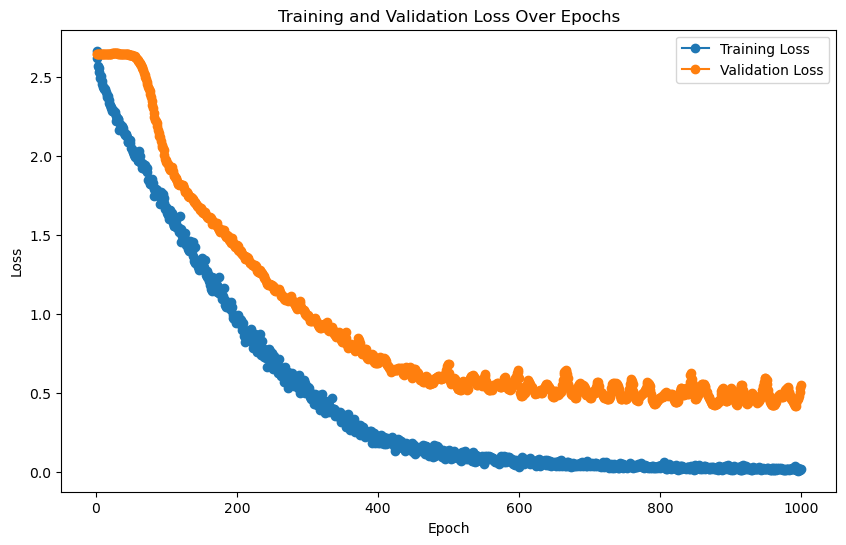

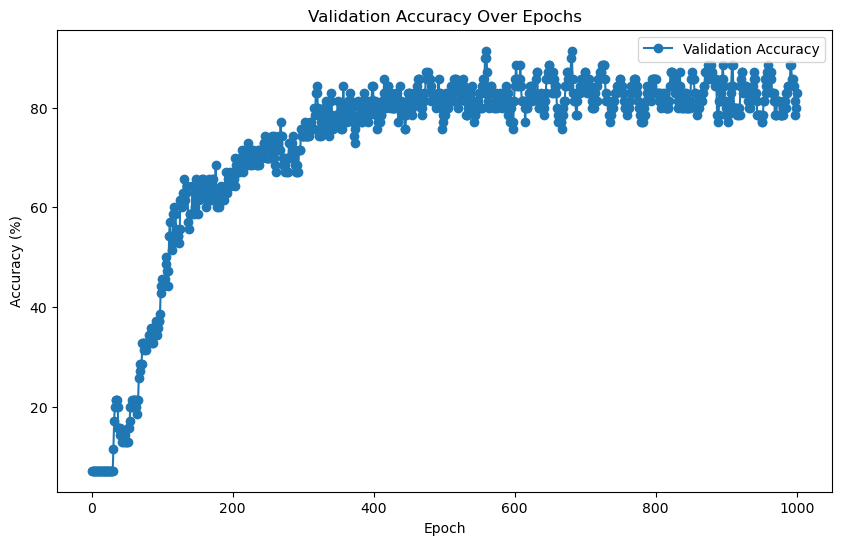


Evaluating on the test set...
    Test Batch [1/13], Loss: 0.0812

Final Test Loss: 0.4311, Test Accuracy: 87.39%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/13 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 3108 samples with 64 features each
LOG: Labels shape: (3108,)

LOG: Training features shape: (70, 64), Training labels shape: (70,)
LOG: Validation features shape: (70, 64), Validation labels shape: (70,)
LOG: Test features shape: (3108, 64), Test labels shape: (3108,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 68.57%

Validation Classification Report:
               precision    recall  f1-sco

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 3108 samples with 64 features each
LOG: Labels shape: (3108,)
Train reps shape: (70, 64)
Train labels shape: (70,)
Val reps shape: (70, 64)
Val labels shape: (70,)
Test reps shape: (3108, 64)
Test labels shape: (3108,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.7594  |  Val Loss: 2.6839
Validation loss improved from inf to 2.6839.
[Epoch 2/1000] Train Loss: 2.6749  |  Val Loss: 2.6583
Validation loss improved from 2.6839 to 2.6583.
[Epoch 3/1000] Train Loss: 2.6563  |  Val Loss: 2.6558
Validation loss improved from 2.6583 to 2.6558.
[Epoch 4/1000] Train Loss: 2.6521  |  Val Loss: 2.6497
Validation loss improved from 2.6558 to 2.6497.
[Epoch 5/1000] Train Loss: 2.6481  |  Val Loss: 2.6415
Validation loss improved from 2.6497 to 2.6415.
[Epoch 6/1000] Train Loss: 2.6382  |  Val Loss: 2.6334
Validation loss improved from 2.6415 to 2.6334.


[Epoch 7/1000] Train Loss: 2.6288  |  Val Loss: 2.6259
Validation loss improved from 2.6334 to 2.6259.
[Epoch 8/1000] Train Loss: 2.6222  |  Val Loss: 2.6216
Validation loss improved from 2.6259 to 2.6216.
[Epoch 9/1000] Train Loss: 2.6208  |  Val Loss: 2.6197
Validation loss improved from 2.6216 to 2.6197.
[Epoch 10/1000] Train Loss: 2.6182  |  Val Loss: 2.6184
Validation loss improved from 2.6197 to 2.6184.
[Epoch 11/1000] Train Loss: 2.6181  |  Val Loss: 2.6166
Validation loss improved from 2.6184 to 2.6166.
[Epoch 12/1000] Train Loss: 2.6157  |  Val Loss: 2.6139
Validation loss improved from 2.6166 to 2.6139.
[Epoch 13/1000] Train Loss: 2.6111  |  Val Loss: 2.6120
Validation loss improved from 2.6139 to 2.6120.
[Epoch 14/1000] Train Loss: 2.6098  |  Val Loss: 2.6124
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 15/1000] Train Loss: 2.6108  |  Val Loss: 2.6137
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 16/1000] Train Loss: 2.6106  |  Val Loss: 2.6137

[Epoch 36/1000] Train Loss: 2.5496  |  Val Loss: 2.5486
Validation loss improved from 2.5537 to 2.5486.
[Epoch 37/1000] Train Loss: 2.5442  |  Val Loss: 2.5417
Validation loss improved from 2.5486 to 2.5417.
[Epoch 38/1000] Train Loss: 2.5375  |  Val Loss: 2.5337
Validation loss improved from 2.5417 to 2.5337.
[Epoch 39/1000] Train Loss: 2.5300  |  Val Loss: 2.5284
Validation loss improved from 2.5337 to 2.5284.
[Epoch 40/1000] Train Loss: 2.5267  |  Val Loss: 2.5240
Validation loss improved from 2.5284 to 2.5240.
[Epoch 41/1000] Train Loss: 2.5233  |  Val Loss: 2.5191
Validation loss improved from 2.5240 to 2.5191.
[Epoch 42/1000] Train Loss: 2.5171  |  Val Loss: 2.5140
Validation loss improved from 2.5191 to 2.5140.
[Epoch 43/1000] Train Loss: 2.5118  |  Val Loss: 2.5059
Validation loss improved from 2.5140 to 2.5059.
[Epoch 44/1000] Train Loss: 2.5038  |  Val Loss: 2.5009
Validation loss improved from 2.5059 to 2.5009.
[Epoch 45/1000] Train Loss: 2.4968  |  Val Loss: 2.4983
Validati

[Epoch 49/1000] Train Loss: 2.4728  |  Val Loss: 2.4786
Validation loss improved from 2.4789 to 2.4786.
[Epoch 50/1000] Train Loss: 2.4756  |  Val Loss: 2.4808
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 51/1000] Train Loss: 2.4752  |  Val Loss: 2.4762
Validation loss improved from 2.4786 to 2.4762.
[Epoch 52/1000] Train Loss: 2.4706  |  Val Loss: 2.4598
Validation loss improved from 2.4762 to 2.4598.
[Epoch 53/1000] Train Loss: 2.4525  |  Val Loss: 2.4409
Validation loss improved from 2.4598 to 2.4409.
[Epoch 54/1000] Train Loss: 2.4328  |  Val Loss: 2.4332
Validation loss improved from 2.4409 to 2.4332.
[Epoch 55/1000] Train Loss: 2.4271  |  Val Loss: 2.4326
Validation loss improved from 2.4332 to 2.4326.
[Epoch 56/1000] Train Loss: 2.4269  |  Val Loss: 2.4200
Validation loss improved from 2.4326 to 2.4200.
[Epoch 57/1000] Train Loss: 2.4137  |  Val Loss: 2.4027
Validation loss improved from 2.4200 to 2.4027.
[Epoch 58/1000] Train Loss: 2.3952  |  Val Loss: 2.3996
Va

[Epoch 77/1000] Train Loss: 2.2032  |  Val Loss: 2.2113
Validation loss improved from 2.2190 to 2.2113.
[Epoch 78/1000] Train Loss: 2.1944  |  Val Loss: 2.1937
Validation loss improved from 2.2113 to 2.1937.
[Epoch 79/1000] Train Loss: 2.1736  |  Val Loss: 2.1847
Validation loss improved from 2.1937 to 2.1847.
[Epoch 80/1000] Train Loss: 2.1616  |  Val Loss: 2.1736
Validation loss improved from 2.1847 to 2.1736.
[Epoch 81/1000] Train Loss: 2.1482  |  Val Loss: 2.1612
Validation loss improved from 2.1736 to 2.1612.
[Epoch 82/1000] Train Loss: 2.1361  |  Val Loss: 2.1551
Validation loss improved from 2.1612 to 2.1551.
[Epoch 83/1000] Train Loss: 2.1326  |  Val Loss: 2.1448
Validation loss improved from 2.1551 to 2.1448.
[Epoch 84/1000] Train Loss: 2.1238  |  Val Loss: 2.1263
Validation loss improved from 2.1448 to 2.1263.
[Epoch 85/1000] Train Loss: 2.1016  |  Val Loss: 2.1182
Validation loss improved from 2.1263 to 2.1182.
[Epoch 86/1000] Train Loss: 2.0873  |  Val Loss: 2.1022
Validati

[Epoch 90/1000] Train Loss: 2.0216  |  Val Loss: 2.0450
Validation loss improved from 2.0506 to 2.0450.
[Epoch 91/1000] Train Loss: 2.0134  |  Val Loss: 2.0297
Validation loss improved from 2.0450 to 2.0297.
[Epoch 92/1000] Train Loss: 1.9960  |  Val Loss: 2.0160
Validation loss improved from 2.0297 to 2.0160.
[Epoch 93/1000] Train Loss: 1.9887  |  Val Loss: 2.0160
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 94/1000] Train Loss: 1.9908  |  Val Loss: 2.0153
Validation loss improved from 2.0160 to 2.0153.
[Epoch 95/1000] Train Loss: 1.9925  |  Val Loss: 2.0121
Validation loss improved from 2.0153 to 2.0121.
[Epoch 96/1000] Train Loss: 1.9827  |  Val Loss: 1.9833
Validation loss improved from 2.0121 to 1.9833.
[Epoch 97/1000] Train Loss: 1.9555  |  Val Loss: 1.9624
Validation loss improved from 1.9833 to 1.9624.
[Epoch 98/1000] Train Loss: 1.9302  |  Val Loss: 1.9495
Validation loss improved from 1.9624 to 1.9495.
[Epoch 99/1000] Train Loss: 1.9149  |  Val Loss: 1.9491
Va

[Epoch 122/1000] Train Loss: 1.6742  |  Val Loss: 1.7102
Validation loss improved from 1.7396 to 1.7102.
[Epoch 123/1000] Train Loss: 1.6584  |  Val Loss: 1.7004
Validation loss improved from 1.7102 to 1.7004.
[Epoch 124/1000] Train Loss: 1.6564  |  Val Loss: 1.7042
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 125/1000] Train Loss: 1.6423  |  Val Loss: 1.7371
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 126/1000] Train Loss: 1.6654  |  Val Loss: 1.6761
Validation loss improved from 1.7004 to 1.6761.
[Epoch 127/1000] Train Loss: 1.6213  |  Val Loss: 1.6781
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 128/1000] Train Loss: 1.6409  |  Val Loss: 1.6526
Validation loss improved from 1.6761 to 1.6526.


[Epoch 129/1000] Train Loss: 1.6032  |  Val Loss: 1.6649
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 130/1000] Train Loss: 1.5948  |  Val Loss: 1.6478
Validation loss improved from 1.6526 to 1.6478.
[Epoch 131/1000] Train Loss: 1.5769  |  Val Loss: 1.6548
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 132/1000] Train Loss: 1.6102  |  Val Loss: 1.6725
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 133/1000] Train Loss: 1.6228  |  Val Loss: 1.6581
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 134/1000] Train Loss: 1.5870  |  Val Loss: 1.6520
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 135/1000] Train Loss: 1.5767  |  Val Loss: 1.5995
Validation loss improved from 1.6478 to 1.5995.
[Epoch 136/1000] Train Loss: 1.5432  |  Val Loss: 1.5805
Validation loss improved from 1.5995 to 1.5805.
[Epoch 137/1000] Train Loss: 1.5343  |  Val Loss: 1.5777
Validation loss improved from 1.5805 to 1.5777.
[Epoch 138/1000] Train Lo

[Epoch 159/1000] Train Loss: 1.4616  |  Val Loss: 1.5409
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 160/1000] Train Loss: 1.4460  |  Val Loss: 1.5388
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 161/1000] Train Loss: 1.4387  |  Val Loss: 1.5046
Validation loss improved from 1.5047 to 1.5046.
[Epoch 162/1000] Train Loss: 1.4249  |  Val Loss: 1.4958
Validation loss improved from 1.5046 to 1.4958.
[Epoch 163/1000] Train Loss: 1.4270  |  Val Loss: 1.4963
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 164/1000] Train Loss: 1.4286  |  Val Loss: 1.5097
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 165/1000] Train Loss: 1.4291  |  Val Loss: 1.5108
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 166/1000] Train Loss: 1.4319  |  Val Loss: 1.5185
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 167/1000] Train Loss: 1.4384  |  Val Loss: 1.5358
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 168/

[Epoch 169/1000] Train Loss: 1.4459  |  Val Loss: 1.5133
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 170/1000] Train Loss: 1.4193  |  Val Loss: 1.5044
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 171/1000] Train Loss: 1.4164  |  Val Loss: 1.4946
Validation loss improved from 1.4958 to 1.4946.
[Epoch 172/1000] Train Loss: 1.4003  |  Val Loss: 1.4738
Validation loss improved from 1.4946 to 1.4738.
[Epoch 173/1000] Train Loss: 1.3791  |  Val Loss: 1.4667
Validation loss improved from 1.4738 to 1.4667.
[Epoch 174/1000] Train Loss: 1.3702  |  Val Loss: 1.4440
Validation loss improved from 1.4667 to 1.4440.
[Epoch 175/1000] Train Loss: 1.3735  |  Val Loss: 1.4594
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 176/1000] Train Loss: 1.3940  |  Val Loss: 1.4786
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 177/1000] Train Loss: 1.3866  |  Val Loss: 1.5290
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 178/1000] Train Lo

[Epoch 197/1000] Train Loss: 1.3692  |  Val Loss: 1.4325
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 198/1000] Train Loss: 1.3375  |  Val Loss: 1.4204
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 199/1000] Train Loss: 1.3152  |  Val Loss: 1.3651
Validation loss improved from 1.3985 to 1.3651.
[Epoch 200/1000] Train Loss: 1.2952  |  Val Loss: 1.4044
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 201/1000] Train Loss: 1.3422  |  Val Loss: 1.3676
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 202/1000] Train Loss: 1.2765  |  Val Loss: 1.4485
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 203/1000] Train Loss: 1.3057  |  Val Loss: 1.3638
Validation loss improved from 1.3651 to 1.3638.
[Epoch 204/1000] Train Loss: 1.2708  |  Val Loss: 1.4383
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 205/1000] Train Loss: 1.3934  |  Val Loss: 1.3786
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 206/

[Epoch 209/1000] Train Loss: 1.2860  |  Val Loss: 1.3904
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 210/1000] Train Loss: 1.3043  |  Val Loss: 1.4185
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 211/1000] Train Loss: 1.2953  |  Val Loss: 1.5246
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 212/1000] Train Loss: 1.3622  |  Val Loss: 1.5569
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 213/1000] Train Loss: 1.3812  |  Val Loss: 1.4263
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 214/1000] Train Loss: 1.2729  |  Val Loss: 1.3981
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 215/1000] Train Loss: 1.3442  |  Val Loss: 1.5113
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 216/1000] Train Loss: 1.4555  |  Val Loss: 1.3568
Validation loss improved from 1.3638 to 1.3568.
[Epoch 217/1000] Train Loss: 1.2693  |  Val Loss: 1.4727
!! Validation loss did NOT improve !! Patience: 1/100
[Epo

[Epoch 239/1000] Train Loss: 1.2567  |  Val Loss: 1.3444
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 240/1000] Train Loss: 1.2474  |  Val Loss: 1.3291
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 241/1000] Train Loss: 1.2470  |  Val Loss: 1.3348
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 242/1000] Train Loss: 1.2571  |  Val Loss: 1.3386
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 243/1000] Train Loss: 1.2508  |  Val Loss: 1.3497
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 244/1000] Train Loss: 1.2385  |  Val Loss: 1.3690
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 245/1000] Train Loss: 1.2390  |  Val Loss: 1.3737
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 246/1000] Train Loss: 1.2349  |  Val Loss: 1.3500
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 247/1000] Train Loss: 1.2227  |  Val Loss: 1.3204
!! Validation loss did NOT improve !! Patience: 11/100

[Epoch 253/1000] Train Loss: 1.2316  |  Val Loss: 1.3028
Validation loss improved from 1.3146 to 1.3028.
[Epoch 254/1000] Train Loss: 1.2111  |  Val Loss: 1.2915
Validation loss improved from 1.3028 to 1.2915.
[Epoch 255/1000] Train Loss: 1.2097  |  Val Loss: 1.2985
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 256/1000] Train Loss: 1.1877  |  Val Loss: 1.3201
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 257/1000] Train Loss: 1.1847  |  Val Loss: 1.3142
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 258/1000] Train Loss: 1.2115  |  Val Loss: 1.3272
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 259/1000] Train Loss: 1.2343  |  Val Loss: 1.2940
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 260/1000] Train Loss: 1.1729  |  Val Loss: 1.3778
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 261/1000] Train Loss: 1.2043  |  Val Loss: 1.4766
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 262/10

[Epoch 284/1000] Train Loss: 1.1589  |  Val Loss: 1.2930
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 285/1000] Train Loss: 1.1647  |  Val Loss: 1.2909
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 286/1000] Train Loss: 1.1705  |  Val Loss: 1.3003
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 287/1000] Train Loss: 1.1807  |  Val Loss: 1.3313
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 288/1000] Train Loss: 1.1928  |  Val Loss: 1.3662
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 289/1000] Train Loss: 1.2077  |  Val Loss: 1.3021
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 290/1000] Train Loss: 1.1781  |  Val Loss: 1.2803
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 291/1000] Train Loss: 1.1784  |  Val Loss: 1.2659
Validation loss improved from 1.2764 to 1.2659.
[Epoch 292/1000] Train Loss: 1.1525  |  Val Loss: 1.2742
!! Validation loss did NOT improve !! Patience: 1/100


[Epoch 296/1000] Train Loss: 1.1423  |  Val Loss: 1.2992
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 297/1000] Train Loss: 1.1821  |  Val Loss: 1.2971
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 298/1000] Train Loss: 1.1524  |  Val Loss: 1.3626
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 299/1000] Train Loss: 1.1765  |  Val Loss: 1.2618
Validation loss improved from 1.2659 to 1.2618.
[Epoch 300/1000] Train Loss: 1.1358  |  Val Loss: 1.2780
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 301/1000] Train Loss: 1.1967  |  Val Loss: 1.2603
Validation loss improved from 1.2618 to 1.2603.
[Epoch 302/1000] Train Loss: 1.1643  |  Val Loss: 1.3198
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 303/1000] Train Loss: 1.1889  |  Val Loss: 1.3398
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 304/1000] Train Loss: 1.1784  |  Val Loss: 1.3019
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 305/10

[Epoch 324/1000] Train Loss: 1.1267  |  Val Loss: 1.2886
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 325/1000] Train Loss: 1.1178  |  Val Loss: 1.3055
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 326/1000] Train Loss: 1.1241  |  Val Loss: 1.3079
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 327/1000] Train Loss: 1.1364  |  Val Loss: 1.2834
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 328/1000] Train Loss: 1.1322  |  Val Loss: 1.2768
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 329/1000] Train Loss: 1.1619  |  Val Loss: 1.3044
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 330/1000] Train Loss: 1.1874  |  Val Loss: 1.3550
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 331/1000] Train Loss: 1.1886  |  Val Loss: 1.5167
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 332/1000] Train Loss: 1.2844  |  Val Loss: 1.3306
!! Validation loss did NOT improve !! Patience:

[Epoch 337/1000] Train Loss: 1.1782  |  Val Loss: 1.3883
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 338/1000] Train Loss: 1.1739  |  Val Loss: 1.2631
!! Validation loss did NOT improve !! Patience: 37/100
[Epoch 339/1000] Train Loss: 1.1144  |  Val Loss: 1.2712
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 340/1000] Train Loss: 1.1854  |  Val Loss: 1.2533
Validation loss improved from 1.2603 to 1.2533.
[Epoch 341/1000] Train Loss: 1.1492  |  Val Loss: 1.3077
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 342/1000] Train Loss: 1.1419  |  Val Loss: 1.3229
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 343/1000] Train Loss: 1.1547  |  Val Loss: 1.2684
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 344/1000] Train Loss: 1.1239  |  Val Loss: 1.2515
Validation loss improved from 1.2533 to 1.2515.
[Epoch 345/1000] Train Loss: 1.1192  |  Val Loss: 1.2468
Validation loss improved from 1.2515 to 1.2468.
[Epoch 346/1000]

[Epoch 366/1000] Train Loss: 1.0835  |  Val Loss: 1.3532
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 367/1000] Train Loss: 1.1346  |  Val Loss: 1.2956
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 368/1000] Train Loss: 1.0881  |  Val Loss: 1.2349
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 369/1000] Train Loss: 1.0848  |  Val Loss: 1.2542
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 370/1000] Train Loss: 1.1216  |  Val Loss: 1.2559
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 371/1000] Train Loss: 1.0696  |  Val Loss: 1.3676
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 372/1000] Train Loss: 1.1336  |  Val Loss: 1.2941
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 373/1000] Train Loss: 1.0902  |  Val Loss: 1.2967
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 374/1000] Train Loss: 1.1458  |  Val Loss: 1.3006
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 377/1000] Train Loss: 1.1042  |  Val Loss: 1.2491
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 378/1000] Train Loss: 1.0760  |  Val Loss: 1.2439
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 379/1000] Train Loss: 1.0874  |  Val Loss: 1.2475
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 380/1000] Train Loss: 1.0933  |  Val Loss: 1.2513
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 381/1000] Train Loss: 1.0936  |  Val Loss: 1.2582
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 382/1000] Train Loss: 1.0856  |  Val Loss: 1.2678
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 383/1000] Train Loss: 1.0820  |  Val Loss: 1.2693
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 384/1000] Train Loss: 1.0709  |  Val Loss: 1.2557
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 385/1000] Train Loss: 1.0850  |  Val Loss: 1.2612
!! Validation loss did NOT improve !! Patience:

[Epoch 404/1000] Train Loss: 1.0884  |  Val Loss: 1.2473
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 405/1000] Train Loss: 1.1398  |  Val Loss: 1.3488
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 406/1000] Train Loss: 1.2624  |  Val Loss: 1.2414
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 407/1000] Train Loss: 1.0816  |  Val Loss: 1.5380
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 408/1000] Train Loss: 1.2633  |  Val Loss: 1.3016
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 409/1000] Train Loss: 1.1046  |  Val Loss: 1.2779
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 410/1000] Train Loss: 1.1642  |  Val Loss: 1.2538
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 411/1000] Train Loss: 1.0998  |  Val Loss: 1.3350
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 412/1000] Train Loss: 1.1099  |  Val Loss: 1.3492
!! Validation loss did NOT improve !! Patience:

[Epoch 421/1000] Train Loss: 1.0688  |  Val Loss: 1.3346
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 422/1000] Train Loss: 1.1105  |  Val Loss: 1.3597
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 423/1000] Train Loss: 1.1192  |  Val Loss: 1.2580
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 424/1000] Train Loss: 1.0606  |  Val Loss: 1.2471
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 425/1000] Train Loss: 1.0580  |  Val Loss: 1.2575
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 426/1000] Train Loss: 1.0461  |  Val Loss: 1.2826
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 427/1000] Train Loss: 1.0570  |  Val Loss: 1.3066
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 428/1000] Train Loss: 1.0708  |  Val Loss: 1.2991
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 429/1000] Train Loss: 1.0690  |  Val Loss: 1.3106
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 444/1000] Train Loss: 1.1371  |  Val Loss: 1.2594
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 445/1000] Train Loss: 1.0483  |  Val Loss: 1.5065
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 446/1000] Train Loss: 1.1983  |  Val Loss: 1.4349
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 447/1000] Train Loss: 1.1513  |  Val Loss: 1.2721
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 448/1000] Train Loss: 1.0562  |  Val Loss: 1.2447
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 449/1000] Train Loss: 1.0414  |  Val Loss: 1.2591
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 450/1000] Train Loss: 1.0239  |  Val Loss: 1.3291
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 451/1000] Train Loss: 1.0657  |  Val Loss: 1.2951
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 452/1000] Train Loss: 1.0431  |  Val Loss: 1.2742
!! Validation loss did NOT improve !! Patience:

[Epoch 466/1000] Train Loss: 1.0483  |  Val Loss: 1.2680
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 467/1000] Train Loss: 1.1116  |  Val Loss: 1.2646
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 468/1000] Train Loss: 1.1047  |  Val Loss: 1.2431
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 469/1000] Train Loss: 1.0468  |  Val Loss: 1.2440
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 470/1000] Train Loss: 1.0287  |  Val Loss: 1.2592
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 471/1000] Train Loss: 1.0252  |  Val Loss: 1.2969
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 472/1000] Train Loss: 1.0411  |  Val Loss: 1.2868
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 473/1000] Train Loss: 1.0403  |  Val Loss: 1.2894
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 474/1000] Train Loss: 1.0517  |  Val Loss: 1.3176
!! Validation loss did NOT improve !! Patience: 13/1

[Epoch 486/1000] Train Loss: 1.0648  |  Val Loss: 1.2933
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 487/1000] Train Loss: 1.0694  |  Val Loss: 1.2562
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 488/1000] Train Loss: 1.0524  |  Val Loss: 1.2677
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 489/1000] Train Loss: 1.0549  |  Val Loss: 1.3245
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 490/1000] Train Loss: 1.0623  |  Val Loss: 1.3839
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 491/1000] Train Loss: 1.0935  |  Val Loss: 1.3045
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 492/1000] Train Loss: 1.0497  |  Val Loss: 1.2798
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 493/1000] Train Loss: 1.0622  |  Val Loss: 1.2663
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 494/1000] Train Loss: 1.0667  |  Val Loss: 1.2546
!! Validation loss did NOT improve !! Patience:

[Epoch 508/1000] Train Loss: 1.0329  |  Val Loss: 1.2774
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 509/1000] Train Loss: 1.0395  |  Val Loss: 1.2889
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 510/1000] Train Loss: 1.0350  |  Val Loss: 1.3121
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 511/1000] Train Loss: 1.0312  |  Val Loss: 1.3021
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 512/1000] Train Loss: 1.0205  |  Val Loss: 1.2827
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 513/1000] Train Loss: 1.0069  |  Val Loss: 1.2997
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 514/1000] Train Loss: 1.0167  |  Val Loss: 1.2603
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 515/1000] Train Loss: 0.9984  |  Val Loss: 1.2607
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 516/1000] Train Loss: 0.9991  |  Val Loss: 1.3392
!! Validation loss did NOT improve !! Patience:

[Epoch 526/1000] Train Loss: 0.9989  |  Val Loss: 1.3266
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 527/1000] Train Loss: 1.0468  |  Val Loss: 1.2483
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 528/1000] Train Loss: 1.0072  |  Val Loss: 1.2499
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 529/1000] Train Loss: 1.0486  |  Val Loss: 1.2570
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 530/1000] Train Loss: 1.0255  |  Val Loss: 1.2708
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 531/1000] Train Loss: 1.0135  |  Val Loss: 1.2885
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 532/1000] Train Loss: 1.0254  |  Val Loss: 1.3051
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 533/1000] Train Loss: 1.0281  |  Val Loss: 1.3535
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 534/1000] Train Loss: 1.0347  |  Val Loss: 1.3682
!! Validation loss did NOT improve !! Patience: 10/100


[Epoch 553/1000] Train Loss: 1.0472  |  Val Loss: 1.3172
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 554/1000] Train Loss: 1.1266  |  Val Loss: 1.2962
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 555/1000] Train Loss: 1.0550  |  Val Loss: 1.3804
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 556/1000] Train Loss: 1.0900  |  Val Loss: 1.3722
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 557/1000] Train Loss: 1.0683  |  Val Loss: 1.2914
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 558/1000] Train Loss: 1.0182  |  Val Loss: 1.2692
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 559/1000] Train Loss: 1.0244  |  Val Loss: 1.2632
!! Validation loss did NOT improve !! Patience: 35/100
[Epoch 560/1000] Train Loss: 1.0185  |  Val Loss: 1.2902
!! Validation loss did NOT improve !! Patience: 36/100
[Epoch 561/1000] Train Loss: 1.0116  |  Val Loss: 1.4263
!! Validation loss did NOT improve !! Patience:

[Epoch 570/1000] Train Loss: 1.0351  |  Val Loss: 1.2868
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 571/1000] Train Loss: 1.0203  |  Val Loss: 1.2683
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 572/1000] Train Loss: 0.9890  |  Val Loss: 1.2584
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 573/1000] Train Loss: 1.0353  |  Val Loss: 1.2840
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 574/1000] Train Loss: 1.0696  |  Val Loss: 1.2912
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 575/1000] Train Loss: 1.0158  |  Val Loss: 1.3921
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 576/1000] Train Loss: 1.0748  |  Val Loss: 1.3936
!! Validation loss did NOT improve !! Patience: 52/100
[Epoch 577/1000] Train Loss: 1.0663  |  Val Loss: 1.3068
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 578/1000] Train Loss: 1.0332  |  Val Loss: 1.2957
!! Validation loss did NOT improve !! Patience:

[Epoch 590/1000] Train Loss: 1.0254  |  Val Loss: 1.2782
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 591/1000] Train Loss: 1.0207  |  Val Loss: 1.3125
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 592/1000] Train Loss: 1.0418  |  Val Loss: 1.2790
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 593/1000] Train Loss: 1.0187  |  Val Loss: 1.2462
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 594/1000] Train Loss: 1.0003  |  Val Loss: 1.2416
!! Validation loss did NOT improve !! Patience: 70/100
[Epoch 595/1000] Train Loss: 0.9867  |  Val Loss: 1.2519
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 596/1000] Train Loss: 0.9916  |  Val Loss: 1.2825
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 597/1000] Train Loss: 1.0090  |  Val Loss: 1.3130
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 598/1000] Train Loss: 1.0196  |  Val Loss: 1.3237
!! Validation loss did NOT improve !! Patience:

[Epoch 607/1000] Train Loss: 0.9978  |  Val Loss: 1.2990
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 608/1000] Train Loss: 0.9968  |  Val Loss: 1.2846
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 609/1000] Train Loss: 1.0274  |  Val Loss: 1.2789
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 610/1000] Train Loss: 1.0002  |  Val Loss: 1.3366
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 611/1000] Train Loss: 0.9962  |  Val Loss: 1.3281
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 612/1000] Train Loss: 0.9954  |  Val Loss: 1.3159
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 613/1000] Train Loss: 0.9895  |  Val Loss: 1.3035
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 614/1000] Train Loss: 0.9826  |  Val Loss: 1.2952
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 615/1000] Train Loss: 0.9940  |  Val Loss: 1.3155
!! Validation loss did NOT improve !! Patience:

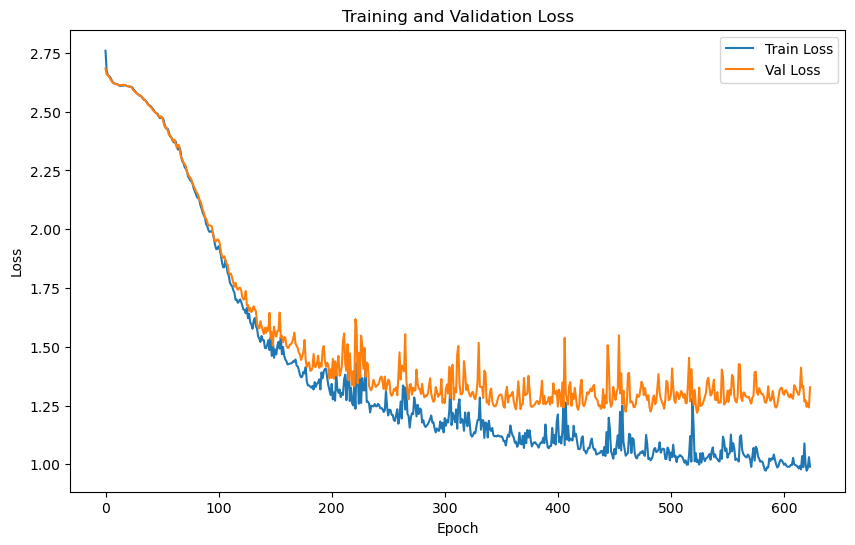

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 1.5069 | Test Accuracy: 35.94%


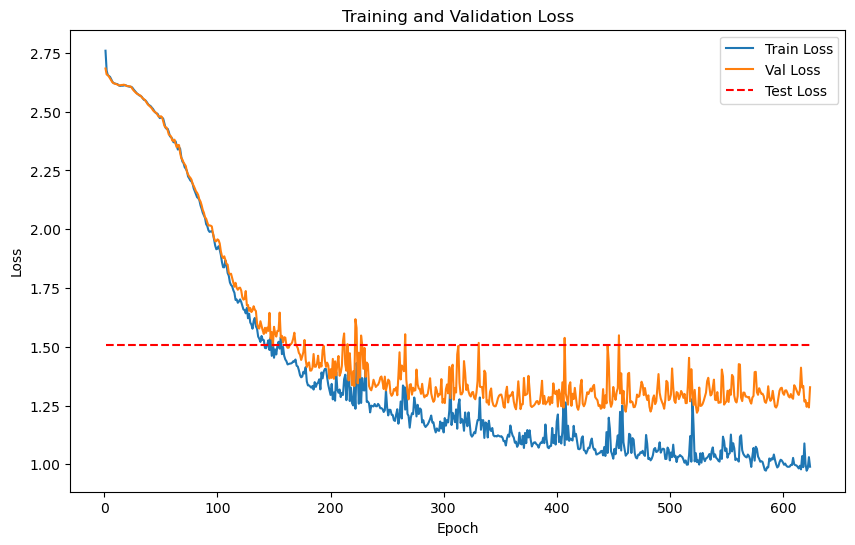

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 3108 samples with 64 features each
LOG: Labels shape: (3108,)


Train embeddings shape: (70, 64), 
Train labels shape: (70,)


Val embeddings shape: (70, 64), 
Val labels shape: (70,)


Test embeddings shape: (3108, 64), 
Test labels shape: (3108,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5}
Training batch size: 70


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 7.3560
Epoch [1/2000], Avg Train Loss: 7.3560
Epoch [1/2000], Avg Val Loss: 3.6747
Validation loss improved from inf to 3.6747. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/1], Train Loss: 8.0269
Epoch [2/2000], Avg Train Loss: 8.0269
Epoch [2/2000], Avg Val Loss: 3.6613
Validation loss improved from 3.6747 to 3.6613. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/1], Train Loss: 7.6803
Epoch [3/2000], Avg Train Loss: 7.6803
Epoch [3/2000], Avg Val Loss: 3.6491
Validation loss improved from 3.6613 to 3.6491. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/1], Train Loss: 7.3140
Epoch [4/2000], Avg Train Loss: 7.3140
Epoch [4/2000], Avg Val Loss: 3.6375
Validation loss improved from 3.6491 to 3.6375. Saving model...

LOG: Epoch [5/2000] - Training
    Batch [1/1], Train Loss: 7.6909
Epoch [5/2000], Avg Train Loss: 7.6909
Epoch [5/2000], Avg Val Loss: 3.6265
Validation loss improved from 3.6375 to 3.6265. Saving mode

    Batch [1/1], Train Loss: 6.2446
Epoch [20/2000], Avg Train Loss: 6.2446
Epoch [20/2000], Avg Val Loss: 3.5133
Validation loss improved from 3.5182 to 3.5133. Saving model...

LOG: Epoch [21/2000] - Training
    Batch [1/1], Train Loss: 5.9921
Epoch [21/2000], Avg Train Loss: 5.9921
Epoch [21/2000], Avg Val Loss: 3.5086
Validation loss improved from 3.5133 to 3.5086. Saving model...

LOG: Epoch [22/2000] - Training
    Batch [1/1], Train Loss: 6.2563
Epoch [22/2000], Avg Train Loss: 6.2563
Epoch [22/2000], Avg Val Loss: 3.5041
Validation loss improved from 3.5086 to 3.5041. Saving model...

LOG: Epoch [23/2000] - Training
    Batch [1/1], Train Loss: 6.2428
Epoch [23/2000], Avg Train Loss: 6.2428
Epoch [23/2000], Avg Val Loss: 3.4998
Validation loss improved from 3.5041 to 3.4998. Saving model...

LOG: Epoch [24/2000] - Training
    Batch [1/1], Train Loss: 6.2470
Epoch [24/2000], Avg Train Loss: 6.2470
Epoch [24/2000], Avg Val Loss: 3.4958
Validation loss improved from 3.4998 to 3.

    Batch [1/1], Train Loss: 5.3307
Epoch [36/2000], Avg Train Loss: 5.3307
Epoch [36/2000], Avg Val Loss: 3.4630
Validation loss improved from 3.4648 to 3.4630. Saving model...

LOG: Epoch [37/2000] - Training
    Batch [1/1], Train Loss: 5.6485
Epoch [37/2000], Avg Train Loss: 5.6485
Epoch [37/2000], Avg Val Loss: 3.4613
Validation loss improved from 3.4630 to 3.4613. Saving model...

LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 5.3404
Epoch [38/2000], Avg Train Loss: 5.3404
Epoch [38/2000], Avg Val Loss: 3.4597
Validation loss improved from 3.4613 to 3.4597. Saving model...

LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 5.4590
Epoch [39/2000], Avg Train Loss: 5.4590
Epoch [39/2000], Avg Val Loss: 3.4582
Validation loss improved from 3.4597 to 3.4582. Saving model...

LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 5.2853
Epoch [40/2000], Avg Train Loss: 5.2853
Epoch [40/2000], Avg Val Loss: 3.4568
Validation loss improved from 3.4582 to 3.

    Batch [1/1], Train Loss: 4.8453
Epoch [53/2000], Avg Train Loss: 4.8453
Epoch [53/2000], Avg Val Loss: 3.4455
Validation loss improved from 3.4460 to 3.4455. Saving model...

LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 4.8115
Epoch [54/2000], Avg Train Loss: 4.8115
Epoch [54/2000], Avg Val Loss: 3.4450
Validation loss improved from 3.4455 to 3.4450. Saving model...

LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 4.7409
Epoch [55/2000], Avg Train Loss: 4.7409
Epoch [55/2000], Avg Val Loss: 3.4446
Validation loss improved from 3.4450 to 3.4446. Saving model...

LOG: Epoch [56/2000] - Training
    Batch [1/1], Train Loss: 4.9960
Epoch [56/2000], Avg Train Loss: 4.9960
Epoch [56/2000], Avg Val Loss: 3.4443
Validation loss improved from 3.4446 to 3.4443. Saving model...

LOG: Epoch [57/2000] - Training
    Batch [1/1], Train Loss: 4.6025
Epoch [57/2000], Avg Train Loss: 4.6025
Epoch [57/2000], Avg Val Loss: 3.4440
Validation loss improved from 3.4443 to 3.

    Batch [1/1], Train Loss: 4.6163
Epoch [70/2000], Avg Train Loss: 4.6163
Epoch [70/2000], Avg Val Loss: 3.4425
Validation loss did not improve. Patience: 3/100

LOG: Epoch [71/2000] - Training
    Batch [1/1], Train Loss: 4.5820
Epoch [71/2000], Avg Train Loss: 4.5820
Epoch [71/2000], Avg Val Loss: 3.4426
Validation loss did not improve. Patience: 4/100

LOG: Epoch [72/2000] - Training
    Batch [1/1], Train Loss: 4.4899
Epoch [72/2000], Avg Train Loss: 4.4899
Epoch [72/2000], Avg Val Loss: 3.4426
Validation loss did not improve. Patience: 5/100

LOG: Epoch [73/2000] - Training
    Batch [1/1], Train Loss: 4.5618
Epoch [73/2000], Avg Train Loss: 4.5618
Epoch [73/2000], Avg Val Loss: 3.4428
Validation loss did not improve. Patience: 6/100

LOG: Epoch [74/2000] - Training
    Batch [1/1], Train Loss: 4.3978
Epoch [74/2000], Avg Train Loss: 4.3978
Epoch [74/2000], Avg Val Loss: 3.4429
Validation loss did not improve. Patience: 7/100

LOG: Epoch [75/2000] - Training
    Batch [1/1], Tra

Epoch [84/2000], Avg Val Loss: 3.4434
Validation loss did not improve. Patience: 17/100

LOG: Epoch [85/2000] - Training
    Batch [1/1], Train Loss: 4.3452
Epoch [85/2000], Avg Train Loss: 4.3452
Epoch [85/2000], Avg Val Loss: 3.4434
Validation loss did not improve. Patience: 18/100

LOG: Epoch [86/2000] - Training
    Batch [1/1], Train Loss: 4.2487
Epoch [86/2000], Avg Train Loss: 4.2487
Epoch [86/2000], Avg Val Loss: 3.4435
Validation loss did not improve. Patience: 19/100

LOG: Epoch [87/2000] - Training
    Batch [1/1], Train Loss: 4.3681
Epoch [87/2000], Avg Train Loss: 4.3681
Epoch [87/2000], Avg Val Loss: 3.4435
Validation loss did not improve. Patience: 20/100

LOG: Epoch [88/2000] - Training
    Batch [1/1], Train Loss: 4.2747
Epoch [88/2000], Avg Train Loss: 4.2747
Epoch [88/2000], Avg Val Loss: 3.4435
Validation loss did not improve. Patience: 21/100

LOG: Epoch [89/2000] - Training
    Batch [1/1], Train Loss: 4.3592
Epoch [89/2000], Avg Train Loss: 4.3592
Epoch [89/2000]

Epoch [99/2000], Avg Val Loss: 3.4446
Validation loss did not improve. Patience: 32/100

LOG: Epoch [100/2000] - Training
    Batch [1/1], Train Loss: 4.2085
Epoch [100/2000], Avg Train Loss: 4.2085
Epoch [100/2000], Avg Val Loss: 3.4448
Validation loss did not improve. Patience: 33/100

LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 4.0506
Epoch [101/2000], Avg Train Loss: 4.0506
Epoch [101/2000], Avg Val Loss: 3.4449
Validation loss did not improve. Patience: 34/100

LOG: Epoch [102/2000] - Training
    Batch [1/1], Train Loss: 4.1591
Epoch [102/2000], Avg Train Loss: 4.1591
Epoch [102/2000], Avg Val Loss: 3.4450
Validation loss did not improve. Patience: 35/100

LOG: Epoch [103/2000] - Training
    Batch [1/1], Train Loss: 4.0617
Epoch [103/2000], Avg Train Loss: 4.0617
Epoch [103/2000], Avg Val Loss: 3.4450
Validation loss did not improve. Patience: 36/100

LOG: Epoch [104/2000] - Training
    Batch [1/1], Train Loss: 3.9865
Epoch [104/2000], Avg Train Loss: 3.9865
E

Epoch [116/2000], Avg Val Loss: 3.4449
Validation loss did not improve. Patience: 49/100

LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 4.0983
Epoch [117/2000], Avg Train Loss: 4.0983
Epoch [117/2000], Avg Val Loss: 3.4448
Validation loss did not improve. Patience: 50/100

LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 4.0116
Epoch [118/2000], Avg Train Loss: 4.0116
Epoch [118/2000], Avg Val Loss: 3.4447
Validation loss did not improve. Patience: 51/100

LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 4.0549
Epoch [119/2000], Avg Train Loss: 4.0549
Epoch [119/2000], Avg Val Loss: 3.4447
Validation loss did not improve. Patience: 52/100

LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 4.0302
Epoch [120/2000], Avg Train Loss: 4.0302
Epoch [120/2000], Avg Val Loss: 3.4447
Validation loss did not improve. Patience: 53/100

LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 3.9939
Epoch [121/2000], Avg Train Loss: 3.9939


    Batch [1/1], Train Loss: 3.9684
Epoch [130/2000], Avg Train Loss: 3.9684
Epoch [130/2000], Avg Val Loss: 3.4438
Validation loss did not improve. Patience: 63/100

LOG: Epoch [131/2000] - Training
    Batch [1/1], Train Loss: 3.7141
Epoch [131/2000], Avg Train Loss: 3.7141
Epoch [131/2000], Avg Val Loss: 3.4438
Validation loss did not improve. Patience: 64/100

LOG: Epoch [132/2000] - Training
    Batch [1/1], Train Loss: 3.8693
Epoch [132/2000], Avg Train Loss: 3.8693
Epoch [132/2000], Avg Val Loss: 3.4437
Validation loss did not improve. Patience: 65/100

LOG: Epoch [133/2000] - Training
    Batch [1/1], Train Loss: 3.9742
Epoch [133/2000], Avg Train Loss: 3.9742
Epoch [133/2000], Avg Val Loss: 3.4435
Validation loss did not improve. Patience: 66/100

LOG: Epoch [134/2000] - Training
    Batch [1/1], Train Loss: 3.9219
Epoch [134/2000], Avg Train Loss: 3.9219
Epoch [134/2000], Avg Val Loss: 3.4434
Validation loss did not improve. Patience: 67/100

LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 3.8191
Epoch [147/2000], Avg Train Loss: 3.8191
Epoch [147/2000], Avg Val Loss: 3.4408
Validation loss improved from 3.4410 to 3.4408. Saving model...

LOG: Epoch [148/2000] - Training
    Batch [1/1], Train Loss: 3.9781
Epoch [148/2000], Avg Train Loss: 3.9781
Epoch [148/2000], Avg Val Loss: 3.4406
Validation loss improved from 3.4408 to 3.4406. Saving model...

LOG: Epoch [149/2000] - Training
    Batch [1/1], Train Loss: 3.8536
Epoch [149/2000], Avg Train Loss: 3.8536
Epoch [149/2000], Avg Val Loss: 3.4403
Validation loss improved from 3.4406 to 3.4403. Saving model...

LOG: Epoch [150/2000] - Training
    Batch [1/1], Train Loss: 3.6831
Epoch [150/2000], Avg Train Loss: 3.6831
Epoch [150/2000], Avg Val Loss: 3.4401
Validation loss improved from 3.4403 to 3.4401. Saving model...

LOG: Epoch [151/2000] - Training
    Batch [1/1], Train Loss: 3.7168
Epoch [151/2000], Avg Train Loss: 3.7168
Epoch [151/2000], Avg Val Loss: 3.4398
Validation loss improved fro

    Batch [1/1], Train Loss: 3.7817
Epoch [167/2000], Avg Train Loss: 3.7817
Epoch [167/2000], Avg Val Loss: 3.4343
Validation loss improved from 3.4346 to 3.4343. Saving model...

LOG: Epoch [168/2000] - Training
    Batch [1/1], Train Loss: 3.8214
Epoch [168/2000], Avg Train Loss: 3.8214
Epoch [168/2000], Avg Val Loss: 3.4339
Validation loss improved from 3.4343 to 3.4339. Saving model...

LOG: Epoch [169/2000] - Training
    Batch [1/1], Train Loss: 3.7280
Epoch [169/2000], Avg Train Loss: 3.7280
Epoch [169/2000], Avg Val Loss: 3.4336
Validation loss improved from 3.4339 to 3.4336. Saving model...

LOG: Epoch [170/2000] - Training
    Batch [1/1], Train Loss: 3.7549
Epoch [170/2000], Avg Train Loss: 3.7549
Epoch [170/2000], Avg Val Loss: 3.4333
Validation loss improved from 3.4336 to 3.4333. Saving model...

LOG: Epoch [171/2000] - Training
    Batch [1/1], Train Loss: 3.7787
Epoch [171/2000], Avg Train Loss: 3.7787
Epoch [171/2000], Avg Val Loss: 3.4329
Validation loss improved fro

Epoch [180/2000], Avg Val Loss: 3.4291
Validation loss improved from 3.4295 to 3.4291. Saving model...

LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 3.7117
Epoch [181/2000], Avg Train Loss: 3.7117
Epoch [181/2000], Avg Val Loss: 3.4287
Validation loss improved from 3.4291 to 3.4287. Saving model...

LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 3.6828
Epoch [182/2000], Avg Train Loss: 3.6828
Epoch [182/2000], Avg Val Loss: 3.4282
Validation loss improved from 3.4287 to 3.4282. Saving model...

LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 3.6211
Epoch [183/2000], Avg Train Loss: 3.6211
Epoch [183/2000], Avg Val Loss: 3.4278
Validation loss improved from 3.4282 to 3.4278. Saving model...

LOG: Epoch [184/2000] - Training
    Batch [1/1], Train Loss: 3.7376
Epoch [184/2000], Avg Train Loss: 3.7376
Epoch [184/2000], Avg Val Loss: 3.4273
Validation loss improved from 3.4278 to 3.4273. Saving model...

LOG: Epoch [185/2000] - Training
    Bat

Epoch [193/2000], Avg Val Loss: 3.4233
Validation loss improved from 3.4238 to 3.4233. Saving model...

LOG: Epoch [194/2000] - Training
    Batch [1/1], Train Loss: 3.6643
Epoch [194/2000], Avg Train Loss: 3.6643
Epoch [194/2000], Avg Val Loss: 3.4227
Validation loss improved from 3.4233 to 3.4227. Saving model...

LOG: Epoch [195/2000] - Training
    Batch [1/1], Train Loss: 3.7426
Epoch [195/2000], Avg Train Loss: 3.7426
Epoch [195/2000], Avg Val Loss: 3.4222
Validation loss improved from 3.4227 to 3.4222. Saving model...

LOG: Epoch [196/2000] - Training
    Batch [1/1], Train Loss: 3.7012
Epoch [196/2000], Avg Train Loss: 3.7012
Epoch [196/2000], Avg Val Loss: 3.4217
Validation loss improved from 3.4222 to 3.4217. Saving model...

LOG: Epoch [197/2000] - Training
    Batch [1/1], Train Loss: 3.5966
Epoch [197/2000], Avg Train Loss: 3.5966
Epoch [197/2000], Avg Val Loss: 3.4212
Validation loss improved from 3.4217 to 3.4212. Saving model...

LOG: Epoch [198/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.5447
Epoch [212/2000], Avg Train Loss: 3.5447
Epoch [212/2000], Avg Val Loss: 3.4135
Validation loss improved from 3.4141 to 3.4135. Saving model...

LOG: Epoch [213/2000] - Training
    Batch [1/1], Train Loss: 3.5408
Epoch [213/2000], Avg Train Loss: 3.5408
Epoch [213/2000], Avg Val Loss: 3.4129
Validation loss improved from 3.4135 to 3.4129. Saving model...

LOG: Epoch [214/2000] - Training
    Batch [1/1], Train Loss: 3.5737
Epoch [214/2000], Avg Train Loss: 3.5737
Epoch [214/2000], Avg Val Loss: 3.4123
Validation loss improved from 3.4129 to 3.4123. Saving model...

LOG: Epoch [215/2000] - Training
    Batch [1/1], Train Loss: 3.5916
Epoch [215/2000], Avg Train Loss: 3.5916
Epoch [215/2000], Avg Val Loss: 3.4117
Validation loss improved from 3.4123 to 3.4117. Saving model...

LOG: Epoch [216/2000] - Training
    Batch [1/1], Train Loss: 3.6458
Epoch [216/2000], Avg Train Loss: 3.6458
Epoch [216/2000], Avg Val Loss: 3.4112
Validation loss improved fro

    Batch [1/1], Train Loss: 3.6317
Epoch [227/2000], Avg Train Loss: 3.6317
Epoch [227/2000], Avg Val Loss: 3.4049
Validation loss improved from 3.4055 to 3.4049. Saving model...

LOG: Epoch [228/2000] - Training
    Batch [1/1], Train Loss: 3.5150
Epoch [228/2000], Avg Train Loss: 3.5150
Epoch [228/2000], Avg Val Loss: 3.4044
Validation loss improved from 3.4049 to 3.4044. Saving model...

LOG: Epoch [229/2000] - Training
    Batch [1/1], Train Loss: 3.6326
Epoch [229/2000], Avg Train Loss: 3.6326
Epoch [229/2000], Avg Val Loss: 3.4038
Validation loss improved from 3.4044 to 3.4038. Saving model...

LOG: Epoch [230/2000] - Training
    Batch [1/1], Train Loss: 3.5651
Epoch [230/2000], Avg Train Loss: 3.5651
Epoch [230/2000], Avg Val Loss: 3.4032
Validation loss improved from 3.4038 to 3.4032. Saving model...

LOG: Epoch [231/2000] - Training
    Batch [1/1], Train Loss: 3.4783
Epoch [231/2000], Avg Train Loss: 3.4783
Epoch [231/2000], Avg Val Loss: 3.4025
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4651
Epoch [238/2000], Avg Train Loss: 3.4651
Epoch [238/2000], Avg Val Loss: 3.3975
Validation loss improved from 3.3983 to 3.3975. Saving model...

LOG: Epoch [239/2000] - Training
    Batch [1/1], Train Loss: 3.5497
Epoch [239/2000], Avg Train Loss: 3.5497
Epoch [239/2000], Avg Val Loss: 3.3967
Validation loss improved from 3.3975 to 3.3967. Saving model...

LOG: Epoch [240/2000] - Training
    Batch [1/1], Train Loss: 3.5666
Epoch [240/2000], Avg Train Loss: 3.5666
Epoch [240/2000], Avg Val Loss: 3.3959
Validation loss improved from 3.3967 to 3.3959. Saving model...

LOG: Epoch [241/2000] - Training
    Batch [1/1], Train Loss: 3.5430
Epoch [241/2000], Avg Train Loss: 3.5430
Epoch [241/2000], Avg Val Loss: 3.3951
Validation loss improved from 3.3959 to 3.3951. Saving model...

LOG: Epoch [242/2000] - Training
    Batch [1/1], Train Loss: 3.5540
Epoch [242/2000], Avg Train Loss: 3.5540
Epoch [242/2000], Avg Val Loss: 3.3943
Validation loss improved fro

    Batch [1/1], Train Loss: 3.5410
Epoch [251/2000], Avg Train Loss: 3.5410
Epoch [251/2000], Avg Val Loss: 3.3879
Validation loss improved from 3.3886 to 3.3879. Saving model...

LOG: Epoch [252/2000] - Training
    Batch [1/1], Train Loss: 3.5914
Epoch [252/2000], Avg Train Loss: 3.5914
Epoch [252/2000], Avg Val Loss: 3.3873
Validation loss improved from 3.3879 to 3.3873. Saving model...

LOG: Epoch [253/2000] - Training
    Batch [1/1], Train Loss: 3.5125
Epoch [253/2000], Avg Train Loss: 3.5125
Epoch [253/2000], Avg Val Loss: 3.3867
Validation loss improved from 3.3873 to 3.3867. Saving model...

LOG: Epoch [254/2000] - Training
    Batch [1/1], Train Loss: 3.5254
Epoch [254/2000], Avg Train Loss: 3.5254
Epoch [254/2000], Avg Val Loss: 3.3861
Validation loss improved from 3.3867 to 3.3861. Saving model...

LOG: Epoch [255/2000] - Training
    Batch [1/1], Train Loss: 3.5263
Epoch [255/2000], Avg Train Loss: 3.5263
Epoch [255/2000], Avg Val Loss: 3.3854
Validation loss improved fro

    Batch [1/1], Train Loss: 3.5472
Epoch [268/2000], Avg Train Loss: 3.5472
Epoch [268/2000], Avg Val Loss: 3.3768
Validation loss improved from 3.3775 to 3.3768. Saving model...

LOG: Epoch [269/2000] - Training
    Batch [1/1], Train Loss: 3.4693
Epoch [269/2000], Avg Train Loss: 3.4693
Epoch [269/2000], Avg Val Loss: 3.3760
Validation loss improved from 3.3768 to 3.3760. Saving model...

LOG: Epoch [270/2000] - Training
    Batch [1/1], Train Loss: 3.4914
Epoch [270/2000], Avg Train Loss: 3.4914
Epoch [270/2000], Avg Val Loss: 3.3753
Validation loss improved from 3.3760 to 3.3753. Saving model...

LOG: Epoch [271/2000] - Training
    Batch [1/1], Train Loss: 3.4568
Epoch [271/2000], Avg Train Loss: 3.4568
Epoch [271/2000], Avg Val Loss: 3.3746
Validation loss improved from 3.3753 to 3.3746. Saving model...

LOG: Epoch [272/2000] - Training
    Batch [1/1], Train Loss: 3.5411
Epoch [272/2000], Avg Train Loss: 3.5411
Epoch [272/2000], Avg Val Loss: 3.3739
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4643
Epoch [285/2000], Avg Train Loss: 3.4643
Epoch [285/2000], Avg Val Loss: 3.3647
Validation loss improved from 3.3654 to 3.3647. Saving model...

LOG: Epoch [286/2000] - Training
    Batch [1/1], Train Loss: 3.5462
Epoch [286/2000], Avg Train Loss: 3.5462
Epoch [286/2000], Avg Val Loss: 3.3639
Validation loss improved from 3.3647 to 3.3639. Saving model...

LOG: Epoch [287/2000] - Training
    Batch [1/1], Train Loss: 3.4122
Epoch [287/2000], Avg Train Loss: 3.4122
Epoch [287/2000], Avg Val Loss: 3.3631
Validation loss improved from 3.3639 to 3.3631. Saving model...

LOG: Epoch [288/2000] - Training
    Batch [1/1], Train Loss: 3.4409
Epoch [288/2000], Avg Train Loss: 3.4409
Epoch [288/2000], Avg Val Loss: 3.3622
Validation loss improved from 3.3631 to 3.3622. Saving model...

LOG: Epoch [289/2000] - Training
    Batch [1/1], Train Loss: 3.5204
Epoch [289/2000], Avg Train Loss: 3.5204
Epoch [289/2000], Avg Val Loss: 3.3614
Validation loss improved fro

Epoch [296/2000], Avg Val Loss: 3.3557
Validation loss improved from 3.3565 to 3.3557. Saving model...

LOG: Epoch [297/2000] - Training
    Batch [1/1], Train Loss: 3.4522
Epoch [297/2000], Avg Train Loss: 3.4522
Epoch [297/2000], Avg Val Loss: 3.3549
Validation loss improved from 3.3557 to 3.3549. Saving model...

LOG: Epoch [298/2000] - Training
    Batch [1/1], Train Loss: 3.4768
Epoch [298/2000], Avg Train Loss: 3.4768
Epoch [298/2000], Avg Val Loss: 3.3541
Validation loss improved from 3.3549 to 3.3541. Saving model...

LOG: Epoch [299/2000] - Training
    Batch [1/1], Train Loss: 3.4531
Epoch [299/2000], Avg Train Loss: 3.4531
Epoch [299/2000], Avg Val Loss: 3.3533
Validation loss improved from 3.3541 to 3.3533. Saving model...

LOG: Epoch [300/2000] - Training
    Batch [1/1], Train Loss: 3.4239
Epoch [300/2000], Avg Train Loss: 3.4239
Epoch [300/2000], Avg Val Loss: 3.3525
Validation loss improved from 3.3533 to 3.3525. Saving model...

LOG: Epoch [301/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.4179
Epoch [308/2000], Avg Train Loss: 3.4179
Epoch [308/2000], Avg Val Loss: 3.3457
Validation loss improved from 3.3465 to 3.3457. Saving model...

LOG: Epoch [309/2000] - Training
    Batch [1/1], Train Loss: 3.3722
Epoch [309/2000], Avg Train Loss: 3.3722
Epoch [309/2000], Avg Val Loss: 3.3449
Validation loss improved from 3.3457 to 3.3449. Saving model...

LOG: Epoch [310/2000] - Training
    Batch [1/1], Train Loss: 3.3500
Epoch [310/2000], Avg Train Loss: 3.3500
Epoch [310/2000], Avg Val Loss: 3.3440
Validation loss improved from 3.3449 to 3.3440. Saving model...

LOG: Epoch [311/2000] - Training
    Batch [1/1], Train Loss: 3.4161
Epoch [311/2000], Avg Train Loss: 3.4161
Epoch [311/2000], Avg Val Loss: 3.3431
Validation loss improved from 3.3440 to 3.3431. Saving model...

LOG: Epoch [312/2000] - Training
    Batch [1/1], Train Loss: 3.4048
Epoch [312/2000], Avg Train Loss: 3.4048
Epoch [312/2000], Avg Val Loss: 3.3423
Validation loss improved fro

    Batch [1/1], Train Loss: 3.4072
Epoch [329/2000], Avg Train Loss: 3.4072
Epoch [329/2000], Avg Val Loss: 3.3278
Validation loss improved from 3.3286 to 3.3278. Saving model...

LOG: Epoch [330/2000] - Training
    Batch [1/1], Train Loss: 3.4211
Epoch [330/2000], Avg Train Loss: 3.4211
Epoch [330/2000], Avg Val Loss: 3.3271
Validation loss improved from 3.3278 to 3.3271. Saving model...

LOG: Epoch [331/2000] - Training
    Batch [1/1], Train Loss: 3.4374
Epoch [331/2000], Avg Train Loss: 3.4374
Epoch [331/2000], Avg Val Loss: 3.3263
Validation loss improved from 3.3271 to 3.3263. Saving model...

LOG: Epoch [332/2000] - Training
    Batch [1/1], Train Loss: 3.4078
Epoch [332/2000], Avg Train Loss: 3.4078
Epoch [332/2000], Avg Val Loss: 3.3256
Validation loss improved from 3.3263 to 3.3256. Saving model...

LOG: Epoch [333/2000] - Training
    Batch [1/1], Train Loss: 3.3883
Epoch [333/2000], Avg Train Loss: 3.3883
Epoch [333/2000], Avg Val Loss: 3.3248
Validation loss improved fro

Epoch [340/2000], Avg Val Loss: 3.3198
Validation loss improved from 3.3205 to 3.3198. Saving model...

LOG: Epoch [341/2000] - Training
    Batch [1/1], Train Loss: 3.4178
Epoch [341/2000], Avg Train Loss: 3.4178
Epoch [341/2000], Avg Val Loss: 3.3191
Validation loss improved from 3.3198 to 3.3191. Saving model...

LOG: Epoch [342/2000] - Training
    Batch [1/1], Train Loss: 3.3833
Epoch [342/2000], Avg Train Loss: 3.3833
Epoch [342/2000], Avg Val Loss: 3.3184
Validation loss improved from 3.3191 to 3.3184. Saving model...

LOG: Epoch [343/2000] - Training
    Batch [1/1], Train Loss: 3.3616
Epoch [343/2000], Avg Train Loss: 3.3616
Epoch [343/2000], Avg Val Loss: 3.3176
Validation loss improved from 3.3184 to 3.3176. Saving model...

LOG: Epoch [344/2000] - Training
    Batch [1/1], Train Loss: 3.3394
Epoch [344/2000], Avg Train Loss: 3.3394
Epoch [344/2000], Avg Val Loss: 3.3168
Validation loss improved from 3.3176 to 3.3168. Saving model...

LOG: Epoch [345/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.3606
Epoch [357/2000], Avg Train Loss: 3.3606
Epoch [357/2000], Avg Val Loss: 3.3075
Validation loss improved from 3.3082 to 3.3075. Saving model...

LOG: Epoch [358/2000] - Training
    Batch [1/1], Train Loss: 3.3939
Epoch [358/2000], Avg Train Loss: 3.3939
Epoch [358/2000], Avg Val Loss: 3.3068
Validation loss improved from 3.3075 to 3.3068. Saving model...

LOG: Epoch [359/2000] - Training
    Batch [1/1], Train Loss: 3.3470
Epoch [359/2000], Avg Train Loss: 3.3470
Epoch [359/2000], Avg Val Loss: 3.3061
Validation loss improved from 3.3068 to 3.3061. Saving model...

LOG: Epoch [360/2000] - Training
    Batch [1/1], Train Loss: 3.4090
Epoch [360/2000], Avg Train Loss: 3.4090
Epoch [360/2000], Avg Val Loss: 3.3054
Validation loss improved from 3.3061 to 3.3054. Saving model...

LOG: Epoch [361/2000] - Training
    Batch [1/1], Train Loss: 3.3656
Epoch [361/2000], Avg Train Loss: 3.3656
Epoch [361/2000], Avg Val Loss: 3.3047
Validation loss improved fro

Epoch [377/2000], Avg Val Loss: 3.2924
Validation loss improved from 3.2932 to 3.2924. Saving model...

LOG: Epoch [378/2000] - Training
    Batch [1/1], Train Loss: 3.2697
Epoch [378/2000], Avg Train Loss: 3.2697
Epoch [378/2000], Avg Val Loss: 3.2916
Validation loss improved from 3.2924 to 3.2916. Saving model...

LOG: Epoch [379/2000] - Training
    Batch [1/1], Train Loss: 3.3845
Epoch [379/2000], Avg Train Loss: 3.3845
Epoch [379/2000], Avg Val Loss: 3.2908
Validation loss improved from 3.2916 to 3.2908. Saving model...

LOG: Epoch [380/2000] - Training
    Batch [1/1], Train Loss: 3.3817
Epoch [380/2000], Avg Train Loss: 3.3817
Epoch [380/2000], Avg Val Loss: 3.2900
Validation loss improved from 3.2908 to 3.2900. Saving model...

LOG: Epoch [381/2000] - Training
    Batch [1/1], Train Loss: 3.3875
Epoch [381/2000], Avg Train Loss: 3.3875
Epoch [381/2000], Avg Val Loss: 3.2892
Validation loss improved from 3.2900 to 3.2892. Saving model...

LOG: Epoch [382/2000] - Training
    Bat

Epoch [384/2000], Avg Val Loss: 3.2868
Validation loss improved from 3.2876 to 3.2868. Saving model...

LOG: Epoch [385/2000] - Training
    Batch [1/1], Train Loss: 3.3327
Epoch [385/2000], Avg Train Loss: 3.3327
Epoch [385/2000], Avg Val Loss: 3.2860
Validation loss improved from 3.2868 to 3.2860. Saving model...

LOG: Epoch [386/2000] - Training
    Batch [1/1], Train Loss: 3.3694
Epoch [386/2000], Avg Train Loss: 3.3694
Epoch [386/2000], Avg Val Loss: 3.2852
Validation loss improved from 3.2860 to 3.2852. Saving model...

LOG: Epoch [387/2000] - Training
    Batch [1/1], Train Loss: 3.3358
Epoch [387/2000], Avg Train Loss: 3.3358
Epoch [387/2000], Avg Val Loss: 3.2844
Validation loss improved from 3.2852 to 3.2844. Saving model...

LOG: Epoch [388/2000] - Training
    Batch [1/1], Train Loss: 3.2920
Epoch [388/2000], Avg Train Loss: 3.2920
Epoch [388/2000], Avg Val Loss: 3.2836
Validation loss improved from 3.2844 to 3.2836. Saving model...

LOG: Epoch [389/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.3135
Epoch [405/2000], Avg Train Loss: 3.3135
Epoch [405/2000], Avg Val Loss: 3.2693
Validation loss improved from 3.2702 to 3.2693. Saving model...

LOG: Epoch [406/2000] - Training
    Batch [1/1], Train Loss: 3.2337
Epoch [406/2000], Avg Train Loss: 3.2337
Epoch [406/2000], Avg Val Loss: 3.2684
Validation loss improved from 3.2693 to 3.2684. Saving model...

LOG: Epoch [407/2000] - Training
    Batch [1/1], Train Loss: 3.3440
Epoch [407/2000], Avg Train Loss: 3.3440
Epoch [407/2000], Avg Val Loss: 3.2675
Validation loss improved from 3.2684 to 3.2675. Saving model...

LOG: Epoch [408/2000] - Training
    Batch [1/1], Train Loss: 3.3337
Epoch [408/2000], Avg Train Loss: 3.3337
Epoch [408/2000], Avg Val Loss: 3.2666
Validation loss improved from 3.2675 to 3.2666. Saving model...

LOG: Epoch [409/2000] - Training
    Batch [1/1], Train Loss: 3.3588
Epoch [409/2000], Avg Train Loss: 3.3588
Epoch [409/2000], Avg Val Loss: 3.2658
Validation loss improved fro

    Batch [1/1], Train Loss: 3.2500
Epoch [426/2000], Avg Train Loss: 3.2500
Epoch [426/2000], Avg Val Loss: 3.2521
Validation loss improved from 3.2529 to 3.2521. Saving model...

LOG: Epoch [427/2000] - Training
    Batch [1/1], Train Loss: 3.3068
Epoch [427/2000], Avg Train Loss: 3.3068
Epoch [427/2000], Avg Val Loss: 3.2514
Validation loss improved from 3.2521 to 3.2514. Saving model...

LOG: Epoch [428/2000] - Training
    Batch [1/1], Train Loss: 3.2935
Epoch [428/2000], Avg Train Loss: 3.2935
Epoch [428/2000], Avg Val Loss: 3.2506
Validation loss improved from 3.2514 to 3.2506. Saving model...

LOG: Epoch [429/2000] - Training
    Batch [1/1], Train Loss: 3.2882
Epoch [429/2000], Avg Train Loss: 3.2882
Epoch [429/2000], Avg Val Loss: 3.2498
Validation loss improved from 3.2506 to 3.2498. Saving model...

LOG: Epoch [430/2000] - Training
    Batch [1/1], Train Loss: 3.2635
Epoch [430/2000], Avg Train Loss: 3.2635
Epoch [430/2000], Avg Val Loss: 3.2491
Validation loss improved fro

Epoch [450/2000], Avg Val Loss: 3.2331
Validation loss improved from 3.2340 to 3.2331. Saving model...

LOG: Epoch [451/2000] - Training
    Batch [1/1], Train Loss: 3.2393
Epoch [451/2000], Avg Train Loss: 3.2393
Epoch [451/2000], Avg Val Loss: 3.2322
Validation loss improved from 3.2331 to 3.2322. Saving model...

LOG: Epoch [452/2000] - Training
    Batch [1/1], Train Loss: 3.2042
Epoch [452/2000], Avg Train Loss: 3.2042
Epoch [452/2000], Avg Val Loss: 3.2313
Validation loss improved from 3.2322 to 3.2313. Saving model...

LOG: Epoch [453/2000] - Training
    Batch [1/1], Train Loss: 3.2634
Epoch [453/2000], Avg Train Loss: 3.2634
Epoch [453/2000], Avg Val Loss: 3.2304
Validation loss improved from 3.2313 to 3.2304. Saving model...

LOG: Epoch [454/2000] - Training
    Batch [1/1], Train Loss: 3.2438
Epoch [454/2000], Avg Train Loss: 3.2438
Epoch [454/2000], Avg Val Loss: 3.2296
Validation loss improved from 3.2304 to 3.2296. Saving model...

LOG: Epoch [455/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.2215
Epoch [470/2000], Avg Train Loss: 3.2215
Epoch [470/2000], Avg Val Loss: 3.2156
Validation loss improved from 3.2165 to 3.2156. Saving model...

LOG: Epoch [471/2000] - Training
    Batch [1/1], Train Loss: 3.1915
Epoch [471/2000], Avg Train Loss: 3.1915
Epoch [471/2000], Avg Val Loss: 3.2147
Validation loss improved from 3.2156 to 3.2147. Saving model...

LOG: Epoch [472/2000] - Training
    Batch [1/1], Train Loss: 3.1755
Epoch [472/2000], Avg Train Loss: 3.1755
Epoch [472/2000], Avg Val Loss: 3.2139
Validation loss improved from 3.2147 to 3.2139. Saving model...

LOG: Epoch [473/2000] - Training
    Batch [1/1], Train Loss: 3.1984
Epoch [473/2000], Avg Train Loss: 3.1984
Epoch [473/2000], Avg Val Loss: 3.2131
Validation loss improved from 3.2139 to 3.2131. Saving model...

LOG: Epoch [474/2000] - Training
    Batch [1/1], Train Loss: 3.2659
Epoch [474/2000], Avg Train Loss: 3.2659
Epoch [474/2000], Avg Val Loss: 3.2124
Validation loss improved fro

Epoch [497/2000], Avg Val Loss: 3.1954
Validation loss improved from 3.1962 to 3.1954. Saving model...

LOG: Epoch [498/2000] - Training
    Batch [1/1], Train Loss: 3.1550
Epoch [498/2000], Avg Train Loss: 3.1550
Epoch [498/2000], Avg Val Loss: 3.1947
Validation loss improved from 3.1954 to 3.1947. Saving model...

LOG: Epoch [499/2000] - Training
    Batch [1/1], Train Loss: 3.1579
Epoch [499/2000], Avg Train Loss: 3.1579
Epoch [499/2000], Avg Val Loss: 3.1938
Validation loss improved from 3.1947 to 3.1938. Saving model...

LOG: Epoch [500/2000] - Training
    Batch [1/1], Train Loss: 3.1923
Epoch [500/2000], Avg Train Loss: 3.1923
Epoch [500/2000], Avg Val Loss: 3.1929
Validation loss improved from 3.1938 to 3.1929. Saving model...

LOG: Epoch [501/2000] - Training
    Batch [1/1], Train Loss: 3.2185
Epoch [501/2000], Avg Train Loss: 3.2185
Epoch [501/2000], Avg Val Loss: 3.1921
Validation loss improved from 3.1929 to 3.1921. Saving model...

LOG: Epoch [502/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.1535
Epoch [516/2000], Avg Train Loss: 3.1535
Epoch [516/2000], Avg Val Loss: 3.1809
Validation loss improved from 3.1816 to 3.1809. Saving model...

LOG: Epoch [517/2000] - Training
    Batch [1/1], Train Loss: 3.1053
Epoch [517/2000], Avg Train Loss: 3.1053
Epoch [517/2000], Avg Val Loss: 3.1801
Validation loss improved from 3.1809 to 3.1801. Saving model...

LOG: Epoch [518/2000] - Training
    Batch [1/1], Train Loss: 3.0992
Epoch [518/2000], Avg Train Loss: 3.0992
Epoch [518/2000], Avg Val Loss: 3.1793
Validation loss improved from 3.1801 to 3.1793. Saving model...

LOG: Epoch [519/2000] - Training
    Batch [1/1], Train Loss: 3.1097
Epoch [519/2000], Avg Train Loss: 3.1097
Epoch [519/2000], Avg Val Loss: 3.1785
Validation loss improved from 3.1793 to 3.1785. Saving model...

LOG: Epoch [520/2000] - Training
    Batch [1/1], Train Loss: 3.1271
Epoch [520/2000], Avg Train Loss: 3.1271
Epoch [520/2000], Avg Val Loss: 3.1777
Validation loss improved fro

Epoch [540/2000], Avg Val Loss: 3.1595
Validation loss improved from 3.1605 to 3.1595. Saving model...

LOG: Epoch [541/2000] - Training
    Batch [1/1], Train Loss: 3.1464
Epoch [541/2000], Avg Train Loss: 3.1464
Epoch [541/2000], Avg Val Loss: 3.1586
Validation loss improved from 3.1595 to 3.1586. Saving model...

LOG: Epoch [542/2000] - Training
    Batch [1/1], Train Loss: 3.0654
Epoch [542/2000], Avg Train Loss: 3.0654
Epoch [542/2000], Avg Val Loss: 3.1576
Validation loss improved from 3.1586 to 3.1576. Saving model...

LOG: Epoch [543/2000] - Training
    Batch [1/1], Train Loss: 3.1057
Epoch [543/2000], Avg Train Loss: 3.1057
Epoch [543/2000], Avg Val Loss: 3.1566
Validation loss improved from 3.1576 to 3.1566. Saving model...

LOG: Epoch [544/2000] - Training
    Batch [1/1], Train Loss: 3.1479
Epoch [544/2000], Avg Train Loss: 3.1479
Epoch [544/2000], Avg Val Loss: 3.1556
Validation loss improved from 3.1566 to 3.1556. Saving model...

LOG: Epoch [545/2000] - Training
    Bat

Epoch [560/2000], Avg Val Loss: 3.1409
Validation loss improved from 3.1416 to 3.1409. Saving model...

LOG: Epoch [561/2000] - Training
    Batch [1/1], Train Loss: 3.1013
Epoch [561/2000], Avg Train Loss: 3.1013
Epoch [561/2000], Avg Val Loss: 3.1401
Validation loss improved from 3.1409 to 3.1401. Saving model...

LOG: Epoch [562/2000] - Training
    Batch [1/1], Train Loss: 3.0741
Epoch [562/2000], Avg Train Loss: 3.0741
Epoch [562/2000], Avg Val Loss: 3.1394
Validation loss improved from 3.1401 to 3.1394. Saving model...

LOG: Epoch [563/2000] - Training
    Batch [1/1], Train Loss: 3.0236
Epoch [563/2000], Avg Train Loss: 3.0236
Epoch [563/2000], Avg Val Loss: 3.1386
Validation loss improved from 3.1394 to 3.1386. Saving model...

LOG: Epoch [564/2000] - Training
    Batch [1/1], Train Loss: 3.0963
Epoch [564/2000], Avg Train Loss: 3.0963
Epoch [564/2000], Avg Val Loss: 3.1379
Validation loss improved from 3.1386 to 3.1379. Saving model...

LOG: Epoch [565/2000] - Training
    Bat

    Batch [1/1], Train Loss: 3.0045
Epoch [587/2000], Avg Train Loss: 3.0045
Epoch [587/2000], Avg Val Loss: 3.1191
Validation loss improved from 3.1199 to 3.1191. Saving model...

LOG: Epoch [588/2000] - Training
    Batch [1/1], Train Loss: 3.0616
Epoch [588/2000], Avg Train Loss: 3.0616
Epoch [588/2000], Avg Val Loss: 3.1183
Validation loss improved from 3.1191 to 3.1183. Saving model...

LOG: Epoch [589/2000] - Training
    Batch [1/1], Train Loss: 3.0528
Epoch [589/2000], Avg Train Loss: 3.0528
Epoch [589/2000], Avg Val Loss: 3.1174
Validation loss improved from 3.1183 to 3.1174. Saving model...

LOG: Epoch [590/2000] - Training
    Batch [1/1], Train Loss: 3.0751
Epoch [590/2000], Avg Train Loss: 3.0751
Epoch [590/2000], Avg Val Loss: 3.1166
Validation loss improved from 3.1174 to 3.1166. Saving model...

LOG: Epoch [591/2000] - Training
    Batch [1/1], Train Loss: 3.0766
Epoch [591/2000], Avg Train Loss: 3.0766
Epoch [591/2000], Avg Val Loss: 3.1158
Validation loss improved fro

    Batch [1/1], Train Loss: 3.1101
Epoch [607/2000], Avg Train Loss: 3.1101
Epoch [607/2000], Avg Val Loss: 3.0994
Validation loss improved from 3.1005 to 3.0994. Saving model...

LOG: Epoch [608/2000] - Training
    Batch [1/1], Train Loss: 3.0402
Epoch [608/2000], Avg Train Loss: 3.0402
Epoch [608/2000], Avg Val Loss: 3.0984
Validation loss improved from 3.0994 to 3.0984. Saving model...

LOG: Epoch [609/2000] - Training
    Batch [1/1], Train Loss: 3.0786
Epoch [609/2000], Avg Train Loss: 3.0786
Epoch [609/2000], Avg Val Loss: 3.0974
Validation loss improved from 3.0984 to 3.0974. Saving model...

LOG: Epoch [610/2000] - Training
    Batch [1/1], Train Loss: 3.1052
Epoch [610/2000], Avg Train Loss: 3.1052
Epoch [610/2000], Avg Val Loss: 3.0965
Validation loss improved from 3.0974 to 3.0965. Saving model...

LOG: Epoch [611/2000] - Training
    Batch [1/1], Train Loss: 3.0642
Epoch [611/2000], Avg Train Loss: 3.0642
Epoch [611/2000], Avg Val Loss: 3.0956
Validation loss improved fro

    Batch [1/1], Train Loss: 3.0799
Epoch [638/2000], Avg Train Loss: 3.0799
Epoch [638/2000], Avg Val Loss: 3.0720
Validation loss improved from 3.0729 to 3.0720. Saving model...

LOG: Epoch [639/2000] - Training
    Batch [1/1], Train Loss: 2.9771
Epoch [639/2000], Avg Train Loss: 2.9771
Epoch [639/2000], Avg Val Loss: 3.0712
Validation loss improved from 3.0720 to 3.0712. Saving model...

LOG: Epoch [640/2000] - Training
    Batch [1/1], Train Loss: 2.9091
Epoch [640/2000], Avg Train Loss: 2.9091
Epoch [640/2000], Avg Val Loss: 3.0704
Validation loss improved from 3.0712 to 3.0704. Saving model...

LOG: Epoch [641/2000] - Training
    Batch [1/1], Train Loss: 3.0424
Epoch [641/2000], Avg Train Loss: 3.0424
Epoch [641/2000], Avg Val Loss: 3.0695
Validation loss improved from 3.0704 to 3.0695. Saving model...

LOG: Epoch [642/2000] - Training
    Batch [1/1], Train Loss: 2.8941
Epoch [642/2000], Avg Train Loss: 2.8941
Epoch [642/2000], Avg Val Loss: 3.0686
Validation loss improved fro

    Batch [1/1], Train Loss: 3.0008
Epoch [654/2000], Avg Train Loss: 3.0008
Epoch [654/2000], Avg Val Loss: 3.0574
Validation loss improved from 3.0583 to 3.0574. Saving model...

LOG: Epoch [655/2000] - Training
    Batch [1/1], Train Loss: 2.9887
Epoch [655/2000], Avg Train Loss: 2.9887
Epoch [655/2000], Avg Val Loss: 3.0564
Validation loss improved from 3.0574 to 3.0564. Saving model...

LOG: Epoch [656/2000] - Training
    Batch [1/1], Train Loss: 3.0323
Epoch [656/2000], Avg Train Loss: 3.0323
Epoch [656/2000], Avg Val Loss: 3.0556
Validation loss improved from 3.0564 to 3.0556. Saving model...

LOG: Epoch [657/2000] - Training
    Batch [1/1], Train Loss: 2.9767
Epoch [657/2000], Avg Train Loss: 2.9767
Epoch [657/2000], Avg Val Loss: 3.0547
Validation loss improved from 3.0556 to 3.0547. Saving model...

LOG: Epoch [658/2000] - Training
    Batch [1/1], Train Loss: 2.9186
Epoch [658/2000], Avg Train Loss: 2.9186
Epoch [658/2000], Avg Val Loss: 3.0538
Validation loss improved fro

    Batch [1/1], Train Loss: 2.8717
Epoch [687/2000], Avg Train Loss: 2.8717
Epoch [687/2000], Avg Val Loss: 3.0250
Validation loss improved from 3.0261 to 3.0250. Saving model...

LOG: Epoch [688/2000] - Training
    Batch [1/1], Train Loss: 2.8758
Epoch [688/2000], Avg Train Loss: 2.8758
Epoch [688/2000], Avg Val Loss: 3.0239
Validation loss improved from 3.0250 to 3.0239. Saving model...

LOG: Epoch [689/2000] - Training
    Batch [1/1], Train Loss: 2.9208
Epoch [689/2000], Avg Train Loss: 2.9208
Epoch [689/2000], Avg Val Loss: 3.0228
Validation loss improved from 3.0239 to 3.0228. Saving model...

LOG: Epoch [690/2000] - Training
    Batch [1/1], Train Loss: 3.0236
Epoch [690/2000], Avg Train Loss: 3.0236
Epoch [690/2000], Avg Val Loss: 3.0217
Validation loss improved from 3.0228 to 3.0217. Saving model...

LOG: Epoch [691/2000] - Training
    Batch [1/1], Train Loss: 2.9227
Epoch [691/2000], Avg Train Loss: 2.9227
Epoch [691/2000], Avg Val Loss: 3.0205
Validation loss improved fro

Epoch [703/2000], Avg Val Loss: 3.0083
Validation loss improved from 3.0091 to 3.0083. Saving model...

LOG: Epoch [704/2000] - Training
    Batch [1/1], Train Loss: 2.8994
Epoch [704/2000], Avg Train Loss: 2.8994
Epoch [704/2000], Avg Val Loss: 3.0074
Validation loss improved from 3.0083 to 3.0074. Saving model...

LOG: Epoch [705/2000] - Training
    Batch [1/1], Train Loss: 2.9230
Epoch [705/2000], Avg Train Loss: 2.9230
Epoch [705/2000], Avg Val Loss: 3.0065
Validation loss improved from 3.0074 to 3.0065. Saving model...

LOG: Epoch [706/2000] - Training
    Batch [1/1], Train Loss: 2.8808
Epoch [706/2000], Avg Train Loss: 2.8808
Epoch [706/2000], Avg Val Loss: 3.0055
Validation loss improved from 3.0065 to 3.0055. Saving model...

LOG: Epoch [707/2000] - Training
    Batch [1/1], Train Loss: 2.9110
Epoch [707/2000], Avg Train Loss: 2.9110
Epoch [707/2000], Avg Val Loss: 3.0046
Validation loss improved from 3.0055 to 3.0046. Saving model...

LOG: Epoch [708/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.8606
Epoch [731/2000], Avg Train Loss: 2.8606
Epoch [731/2000], Avg Val Loss: 2.9837
Validation loss improved from 2.9845 to 2.9837. Saving model...

LOG: Epoch [732/2000] - Training
    Batch [1/1], Train Loss: 2.8614
Epoch [732/2000], Avg Train Loss: 2.8614
Epoch [732/2000], Avg Val Loss: 2.9828
Validation loss improved from 2.9837 to 2.9828. Saving model...

LOG: Epoch [733/2000] - Training
    Batch [1/1], Train Loss: 2.9032
Epoch [733/2000], Avg Train Loss: 2.9032
Epoch [733/2000], Avg Val Loss: 2.9820
Validation loss improved from 2.9828 to 2.9820. Saving model...

LOG: Epoch [734/2000] - Training
    Batch [1/1], Train Loss: 2.9282
Epoch [734/2000], Avg Train Loss: 2.9282
Epoch [734/2000], Avg Val Loss: 2.9812
Validation loss improved from 2.9820 to 2.9812. Saving model...

LOG: Epoch [735/2000] - Training
    Batch [1/1], Train Loss: 2.9048
Epoch [735/2000], Avg Train Loss: 2.9048
Epoch [735/2000], Avg Val Loss: 2.9803
Validation loss improved fro

Epoch [748/2000], Avg Val Loss: 2.9697
Validation loss improved from 2.9706 to 2.9697. Saving model...

LOG: Epoch [749/2000] - Training
    Batch [1/1], Train Loss: 2.8616
Epoch [749/2000], Avg Train Loss: 2.8616
Epoch [749/2000], Avg Val Loss: 2.9688
Validation loss improved from 2.9697 to 2.9688. Saving model...

LOG: Epoch [750/2000] - Training
    Batch [1/1], Train Loss: 2.8570
Epoch [750/2000], Avg Train Loss: 2.8570
Epoch [750/2000], Avg Val Loss: 2.9679
Validation loss improved from 2.9688 to 2.9679. Saving model...

LOG: Epoch [751/2000] - Training
    Batch [1/1], Train Loss: 2.8541
Epoch [751/2000], Avg Train Loss: 2.8541
Epoch [751/2000], Avg Val Loss: 2.9671
Validation loss improved from 2.9679 to 2.9671. Saving model...

LOG: Epoch [752/2000] - Training
    Batch [1/1], Train Loss: 2.7872
Epoch [752/2000], Avg Train Loss: 2.7872
Epoch [752/2000], Avg Val Loss: 2.9662
Validation loss improved from 2.9671 to 2.9662. Saving model...

LOG: Epoch [753/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.8318
Epoch [775/2000], Avg Train Loss: 2.8318
Epoch [775/2000], Avg Val Loss: 2.9488
Validation loss improved from 2.9496 to 2.9488. Saving model...

LOG: Epoch [776/2000] - Training
    Batch [1/1], Train Loss: 2.7741
Epoch [776/2000], Avg Train Loss: 2.7741
Epoch [776/2000], Avg Val Loss: 2.9480
Validation loss improved from 2.9488 to 2.9480. Saving model...

LOG: Epoch [777/2000] - Training
    Batch [1/1], Train Loss: 2.7500
Epoch [777/2000], Avg Train Loss: 2.7500
Epoch [777/2000], Avg Val Loss: 2.9470
Validation loss improved from 2.9480 to 2.9470. Saving model...

LOG: Epoch [778/2000] - Training
    Batch [1/1], Train Loss: 2.7644
Epoch [778/2000], Avg Train Loss: 2.7644
Epoch [778/2000], Avg Val Loss: 2.9461
Validation loss improved from 2.9470 to 2.9461. Saving model...

LOG: Epoch [779/2000] - Training
    Batch [1/1], Train Loss: 2.8549
Epoch [779/2000], Avg Train Loss: 2.8549
Epoch [779/2000], Avg Val Loss: 2.9452
Validation loss improved fro

    Batch [1/1], Train Loss: 2.7622
Epoch [796/2000], Avg Train Loss: 2.7622
Epoch [796/2000], Avg Val Loss: 2.9259
Validation loss improved from 2.9269 to 2.9259. Saving model...

LOG: Epoch [797/2000] - Training
    Batch [1/1], Train Loss: 2.9039
Epoch [797/2000], Avg Train Loss: 2.9039
Epoch [797/2000], Avg Val Loss: 2.9250
Validation loss improved from 2.9259 to 2.9250. Saving model...

LOG: Epoch [798/2000] - Training
    Batch [1/1], Train Loss: 2.8202
Epoch [798/2000], Avg Train Loss: 2.8202
Epoch [798/2000], Avg Val Loss: 2.9240
Validation loss improved from 2.9250 to 2.9240. Saving model...

LOG: Epoch [799/2000] - Training
    Batch [1/1], Train Loss: 2.8257
Epoch [799/2000], Avg Train Loss: 2.8257
Epoch [799/2000], Avg Val Loss: 2.9230
Validation loss improved from 2.9240 to 2.9230. Saving model...

LOG: Epoch [800/2000] - Training
    Batch [1/1], Train Loss: 2.7771
Epoch [800/2000], Avg Train Loss: 2.7771
Epoch [800/2000], Avg Val Loss: 2.9219
Validation loss improved fro

    Batch [1/1], Train Loss: 2.8150
Epoch [823/2000], Avg Train Loss: 2.8150
Epoch [823/2000], Avg Val Loss: 2.9033
Validation loss improved from 2.9040 to 2.9033. Saving model...

LOG: Epoch [824/2000] - Training
    Batch [1/1], Train Loss: 2.7099
Epoch [824/2000], Avg Train Loss: 2.7099
Epoch [824/2000], Avg Val Loss: 2.9025
Validation loss improved from 2.9033 to 2.9025. Saving model...

LOG: Epoch [825/2000] - Training
    Batch [1/1], Train Loss: 2.7626
Epoch [825/2000], Avg Train Loss: 2.7626
Epoch [825/2000], Avg Val Loss: 2.9017
Validation loss improved from 2.9025 to 2.9017. Saving model...

LOG: Epoch [826/2000] - Training
    Batch [1/1], Train Loss: 2.7516
Epoch [826/2000], Avg Train Loss: 2.7516
Epoch [826/2000], Avg Val Loss: 2.9009
Validation loss improved from 2.9017 to 2.9009. Saving model...

LOG: Epoch [827/2000] - Training
    Batch [1/1], Train Loss: 2.7387
Epoch [827/2000], Avg Train Loss: 2.7387
Epoch [827/2000], Avg Val Loss: 2.9000
Validation loss improved fro

    Batch [1/1], Train Loss: 2.7564
Epoch [840/2000], Avg Train Loss: 2.7564
Epoch [840/2000], Avg Val Loss: 2.8895
Validation loss improved from 2.8903 to 2.8895. Saving model...

LOG: Epoch [841/2000] - Training
    Batch [1/1], Train Loss: 2.8270
Epoch [841/2000], Avg Train Loss: 2.8270
Epoch [841/2000], Avg Val Loss: 2.8887
Validation loss improved from 2.8895 to 2.8887. Saving model...

LOG: Epoch [842/2000] - Training
    Batch [1/1], Train Loss: 2.8059
Epoch [842/2000], Avg Train Loss: 2.8059
Epoch [842/2000], Avg Val Loss: 2.8877
Validation loss improved from 2.8887 to 2.8877. Saving model...

LOG: Epoch [843/2000] - Training
    Batch [1/1], Train Loss: 2.7226
Epoch [843/2000], Avg Train Loss: 2.7226
Epoch [843/2000], Avg Val Loss: 2.8866
Validation loss improved from 2.8877 to 2.8866. Saving model...

LOG: Epoch [844/2000] - Training
    Batch [1/1], Train Loss: 2.7515
Epoch [844/2000], Avg Train Loss: 2.7515
Epoch [844/2000], Avg Val Loss: 2.8856
Validation loss improved fro

    Batch [1/1], Train Loss: 2.6068
Epoch [871/2000], Avg Train Loss: 2.6068
Epoch [871/2000], Avg Val Loss: 2.8692
Validation loss improved from 2.8699 to 2.8692. Saving model...

LOG: Epoch [872/2000] - Training
    Batch [1/1], Train Loss: 2.7794
Epoch [872/2000], Avg Train Loss: 2.7794
Epoch [872/2000], Avg Val Loss: 2.8686
Validation loss improved from 2.8692 to 2.8686. Saving model...

LOG: Epoch [873/2000] - Training
    Batch [1/1], Train Loss: 2.7316
Epoch [873/2000], Avg Train Loss: 2.7316
Epoch [873/2000], Avg Val Loss: 2.8679
Validation loss improved from 2.8686 to 2.8679. Saving model...

LOG: Epoch [874/2000] - Training
    Batch [1/1], Train Loss: 2.6876
Epoch [874/2000], Avg Train Loss: 2.6876
Epoch [874/2000], Avg Val Loss: 2.8672
Validation loss improved from 2.8679 to 2.8672. Saving model...

LOG: Epoch [875/2000] - Training
    Batch [1/1], Train Loss: 2.6998
Epoch [875/2000], Avg Train Loss: 2.6998
Epoch [875/2000], Avg Val Loss: 2.8666
Validation loss improved fro

    Batch [1/1], Train Loss: 2.7703
Epoch [886/2000], Avg Train Loss: 2.7703
Epoch [886/2000], Avg Val Loss: 2.8581
Validation loss improved from 2.8590 to 2.8581. Saving model...

LOG: Epoch [887/2000] - Training
    Batch [1/1], Train Loss: 2.6873
Epoch [887/2000], Avg Train Loss: 2.6873
Epoch [887/2000], Avg Val Loss: 2.8573
Validation loss improved from 2.8581 to 2.8573. Saving model...

LOG: Epoch [888/2000] - Training
    Batch [1/1], Train Loss: 2.6654
Epoch [888/2000], Avg Train Loss: 2.6654
Epoch [888/2000], Avg Val Loss: 2.8566
Validation loss improved from 2.8573 to 2.8566. Saving model...

LOG: Epoch [889/2000] - Training
    Batch [1/1], Train Loss: 2.6633
Epoch [889/2000], Avg Train Loss: 2.6633
Epoch [889/2000], Avg Val Loss: 2.8559
Validation loss improved from 2.8566 to 2.8559. Saving model...

LOG: Epoch [890/2000] - Training
    Batch [1/1], Train Loss: 2.7366
Epoch [890/2000], Avg Train Loss: 2.7366
Epoch [890/2000], Avg Val Loss: 2.8553
Validation loss improved fro

    Batch [1/1], Train Loss: 2.6215
Epoch [915/2000], Avg Train Loss: 2.6215
Epoch [915/2000], Avg Val Loss: 2.8356
Validation loss improved from 2.8361 to 2.8356. Saving model...

LOG: Epoch [916/2000] - Training
    Batch [1/1], Train Loss: 2.5682
Epoch [916/2000], Avg Train Loss: 2.5682
Epoch [916/2000], Avg Val Loss: 2.8351
Validation loss improved from 2.8356 to 2.8351. Saving model...

LOG: Epoch [917/2000] - Training
    Batch [1/1], Train Loss: 2.5691
Epoch [917/2000], Avg Train Loss: 2.5691
Epoch [917/2000], Avg Val Loss: 2.8346
Validation loss improved from 2.8351 to 2.8346. Saving model...

LOG: Epoch [918/2000] - Training
    Batch [1/1], Train Loss: 2.5884
Epoch [918/2000], Avg Train Loss: 2.5884
Epoch [918/2000], Avg Val Loss: 2.8341
Validation loss improved from 2.8346 to 2.8341. Saving model...

LOG: Epoch [919/2000] - Training
    Batch [1/1], Train Loss: 2.6149
Epoch [919/2000], Avg Train Loss: 2.6149
Epoch [919/2000], Avg Val Loss: 2.8334
Validation loss improved fro

Epoch [928/2000], Avg Val Loss: 2.8280
Validation loss improved from 2.8286 to 2.8280. Saving model...

LOG: Epoch [929/2000] - Training
    Batch [1/1], Train Loss: 2.6743
Epoch [929/2000], Avg Train Loss: 2.6743
Epoch [929/2000], Avg Val Loss: 2.8273
Validation loss improved from 2.8280 to 2.8273. Saving model...

LOG: Epoch [930/2000] - Training
    Batch [1/1], Train Loss: 2.6670
Epoch [930/2000], Avg Train Loss: 2.6670
Epoch [930/2000], Avg Val Loss: 2.8266
Validation loss improved from 2.8273 to 2.8266. Saving model...

LOG: Epoch [931/2000] - Training
    Batch [1/1], Train Loss: 2.6616
Epoch [931/2000], Avg Train Loss: 2.6616
Epoch [931/2000], Avg Val Loss: 2.8260
Validation loss improved from 2.8266 to 2.8260. Saving model...

LOG: Epoch [932/2000] - Training
    Batch [1/1], Train Loss: 2.5964
Epoch [932/2000], Avg Train Loss: 2.5964
Epoch [932/2000], Avg Val Loss: 2.8254
Validation loss improved from 2.8260 to 2.8254. Saving model...

LOG: Epoch [933/2000] - Training
    Bat

    Batch [1/1], Train Loss: 2.6102
Epoch [959/2000], Avg Train Loss: 2.6102
Epoch [959/2000], Avg Val Loss: 2.8073
Validation loss improved from 2.8082 to 2.8073. Saving model...

LOG: Epoch [960/2000] - Training
    Batch [1/1], Train Loss: 2.5827
Epoch [960/2000], Avg Train Loss: 2.5827
Epoch [960/2000], Avg Val Loss: 2.8064
Validation loss improved from 2.8073 to 2.8064. Saving model...

LOG: Epoch [961/2000] - Training
    Batch [1/1], Train Loss: 2.6192
Epoch [961/2000], Avg Train Loss: 2.6192
Epoch [961/2000], Avg Val Loss: 2.8055
Validation loss improved from 2.8064 to 2.8055. Saving model...

LOG: Epoch [962/2000] - Training
    Batch [1/1], Train Loss: 2.6510
Epoch [962/2000], Avg Train Loss: 2.6510
Epoch [962/2000], Avg Val Loss: 2.8046
Validation loss improved from 2.8055 to 2.8046. Saving model...

LOG: Epoch [963/2000] - Training
    Batch [1/1], Train Loss: 2.5538
Epoch [963/2000], Avg Train Loss: 2.5538
Epoch [963/2000], Avg Val Loss: 2.8037
Validation loss improved fro

    Batch [1/1], Train Loss: 2.6095
Epoch [975/2000], Avg Train Loss: 2.6095
Epoch [975/2000], Avg Val Loss: 2.7955
Validation loss improved from 2.7960 to 2.7955. Saving model...

LOG: Epoch [976/2000] - Training
    Batch [1/1], Train Loss: 2.5066
Epoch [976/2000], Avg Train Loss: 2.5066
Epoch [976/2000], Avg Val Loss: 2.7950
Validation loss improved from 2.7955 to 2.7950. Saving model...

LOG: Epoch [977/2000] - Training
    Batch [1/1], Train Loss: 2.5456
Epoch [977/2000], Avg Train Loss: 2.5456
Epoch [977/2000], Avg Val Loss: 2.7946
Validation loss improved from 2.7950 to 2.7946. Saving model...

LOG: Epoch [978/2000] - Training
    Batch [1/1], Train Loss: 2.6735
Epoch [978/2000], Avg Train Loss: 2.6735
Epoch [978/2000], Avg Val Loss: 2.7943
Validation loss improved from 2.7946 to 2.7943. Saving model...

LOG: Epoch [979/2000] - Training
    Batch [1/1], Train Loss: 2.6544
Epoch [979/2000], Avg Train Loss: 2.6544
Epoch [979/2000], Avg Val Loss: 2.7939
Validation loss improved fro

Epoch [1005/2000], Avg Val Loss: 2.7789
Validation loss improved from 2.7793 to 2.7789. Saving model...

LOG: Epoch [1006/2000] - Training
    Batch [1/1], Train Loss: 2.5129
Epoch [1006/2000], Avg Train Loss: 2.5129
Epoch [1006/2000], Avg Val Loss: 2.7784
Validation loss improved from 2.7789 to 2.7784. Saving model...

LOG: Epoch [1007/2000] - Training
    Batch [1/1], Train Loss: 2.6046
Epoch [1007/2000], Avg Train Loss: 2.6046
Epoch [1007/2000], Avg Val Loss: 2.7777
Validation loss improved from 2.7784 to 2.7777. Saving model...

LOG: Epoch [1008/2000] - Training
    Batch [1/1], Train Loss: 2.4812
Epoch [1008/2000], Avg Train Loss: 2.4812
Epoch [1008/2000], Avg Val Loss: 2.7771
Validation loss improved from 2.7777 to 2.7771. Saving model...

LOG: Epoch [1009/2000] - Training
    Batch [1/1], Train Loss: 2.5446
Epoch [1009/2000], Avg Train Loss: 2.5446
Epoch [1009/2000], Avg Val Loss: 2.7766
Validation loss improved from 2.7771 to 2.7766. Saving model...

LOG: Epoch [1010/2000] - Tr

    Batch [1/1], Train Loss: 2.5663
Epoch [1022/2000], Avg Train Loss: 2.5663
Epoch [1022/2000], Avg Val Loss: 2.7687
Validation loss improved from 2.7690 to 2.7687. Saving model...

LOG: Epoch [1023/2000] - Training
    Batch [1/1], Train Loss: 2.5297
Epoch [1023/2000], Avg Train Loss: 2.5297
Epoch [1023/2000], Avg Val Loss: 2.7684
Validation loss improved from 2.7687 to 2.7684. Saving model...

LOG: Epoch [1024/2000] - Training
    Batch [1/1], Train Loss: 2.5119
Epoch [1024/2000], Avg Train Loss: 2.5119
Epoch [1024/2000], Avg Val Loss: 2.7680
Validation loss improved from 2.7684 to 2.7680. Saving model...

LOG: Epoch [1025/2000] - Training
    Batch [1/1], Train Loss: 2.4861
Epoch [1025/2000], Avg Train Loss: 2.4861
Epoch [1025/2000], Avg Val Loss: 2.7678
Validation loss improved from 2.7680 to 2.7678. Saving model...

LOG: Epoch [1026/2000] - Training
    Batch [1/1], Train Loss: 2.4554
Epoch [1026/2000], Avg Train Loss: 2.4554
Epoch [1026/2000], Avg Val Loss: 2.7674
Validation los

    Batch [1/1], Train Loss: 2.4563
Epoch [1053/2000], Avg Train Loss: 2.4563
Epoch [1053/2000], Avg Val Loss: 2.7612
Validation loss improved from 2.7616 to 2.7612. Saving model...

LOG: Epoch [1054/2000] - Training
    Batch [1/1], Train Loss: 2.5416
Epoch [1054/2000], Avg Train Loss: 2.5416
Epoch [1054/2000], Avg Val Loss: 2.7606
Validation loss improved from 2.7612 to 2.7606. Saving model...

LOG: Epoch [1055/2000] - Training
    Batch [1/1], Train Loss: 2.4890
Epoch [1055/2000], Avg Train Loss: 2.4890
Epoch [1055/2000], Avg Val Loss: 2.7599
Validation loss improved from 2.7606 to 2.7599. Saving model...

LOG: Epoch [1056/2000] - Training
    Batch [1/1], Train Loss: 2.5669
Epoch [1056/2000], Avg Train Loss: 2.5669
Epoch [1056/2000], Avg Val Loss: 2.7594
Validation loss improved from 2.7599 to 2.7594. Saving model...

LOG: Epoch [1057/2000] - Training
    Batch [1/1], Train Loss: 2.5156
Epoch [1057/2000], Avg Train Loss: 2.5156
Epoch [1057/2000], Avg Val Loss: 2.7589
Validation los

    Batch [1/1], Train Loss: 2.5627
Epoch [1072/2000], Avg Train Loss: 2.5627
Epoch [1072/2000], Avg Val Loss: 2.7520
Validation loss improved from 2.7525 to 2.7520. Saving model...

LOG: Epoch [1073/2000] - Training
    Batch [1/1], Train Loss: 2.4804
Epoch [1073/2000], Avg Train Loss: 2.4804
Epoch [1073/2000], Avg Val Loss: 2.7515
Validation loss improved from 2.7520 to 2.7515. Saving model...

LOG: Epoch [1074/2000] - Training
    Batch [1/1], Train Loss: 2.4459
Epoch [1074/2000], Avg Train Loss: 2.4459
Epoch [1074/2000], Avg Val Loss: 2.7508
Validation loss improved from 2.7515 to 2.7508. Saving model...

LOG: Epoch [1075/2000] - Training
    Batch [1/1], Train Loss: 2.5011
Epoch [1075/2000], Avg Train Loss: 2.5011
Epoch [1075/2000], Avg Val Loss: 2.7501
Validation loss improved from 2.7508 to 2.7501. Saving model...

LOG: Epoch [1076/2000] - Training
    Batch [1/1], Train Loss: 2.4771
Epoch [1076/2000], Avg Train Loss: 2.4771
Epoch [1076/2000], Avg Val Loss: 2.7494
Validation los

    Batch [1/1], Train Loss: 2.4466
Epoch [1097/2000], Avg Train Loss: 2.4466
Epoch [1097/2000], Avg Val Loss: 2.7457
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1098/2000] - Training
    Batch [1/1], Train Loss: 2.4572
Epoch [1098/2000], Avg Train Loss: 2.4572
Epoch [1098/2000], Avg Val Loss: 2.7458
Validation loss did not improve. Patience: 9/100

LOG: Epoch [1099/2000] - Training
    Batch [1/1], Train Loss: 2.4216
Epoch [1099/2000], Avg Train Loss: 2.4216
Epoch [1099/2000], Avg Val Loss: 2.7460
Validation loss did not improve. Patience: 10/100

LOG: Epoch [1100/2000] - Training
    Batch [1/1], Train Loss: 2.5344
Epoch [1100/2000], Avg Train Loss: 2.5344
Epoch [1100/2000], Avg Val Loss: 2.7460
Validation loss did not improve. Patience: 11/100

LOG: Epoch [1101/2000] - Training
    Batch [1/1], Train Loss: 2.4449
Epoch [1101/2000], Avg Train Loss: 2.4449
Epoch [1101/2000], Avg Val Loss: 2.7457
Validation loss did not improve. Patience: 12/100

LOG: Epoch [1102/2000

    Batch [1/1], Train Loss: 2.4737
Epoch [1116/2000], Avg Train Loss: 2.4737
Epoch [1116/2000], Avg Val Loss: 2.7423
Validation loss improved from 2.7426 to 2.7423. Saving model...

LOG: Epoch [1117/2000] - Training
    Batch [1/1], Train Loss: 2.4614
Epoch [1117/2000], Avg Train Loss: 2.4614
Epoch [1117/2000], Avg Val Loss: 2.7419
Validation loss improved from 2.7423 to 2.7419. Saving model...

LOG: Epoch [1118/2000] - Training
    Batch [1/1], Train Loss: 2.4432
Epoch [1118/2000], Avg Train Loss: 2.4432
Epoch [1118/2000], Avg Val Loss: 2.7416
Validation loss improved from 2.7419 to 2.7416. Saving model...

LOG: Epoch [1119/2000] - Training
    Batch [1/1], Train Loss: 2.4853
Epoch [1119/2000], Avg Train Loss: 2.4853
Epoch [1119/2000], Avg Val Loss: 2.7413
Validation loss improved from 2.7416 to 2.7413. Saving model...

LOG: Epoch [1120/2000] - Training
    Batch [1/1], Train Loss: 2.3994
Epoch [1120/2000], Avg Train Loss: 2.3994
Epoch [1120/2000], Avg Val Loss: 2.7411
Validation los

    Batch [1/1], Train Loss: 2.4053
Epoch [1142/2000], Avg Train Loss: 2.4053
Epoch [1142/2000], Avg Val Loss: 2.7340
Validation loss improved from 2.7343 to 2.7340. Saving model...

LOG: Epoch [1143/2000] - Training
    Batch [1/1], Train Loss: 2.3738
Epoch [1143/2000], Avg Train Loss: 2.3738
Epoch [1143/2000], Avg Val Loss: 2.7337
Validation loss improved from 2.7340 to 2.7337. Saving model...

LOG: Epoch [1144/2000] - Training
    Batch [1/1], Train Loss: 2.4472
Epoch [1144/2000], Avg Train Loss: 2.4472
Epoch [1144/2000], Avg Val Loss: 2.7335
Validation loss improved from 2.7337 to 2.7335. Saving model...

LOG: Epoch [1145/2000] - Training
    Batch [1/1], Train Loss: 2.3904
Epoch [1145/2000], Avg Train Loss: 2.3904
Epoch [1145/2000], Avg Val Loss: 2.7334
Validation loss improved from 2.7335 to 2.7334. Saving model...

LOG: Epoch [1146/2000] - Training
    Batch [1/1], Train Loss: 2.4261
Epoch [1146/2000], Avg Train Loss: 2.4261
Epoch [1146/2000], Avg Val Loss: 2.7333
Validation los

    Batch [1/1], Train Loss: 2.4259
Epoch [1164/2000], Avg Train Loss: 2.4259
Epoch [1164/2000], Avg Val Loss: 2.7326
Validation loss did not improve. Patience: 7/100

LOG: Epoch [1165/2000] - Training
    Batch [1/1], Train Loss: 2.4943
Epoch [1165/2000], Avg Train Loss: 2.4943
Epoch [1165/2000], Avg Val Loss: 2.7325
Validation loss did not improve. Patience: 8/100

LOG: Epoch [1166/2000] - Training
    Batch [1/1], Train Loss: 2.3488
Epoch [1166/2000], Avg Train Loss: 2.3488
Epoch [1166/2000], Avg Val Loss: 2.7325
Validation loss improved from 2.7325 to 2.7325. Saving model...

LOG: Epoch [1167/2000] - Training
    Batch [1/1], Train Loss: 2.4273
Epoch [1167/2000], Avg Train Loss: 2.4273
Epoch [1167/2000], Avg Val Loss: 2.7325
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1168/2000] - Training
    Batch [1/1], Train Loss: 2.3801
Epoch [1168/2000], Avg Train Loss: 2.3801
Epoch [1168/2000], Avg Val Loss: 2.7328
Validation loss did not improve. Patience: 2/100

LOG: Epoc

Epoch [1183/2000], Avg Train Loss: 2.3365
Epoch [1183/2000], Avg Val Loss: 2.7350
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1184/2000] - Training
    Batch [1/1], Train Loss: 2.3592
Epoch [1184/2000], Avg Train Loss: 2.3592
Epoch [1184/2000], Avg Val Loss: 2.7349
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1185/2000] - Training
    Batch [1/1], Train Loss: 2.3437
Epoch [1185/2000], Avg Train Loss: 2.3437
Epoch [1185/2000], Avg Val Loss: 2.7347
Validation loss did not improve. Patience: 19/100

LOG: Epoch [1186/2000] - Training
    Batch [1/1], Train Loss: 2.4657
Epoch [1186/2000], Avg Train Loss: 2.4657
Epoch [1186/2000], Avg Val Loss: 2.7346
Validation loss did not improve. Patience: 20/100

LOG: Epoch [1187/2000] - Training
    Batch [1/1], Train Loss: 2.2728
Epoch [1187/2000], Avg Train Loss: 2.2728
Epoch [1187/2000], Avg Val Loss: 2.7346
Validation loss did not improve. Patience: 21/100

LOG: Epoch [1188/2000] - Training
    Batch [1/1], Trai

Epoch [1204/2000], Avg Val Loss: 2.7304
Validation loss improved from 2.7305 to 2.7304. Saving model...

LOG: Epoch [1205/2000] - Training
    Batch [1/1], Train Loss: 2.3652
Epoch [1205/2000], Avg Train Loss: 2.3652
Epoch [1205/2000], Avg Val Loss: 2.7303
Validation loss improved from 2.7304 to 2.7303. Saving model...

LOG: Epoch [1206/2000] - Training
    Batch [1/1], Train Loss: 2.4208
Epoch [1206/2000], Avg Train Loss: 2.4208
Epoch [1206/2000], Avg Val Loss: 2.7303
Validation loss did not improve. Patience: 1/100

LOG: Epoch [1207/2000] - Training
    Batch [1/1], Train Loss: 2.3698
Epoch [1207/2000], Avg Train Loss: 2.3698
Epoch [1207/2000], Avg Val Loss: 2.7304
Validation loss did not improve. Patience: 2/100

LOG: Epoch [1208/2000] - Training
    Batch [1/1], Train Loss: 2.4321
Epoch [1208/2000], Avg Train Loss: 2.4321
Epoch [1208/2000], Avg Val Loss: 2.7309
Validation loss did not improve. Patience: 3/100

LOG: Epoch [1209/2000] - Training
    Batch [1/1], Train Loss: 2.3438
Ep

Epoch [1233/2000], Avg Val Loss: 2.7307
Validation loss did not improve. Patience: 28/100

LOG: Epoch [1234/2000] - Training
    Batch [1/1], Train Loss: 2.3144
Epoch [1234/2000], Avg Train Loss: 2.3144
Epoch [1234/2000], Avg Val Loss: 2.7306
Validation loss did not improve. Patience: 29/100

LOG: Epoch [1235/2000] - Training
    Batch [1/1], Train Loss: 2.3676
Epoch [1235/2000], Avg Train Loss: 2.3676
Epoch [1235/2000], Avg Val Loss: 2.7305
Validation loss did not improve. Patience: 30/100

LOG: Epoch [1236/2000] - Training
    Batch [1/1], Train Loss: 2.3650
Epoch [1236/2000], Avg Train Loss: 2.3650
Epoch [1236/2000], Avg Val Loss: 2.7304
Validation loss did not improve. Patience: 31/100

LOG: Epoch [1237/2000] - Training
    Batch [1/1], Train Loss: 2.2601
Epoch [1237/2000], Avg Train Loss: 2.2601
Epoch [1237/2000], Avg Val Loss: 2.7303
Validation loss did not improve. Patience: 32/100

LOG: Epoch [1238/2000] - Training
    Batch [1/1], Train Loss: 2.3779
Epoch [1238/2000], Avg Trai

    Batch [1/1], Train Loss: 2.4561
Epoch [1257/2000], Avg Train Loss: 2.4561
Epoch [1257/2000], Avg Val Loss: 2.7326
Validation loss did not improve. Patience: 52/100

LOG: Epoch [1258/2000] - Training
    Batch [1/1], Train Loss: 2.3850
Epoch [1258/2000], Avg Train Loss: 2.3850
Epoch [1258/2000], Avg Val Loss: 2.7327
Validation loss did not improve. Patience: 53/100

LOG: Epoch [1259/2000] - Training
    Batch [1/1], Train Loss: 2.3440
Epoch [1259/2000], Avg Train Loss: 2.3440
Epoch [1259/2000], Avg Val Loss: 2.7326
Validation loss did not improve. Patience: 54/100

LOG: Epoch [1260/2000] - Training
    Batch [1/1], Train Loss: 2.3289
Epoch [1260/2000], Avg Train Loss: 2.3289
Epoch [1260/2000], Avg Val Loss: 2.7323
Validation loss did not improve. Patience: 55/100

LOG: Epoch [1261/2000] - Training
    Batch [1/1], Train Loss: 2.3199
Epoch [1261/2000], Avg Train Loss: 2.3199
Epoch [1261/2000], Avg Val Loss: 2.7321
Validation loss did not improve. Patience: 56/100

LOG: Epoch [1262/20

    Batch [1/1], Train Loss: 2.2708
Epoch [1277/2000], Avg Train Loss: 2.2708
Epoch [1277/2000], Avg Val Loss: 2.7311
Validation loss did not improve. Patience: 72/100

LOG: Epoch [1278/2000] - Training
    Batch [1/1], Train Loss: 2.3401
Epoch [1278/2000], Avg Train Loss: 2.3401
Epoch [1278/2000], Avg Val Loss: 2.7310
Validation loss did not improve. Patience: 73/100

LOG: Epoch [1279/2000] - Training
    Batch [1/1], Train Loss: 2.2790
Epoch [1279/2000], Avg Train Loss: 2.2790
Epoch [1279/2000], Avg Val Loss: 2.7308
Validation loss did not improve. Patience: 74/100

LOG: Epoch [1280/2000] - Training
    Batch [1/1], Train Loss: 2.3020
Epoch [1280/2000], Avg Train Loss: 2.3020
Epoch [1280/2000], Avg Val Loss: 2.7308
Validation loss did not improve. Patience: 75/100

LOG: Epoch [1281/2000] - Training
    Batch [1/1], Train Loss: 2.2933
Epoch [1281/2000], Avg Train Loss: 2.2933
Epoch [1281/2000], Avg Val Loss: 2.7309
Validation loss did not improve. Patience: 76/100

LOG: Epoch [1282/20

Epoch [1303/2000], Avg Val Loss: 2.7269
Validation loss improved from 2.7273 to 2.7269. Saving model...

LOG: Epoch [1304/2000] - Training
    Batch [1/1], Train Loss: 2.2376
Epoch [1304/2000], Avg Train Loss: 2.2376
Epoch [1304/2000], Avg Val Loss: 2.7266
Validation loss improved from 2.7269 to 2.7266. Saving model...

LOG: Epoch [1305/2000] - Training
    Batch [1/1], Train Loss: 2.2582
Epoch [1305/2000], Avg Train Loss: 2.2582
Epoch [1305/2000], Avg Val Loss: 2.7264
Validation loss improved from 2.7266 to 2.7264. Saving model...

LOG: Epoch [1306/2000] - Training
    Batch [1/1], Train Loss: 2.2949
Epoch [1306/2000], Avg Train Loss: 2.2949
Epoch [1306/2000], Avg Val Loss: 2.7262
Validation loss improved from 2.7264 to 2.7262. Saving model...

LOG: Epoch [1307/2000] - Training
    Batch [1/1], Train Loss: 2.3176
Epoch [1307/2000], Avg Train Loss: 2.3176
Epoch [1307/2000], Avg Val Loss: 2.7261
Validation loss improved from 2.7262 to 2.7261. Saving model...

LOG: Epoch [1308/2000] - Tr

    Batch [1/1], Train Loss: 2.3055
Epoch [1321/2000], Avg Train Loss: 2.3055
Epoch [1321/2000], Avg Val Loss: 2.7265
Validation loss did not improve. Patience: 14/100

LOG: Epoch [1322/2000] - Training
    Batch [1/1], Train Loss: 2.2476
Epoch [1322/2000], Avg Train Loss: 2.2476
Epoch [1322/2000], Avg Val Loss: 2.7265
Validation loss did not improve. Patience: 15/100

LOG: Epoch [1323/2000] - Training
    Batch [1/1], Train Loss: 2.2856
Epoch [1323/2000], Avg Train Loss: 2.2856
Epoch [1323/2000], Avg Val Loss: 2.7266
Validation loss did not improve. Patience: 16/100

LOG: Epoch [1324/2000] - Training
    Batch [1/1], Train Loss: 2.2359
Epoch [1324/2000], Avg Train Loss: 2.2359
Epoch [1324/2000], Avg Val Loss: 2.7267
Validation loss did not improve. Patience: 17/100

LOG: Epoch [1325/2000] - Training
    Batch [1/1], Train Loss: 2.2675
Epoch [1325/2000], Avg Train Loss: 2.2675
Epoch [1325/2000], Avg Val Loss: 2.7270
Validation loss did not improve. Patience: 18/100

LOG: Epoch [1326/20

    Batch [1/1], Train Loss: 2.3138
Epoch [1349/2000], Avg Train Loss: 2.3138
Epoch [1349/2000], Avg Val Loss: 2.7296
Validation loss did not improve. Patience: 42/100

LOG: Epoch [1350/2000] - Training
    Batch [1/1], Train Loss: 2.2768
Epoch [1350/2000], Avg Train Loss: 2.2768
Epoch [1350/2000], Avg Val Loss: 2.7297
Validation loss did not improve. Patience: 43/100

LOG: Epoch [1351/2000] - Training
    Batch [1/1], Train Loss: 2.2949
Epoch [1351/2000], Avg Train Loss: 2.2949
Epoch [1351/2000], Avg Val Loss: 2.7297
Validation loss did not improve. Patience: 44/100

LOG: Epoch [1352/2000] - Training
    Batch [1/1], Train Loss: 2.2113
Epoch [1352/2000], Avg Train Loss: 2.2113
Epoch [1352/2000], Avg Val Loss: 2.7298
Validation loss did not improve. Patience: 45/100

LOG: Epoch [1353/2000] - Training
    Batch [1/1], Train Loss: 2.2634
Epoch [1353/2000], Avg Train Loss: 2.2634
Epoch [1353/2000], Avg Val Loss: 2.7298
Validation loss did not improve. Patience: 46/100

LOG: Epoch [1354/20

    Batch [1/1], Train Loss: 2.2702
Epoch [1370/2000], Avg Train Loss: 2.2702
Epoch [1370/2000], Avg Val Loss: 2.7328
Validation loss did not improve. Patience: 63/100

LOG: Epoch [1371/2000] - Training
    Batch [1/1], Train Loss: 2.2101
Epoch [1371/2000], Avg Train Loss: 2.2101
Epoch [1371/2000], Avg Val Loss: 2.7332
Validation loss did not improve. Patience: 64/100

LOG: Epoch [1372/2000] - Training
    Batch [1/1], Train Loss: 2.2767
Epoch [1372/2000], Avg Train Loss: 2.2767
Epoch [1372/2000], Avg Val Loss: 2.7336
Validation loss did not improve. Patience: 65/100

LOG: Epoch [1373/2000] - Training
    Batch [1/1], Train Loss: 2.3003
Epoch [1373/2000], Avg Train Loss: 2.3003
Epoch [1373/2000], Avg Val Loss: 2.7340
Validation loss did not improve. Patience: 66/100

LOG: Epoch [1374/2000] - Training
    Batch [1/1], Train Loss: 2.2252
Epoch [1374/2000], Avg Train Loss: 2.2252
Epoch [1374/2000], Avg Val Loss: 2.7344
Validation loss did not improve. Patience: 67/100

LOG: Epoch [1375/20

    Batch [1/1], Train Loss: 2.1754
Epoch [1395/2000], Avg Train Loss: 2.1754
Epoch [1395/2000], Avg Val Loss: 2.7365
Validation loss did not improve. Patience: 88/100

LOG: Epoch [1396/2000] - Training
    Batch [1/1], Train Loss: 2.2198
Epoch [1396/2000], Avg Train Loss: 2.2198
Epoch [1396/2000], Avg Val Loss: 2.7365
Validation loss did not improve. Patience: 89/100

LOG: Epoch [1397/2000] - Training
    Batch [1/1], Train Loss: 2.2111
Epoch [1397/2000], Avg Train Loss: 2.2111
Epoch [1397/2000], Avg Val Loss: 2.7367
Validation loss did not improve. Patience: 90/100

LOG: Epoch [1398/2000] - Training
    Batch [1/1], Train Loss: 2.2009
Epoch [1398/2000], Avg Train Loss: 2.2009
Epoch [1398/2000], Avg Val Loss: 2.7371
Validation loss did not improve. Patience: 91/100

LOG: Epoch [1399/2000] - Training
    Batch [1/1], Train Loss: 2.2472
Epoch [1399/2000], Avg Train Loss: 2.2472
Epoch [1399/2000], Avg Val Loss: 2.7372
Validation loss did not improve. Patience: 92/100

LOG: Epoch [1400/20

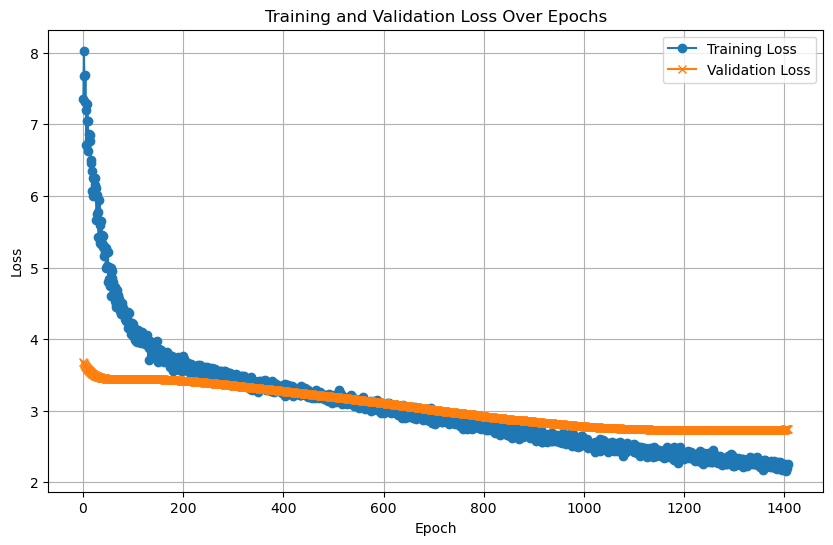

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/13], Loss: 6.1044

Test Loss: 5.3499


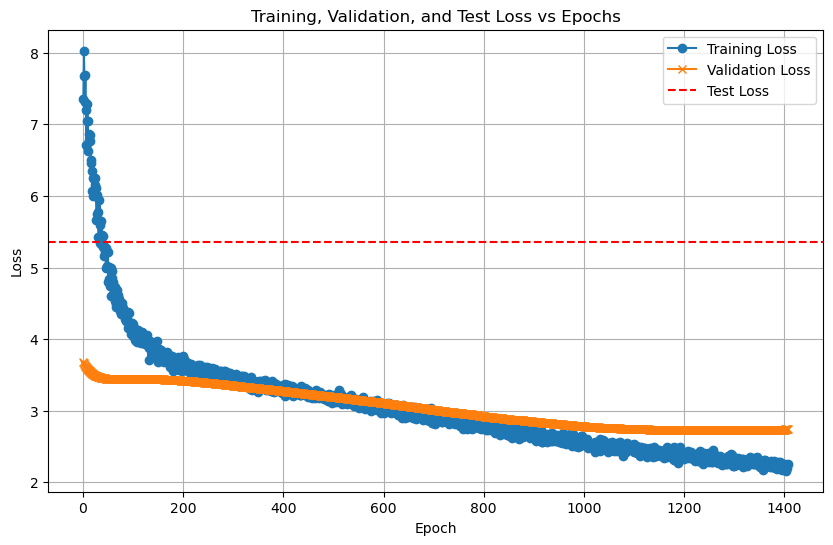

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/13 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (70, 128)
Train labels shape: (70,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (3108, 128)
Test labels shape: (3108,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 77.14%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.80      0.80      0.80         5
           2       1.00      1.00      1.00         5
           3       0.83      1.00      0.91         5
           4       0.50      0.20      0.29         5
           5       0.67      0.80      0.73         5
           6       1.00      1.00      1.00         5
           7       0.67      0.80      0.73         5
           8       0.67      0.40      0.50         5
           9       0.56      1.00      0.71         5
          10       1.00      0.40      0.57         5
          11       1.00      0.80      0.89         5
          12       0.43      0.60      0.50         5
          13       1.0

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (70, 128)
Train labels shape: (70,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (3108, 128)
Test labels shape: (3108,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6858  |  Val Loss: 2.6470
Validation loss improved from inf to 2.6470.
[Epoch 2/1000] Train Loss: 2.6703  |  Val Loss: 2.6340
Validation loss improved from 2.6470 to 2.6340.
[Epoch 3/1000] Train Loss: 2.6561  |  Val Loss: 2.6215
Validation loss improved from 2.6340 to 2.6215.
[Epoch 4/1000] Train Loss: 2.6422  |  Val Loss: 2.6094
Validation loss improved from 2.6215 to 2.6094.
[Epoch 5/1000] Train Loss: 2.6297  |  Val Loss: 2.5980
Validation loss improved from 2.6094 to 2.5980.
[Epoch 6/1000] Train Loss: 2.6166  |  Val Loss: 2.5872
Validation loss improved from 2.5980 to 2.5872.
[Epoch 7/1000] Train Loss: 2.6047  |  Val Loss: 2.5767
Validation loss improved from 2.5872 to 2.5767.
[Epoch 8/1000] Train Loss: 2.5929  |  Val Loss: 2.5665
Validation loss improved from 2.5767 to 2.5665.
[Epoch 9/1000] Train Loss: 2.5817  |  Val Loss: 2.5567
Validation loss improved from 2.5665 to 2.5567.
[Epoch 10/1000] Train Loss: 2.5708  |  Val Loss: 2.5473
Validation loss impr

[Epoch 26/1000] Train Loss: 2.4235  |  Val Loss: 2.4217
Validation loss improved from 2.4283 to 2.4217.
[Epoch 27/1000] Train Loss: 2.4162  |  Val Loss: 2.4155
Validation loss improved from 2.4217 to 2.4155.
[Epoch 28/1000] Train Loss: 2.4091  |  Val Loss: 2.4098
Validation loss improved from 2.4155 to 2.4098.
[Epoch 29/1000] Train Loss: 2.4024  |  Val Loss: 2.4044
Validation loss improved from 2.4098 to 2.4044.
[Epoch 30/1000] Train Loss: 2.3961  |  Val Loss: 2.3990
Validation loss improved from 2.4044 to 2.3990.
[Epoch 31/1000] Train Loss: 2.3900  |  Val Loss: 2.3938
Validation loss improved from 2.3990 to 2.3938.
[Epoch 32/1000] Train Loss: 2.3837  |  Val Loss: 2.3887
Validation loss improved from 2.3938 to 2.3887.
[Epoch 33/1000] Train Loss: 2.3775  |  Val Loss: 2.3835
Validation loss improved from 2.3887 to 2.3835.
[Epoch 34/1000] Train Loss: 2.3714  |  Val Loss: 2.3780
Validation loss improved from 2.3835 to 2.3780.
[Epoch 35/1000] Train Loss: 2.3653  |  Val Loss: 2.3726
Validati

[Epoch 38/1000] Train Loss: 2.3472  |  Val Loss: 2.3573
Validation loss improved from 2.3625 to 2.3573.
[Epoch 39/1000] Train Loss: 2.3415  |  Val Loss: 2.3522
Validation loss improved from 2.3573 to 2.3522.
[Epoch 40/1000] Train Loss: 2.3359  |  Val Loss: 2.3475
Validation loss improved from 2.3522 to 2.3475.
[Epoch 41/1000] Train Loss: 2.3303  |  Val Loss: 2.3429
Validation loss improved from 2.3475 to 2.3429.
[Epoch 42/1000] Train Loss: 2.3248  |  Val Loss: 2.3381
Validation loss improved from 2.3429 to 2.3381.
[Epoch 43/1000] Train Loss: 2.3197  |  Val Loss: 2.3334
Validation loss improved from 2.3381 to 2.3334.
[Epoch 44/1000] Train Loss: 2.3143  |  Val Loss: 2.3292
Validation loss improved from 2.3334 to 2.3292.
[Epoch 45/1000] Train Loss: 2.3091  |  Val Loss: 2.3251
Validation loss improved from 2.3292 to 2.3251.


[Epoch 46/1000] Train Loss: 2.3043  |  Val Loss: 2.3211
Validation loss improved from 2.3251 to 2.3211.
[Epoch 47/1000] Train Loss: 2.2995  |  Val Loss: 2.3171
Validation loss improved from 2.3211 to 2.3171.
[Epoch 48/1000] Train Loss: 2.2948  |  Val Loss: 2.3134
Validation loss improved from 2.3171 to 2.3134.
[Epoch 49/1000] Train Loss: 2.2902  |  Val Loss: 2.3100
Validation loss improved from 2.3134 to 2.3100.
[Epoch 50/1000] Train Loss: 2.2858  |  Val Loss: 2.3066
Validation loss improved from 2.3100 to 2.3066.
[Epoch 51/1000] Train Loss: 2.2816  |  Val Loss: 2.3031
Validation loss improved from 2.3066 to 2.3031.
[Epoch 52/1000] Train Loss: 2.2775  |  Val Loss: 2.2996
Validation loss improved from 2.3031 to 2.2996.
[Epoch 53/1000] Train Loss: 2.2732  |  Val Loss: 2.2962
Validation loss improved from 2.2996 to 2.2962.
[Epoch 54/1000] Train Loss: 2.2691  |  Val Loss: 2.2929
Validation loss improved from 2.2962 to 2.2929.
[Epoch 55/1000] Train Loss: 2.2649  |  Val Loss: 2.2895
Validati

[Epoch 68/1000] Train Loss: 2.2108  |  Val Loss: 2.2475
Validation loss improved from 2.2507 to 2.2475.
[Epoch 69/1000] Train Loss: 2.2066  |  Val Loss: 2.2444
Validation loss improved from 2.2475 to 2.2444.
[Epoch 70/1000] Train Loss: 2.2026  |  Val Loss: 2.2413
Validation loss improved from 2.2444 to 2.2413.
[Epoch 71/1000] Train Loss: 2.1985  |  Val Loss: 2.2381
Validation loss improved from 2.2413 to 2.2381.
[Epoch 72/1000] Train Loss: 2.1944  |  Val Loss: 2.2350
Validation loss improved from 2.2381 to 2.2350.
[Epoch 73/1000] Train Loss: 2.1903  |  Val Loss: 2.2318
Validation loss improved from 2.2350 to 2.2318.
[Epoch 74/1000] Train Loss: 2.1862  |  Val Loss: 2.2285
Validation loss improved from 2.2318 to 2.2285.
[Epoch 75/1000] Train Loss: 2.1820  |  Val Loss: 2.2252
Validation loss improved from 2.2285 to 2.2252.
[Epoch 76/1000] Train Loss: 2.1779  |  Val Loss: 2.2220
Validation loss improved from 2.2252 to 2.2220.
[Epoch 77/1000] Train Loss: 2.1736  |  Val Loss: 2.2189
Validati

[Epoch 81/1000] Train Loss: 2.1573  |  Val Loss: 2.2062
Validation loss improved from 2.2094 to 2.2062.
[Epoch 82/1000] Train Loss: 2.1529  |  Val Loss: 2.2028
Validation loss improved from 2.2062 to 2.2028.
[Epoch 83/1000] Train Loss: 2.1484  |  Val Loss: 2.1993
Validation loss improved from 2.2028 to 2.1993.
[Epoch 84/1000] Train Loss: 2.1437  |  Val Loss: 2.1956
Validation loss improved from 2.1993 to 2.1956.
[Epoch 85/1000] Train Loss: 2.1389  |  Val Loss: 2.1919
Validation loss improved from 2.1956 to 2.1919.
[Epoch 86/1000] Train Loss: 2.1341  |  Val Loss: 2.1881
Validation loss improved from 2.1919 to 2.1881.
[Epoch 87/1000] Train Loss: 2.1292  |  Val Loss: 2.1844
Validation loss improved from 2.1881 to 2.1844.
[Epoch 88/1000] Train Loss: 2.1245  |  Val Loss: 2.1808
Validation loss improved from 2.1844 to 2.1808.
[Epoch 89/1000] Train Loss: 2.1198  |  Val Loss: 2.1772
Validation loss improved from 2.1808 to 2.1772.
[Epoch 90/1000] Train Loss: 2.1150  |  Val Loss: 2.1736
Validati

[Epoch 93/1000] Train Loss: 2.1011  |  Val Loss: 2.1631
Validation loss improved from 2.1665 to 2.1631.
[Epoch 94/1000] Train Loss: 2.0969  |  Val Loss: 2.1598
Validation loss improved from 2.1631 to 2.1598.
[Epoch 95/1000] Train Loss: 2.0925  |  Val Loss: 2.1564
Validation loss improved from 2.1598 to 2.1564.
[Epoch 96/1000] Train Loss: 2.0881  |  Val Loss: 2.1532
Validation loss improved from 2.1564 to 2.1532.
[Epoch 97/1000] Train Loss: 2.0838  |  Val Loss: 2.1499
Validation loss improved from 2.1532 to 2.1499.
[Epoch 98/1000] Train Loss: 2.0796  |  Val Loss: 2.1467
Validation loss improved from 2.1499 to 2.1467.
[Epoch 99/1000] Train Loss: 2.0753  |  Val Loss: 2.1435
Validation loss improved from 2.1467 to 2.1435.
[Epoch 100/1000] Train Loss: 2.0711  |  Val Loss: 2.1403
Validation loss improved from 2.1435 to 2.1403.
[Epoch 101/1000] Train Loss: 2.0667  |  Val Loss: 2.1371
Validation loss improved from 2.1403 to 2.1371.
[Epoch 102/1000] Train Loss: 2.0623  |  Val Loss: 2.1337
Valid

[Epoch 109/1000] Train Loss: 2.0302  |  Val Loss: 2.1093
Validation loss improved from 2.1129 to 2.1093.
[Epoch 110/1000] Train Loss: 2.0256  |  Val Loss: 2.1056
Validation loss improved from 2.1093 to 2.1056.
[Epoch 111/1000] Train Loss: 2.0207  |  Val Loss: 2.1021
Validation loss improved from 2.1056 to 2.1021.
[Epoch 112/1000] Train Loss: 2.0159  |  Val Loss: 2.0986
Validation loss improved from 2.1021 to 2.0986.
[Epoch 113/1000] Train Loss: 2.0111  |  Val Loss: 2.0952
Validation loss improved from 2.0986 to 2.0952.
[Epoch 114/1000] Train Loss: 2.0065  |  Val Loss: 2.0919
Validation loss improved from 2.0952 to 2.0919.
[Epoch 115/1000] Train Loss: 2.0018  |  Val Loss: 2.0886
Validation loss improved from 2.0919 to 2.0886.
[Epoch 116/1000] Train Loss: 1.9973  |  Val Loss: 2.0853
Validation loss improved from 2.0886 to 2.0853.
[Epoch 117/1000] Train Loss: 1.9924  |  Val Loss: 2.0820
Validation loss improved from 2.0853 to 2.0820.
[Epoch 118/1000] Train Loss: 1.9877  |  Val Loss: 2.078

[Epoch 120/1000] Train Loss: 1.9780  |  Val Loss: 2.0713
Validation loss improved from 2.0749 to 2.0713.
[Epoch 121/1000] Train Loss: 1.9729  |  Val Loss: 2.0678
Validation loss improved from 2.0713 to 2.0678.
[Epoch 122/1000] Train Loss: 1.9681  |  Val Loss: 2.0641
Validation loss improved from 2.0678 to 2.0641.
[Epoch 123/1000] Train Loss: 1.9634  |  Val Loss: 2.0606
Validation loss improved from 2.0641 to 2.0606.
[Epoch 124/1000] Train Loss: 1.9585  |  Val Loss: 2.0571
Validation loss improved from 2.0606 to 2.0571.
[Epoch 125/1000] Train Loss: 1.9539  |  Val Loss: 2.0537
Validation loss improved from 2.0571 to 2.0537.
[Epoch 126/1000] Train Loss: 1.9492  |  Val Loss: 2.0506
Validation loss improved from 2.0537 to 2.0506.
[Epoch 127/1000] Train Loss: 1.9448  |  Val Loss: 2.0476
Validation loss improved from 2.0506 to 2.0476.
[Epoch 128/1000] Train Loss: 1.9407  |  Val Loss: 2.0448
Validation loss improved from 2.0476 to 2.0448.
[Epoch 129/1000] Train Loss: 1.9364  |  Val Loss: 2.042

[Epoch 133/1000] Train Loss: 1.9187  |  Val Loss: 2.0294
Validation loss improved from 2.0327 to 2.0294.
[Epoch 134/1000] Train Loss: 1.9141  |  Val Loss: 2.0261
Validation loss improved from 2.0294 to 2.0261.
[Epoch 135/1000] Train Loss: 1.9092  |  Val Loss: 2.0228
Validation loss improved from 2.0261 to 2.0228.
[Epoch 136/1000] Train Loss: 1.9044  |  Val Loss: 2.0192
Validation loss improved from 2.0228 to 2.0192.
[Epoch 137/1000] Train Loss: 1.8993  |  Val Loss: 2.0154
Validation loss improved from 2.0192 to 2.0154.
[Epoch 138/1000] Train Loss: 1.8943  |  Val Loss: 2.0113
Validation loss improved from 2.0154 to 2.0113.
[Epoch 139/1000] Train Loss: 1.8891  |  Val Loss: 2.0074
Validation loss improved from 2.0113 to 2.0074.
[Epoch 140/1000] Train Loss: 1.8838  |  Val Loss: 2.0037
Validation loss improved from 2.0074 to 2.0037.
[Epoch 141/1000] Train Loss: 1.8787  |  Val Loss: 2.0000
Validation loss improved from 2.0037 to 2.0000.
[Epoch 142/1000] Train Loss: 1.8739  |  Val Loss: 1.996

[Epoch 150/1000] Train Loss: 1.8350  |  Val Loss: 1.9670
Validation loss improved from 1.9710 to 1.9670.
[Epoch 151/1000] Train Loss: 1.8296  |  Val Loss: 1.9627
Validation loss improved from 1.9670 to 1.9627.
[Epoch 152/1000] Train Loss: 1.8242  |  Val Loss: 1.9583
Validation loss improved from 1.9627 to 1.9583.
[Epoch 153/1000] Train Loss: 1.8188  |  Val Loss: 1.9539
Validation loss improved from 1.9583 to 1.9539.
[Epoch 154/1000] Train Loss: 1.8131  |  Val Loss: 1.9496
Validation loss improved from 1.9539 to 1.9496.
[Epoch 155/1000] Train Loss: 1.8075  |  Val Loss: 1.9453
Validation loss improved from 1.9496 to 1.9453.
[Epoch 156/1000] Train Loss: 1.8022  |  Val Loss: 1.9410
Validation loss improved from 1.9453 to 1.9410.
[Epoch 157/1000] Train Loss: 1.7968  |  Val Loss: 1.9369
Validation loss improved from 1.9410 to 1.9369.
[Epoch 158/1000] Train Loss: 1.7915  |  Val Loss: 1.9329
Validation loss improved from 1.9369 to 1.9329.
[Epoch 159/1000] Train Loss: 1.7865  |  Val Loss: 1.928

[Epoch 162/1000] Train Loss: 1.7714  |  Val Loss: 1.9168
Validation loss improved from 1.9208 to 1.9168.
[Epoch 163/1000] Train Loss: 1.7663  |  Val Loss: 1.9130
Validation loss improved from 1.9168 to 1.9130.
[Epoch 164/1000] Train Loss: 1.7616  |  Val Loss: 1.9093
Validation loss improved from 1.9130 to 1.9093.
[Epoch 165/1000] Train Loss: 1.7568  |  Val Loss: 1.9057
Validation loss improved from 1.9093 to 1.9057.
[Epoch 166/1000] Train Loss: 1.7522  |  Val Loss: 1.9022
Validation loss improved from 1.9057 to 1.9022.
[Epoch 167/1000] Train Loss: 1.7474  |  Val Loss: 1.8985
Validation loss improved from 1.9022 to 1.8985.
[Epoch 168/1000] Train Loss: 1.7428  |  Val Loss: 1.8943
Validation loss improved from 1.8985 to 1.8943.
[Epoch 169/1000] Train Loss: 1.7375  |  Val Loss: 1.8900
Validation loss improved from 1.8943 to 1.8900.
[Epoch 170/1000] Train Loss: 1.7323  |  Val Loss: 1.8856
Validation loss improved from 1.8900 to 1.8856.
[Epoch 171/1000] Train Loss: 1.7268  |  Val Loss: 1.881

[Epoch 172/1000] Train Loss: 1.7219  |  Val Loss: 1.8767
Validation loss improved from 1.8812 to 1.8767.
[Epoch 173/1000] Train Loss: 1.7166  |  Val Loss: 1.8723
Validation loss improved from 1.8767 to 1.8723.
[Epoch 174/1000] Train Loss: 1.7114  |  Val Loss: 1.8680
Validation loss improved from 1.8723 to 1.8680.
[Epoch 175/1000] Train Loss: 1.7059  |  Val Loss: 1.8639
Validation loss improved from 1.8680 to 1.8639.
[Epoch 176/1000] Train Loss: 1.7005  |  Val Loss: 1.8599
Validation loss improved from 1.8639 to 1.8599.
[Epoch 177/1000] Train Loss: 1.6952  |  Val Loss: 1.8559
Validation loss improved from 1.8599 to 1.8559.
[Epoch 178/1000] Train Loss: 1.6899  |  Val Loss: 1.8520
Validation loss improved from 1.8559 to 1.8520.
[Epoch 179/1000] Train Loss: 1.6845  |  Val Loss: 1.8480
Validation loss improved from 1.8520 to 1.8480.
[Epoch 180/1000] Train Loss: 1.6789  |  Val Loss: 1.8440
Validation loss improved from 1.8480 to 1.8440.
[Epoch 181/1000] Train Loss: 1.6732  |  Val Loss: 1.839

[Epoch 191/1000] Train Loss: 1.6167  |  Val Loss: 1.7961
Validation loss improved from 1.8005 to 1.7961.
[Epoch 192/1000] Train Loss: 1.6110  |  Val Loss: 1.7916
Validation loss improved from 1.7961 to 1.7916.
[Epoch 193/1000] Train Loss: 1.6053  |  Val Loss: 1.7869
Validation loss improved from 1.7916 to 1.7869.
[Epoch 194/1000] Train Loss: 1.5999  |  Val Loss: 1.7822
Validation loss improved from 1.7869 to 1.7822.
[Epoch 195/1000] Train Loss: 1.5943  |  Val Loss: 1.7777
Validation loss improved from 1.7822 to 1.7777.
[Epoch 196/1000] Train Loss: 1.5888  |  Val Loss: 1.7731
Validation loss improved from 1.7777 to 1.7731.
[Epoch 197/1000] Train Loss: 1.5832  |  Val Loss: 1.7685
Validation loss improved from 1.7731 to 1.7685.
[Epoch 198/1000] Train Loss: 1.5774  |  Val Loss: 1.7637
Validation loss improved from 1.7685 to 1.7637.
[Epoch 199/1000] Train Loss: 1.5720  |  Val Loss: 1.7587
Validation loss improved from 1.7637 to 1.7587.
[Epoch 200/1000] Train Loss: 1.5663  |  Val Loss: 1.754

[Epoch 201/1000] Train Loss: 1.5606  |  Val Loss: 1.7496
Validation loss improved from 1.7541 to 1.7496.
[Epoch 202/1000] Train Loss: 1.5551  |  Val Loss: 1.7452
Validation loss improved from 1.7496 to 1.7452.
[Epoch 203/1000] Train Loss: 1.5499  |  Val Loss: 1.7410
Validation loss improved from 1.7452 to 1.7410.
[Epoch 204/1000] Train Loss: 1.5443  |  Val Loss: 1.7369
Validation loss improved from 1.7410 to 1.7369.
[Epoch 205/1000] Train Loss: 1.5392  |  Val Loss: 1.7331
Validation loss improved from 1.7369 to 1.7331.


[Epoch 206/1000] Train Loss: 1.5340  |  Val Loss: 1.7293
Validation loss improved from 1.7331 to 1.7293.
[Epoch 207/1000] Train Loss: 1.5290  |  Val Loss: 1.7254
Validation loss improved from 1.7293 to 1.7254.
[Epoch 208/1000] Train Loss: 1.5240  |  Val Loss: 1.7215
Validation loss improved from 1.7254 to 1.7215.
[Epoch 209/1000] Train Loss: 1.5188  |  Val Loss: 1.7176
Validation loss improved from 1.7215 to 1.7176.
[Epoch 210/1000] Train Loss: 1.5138  |  Val Loss: 1.7139
Validation loss improved from 1.7176 to 1.7139.
[Epoch 211/1000] Train Loss: 1.5090  |  Val Loss: 1.7102
Validation loss improved from 1.7139 to 1.7102.
[Epoch 212/1000] Train Loss: 1.5042  |  Val Loss: 1.7063
Validation loss improved from 1.7102 to 1.7063.
[Epoch 213/1000] Train Loss: 1.4993  |  Val Loss: 1.7023
Validation loss improved from 1.7063 to 1.7023.
[Epoch 214/1000] Train Loss: 1.4943  |  Val Loss: 1.6981
Validation loss improved from 1.7023 to 1.6981.
[Epoch 215/1000] Train Loss: 1.4894  |  Val Loss: 1.693

[Epoch 229/1000] Train Loss: 1.4224  |  Val Loss: 1.6360
Validation loss improved from 1.6401 to 1.6360.
[Epoch 230/1000] Train Loss: 1.4173  |  Val Loss: 1.6318
Validation loss improved from 1.6360 to 1.6318.
[Epoch 231/1000] Train Loss: 1.4122  |  Val Loss: 1.6277
Validation loss improved from 1.6318 to 1.6277.
[Epoch 232/1000] Train Loss: 1.4071  |  Val Loss: 1.6237
Validation loss improved from 1.6277 to 1.6237.
[Epoch 233/1000] Train Loss: 1.4022  |  Val Loss: 1.6197
Validation loss improved from 1.6237 to 1.6197.
[Epoch 234/1000] Train Loss: 1.3974  |  Val Loss: 1.6161
Validation loss improved from 1.6197 to 1.6161.
[Epoch 235/1000] Train Loss: 1.3926  |  Val Loss: 1.6128
Validation loss improved from 1.6161 to 1.6128.
[Epoch 236/1000] Train Loss: 1.3880  |  Val Loss: 1.6095
Validation loss improved from 1.6128 to 1.6095.
[Epoch 237/1000] Train Loss: 1.3833  |  Val Loss: 1.6062
Validation loss improved from 1.6095 to 1.6062.
[Epoch 238/1000] Train Loss: 1.3786  |  Val Loss: 1.602

[Epoch 240/1000] Train Loss: 1.3694  |  Val Loss: 1.5962
Validation loss improved from 1.5997 to 1.5962.
[Epoch 241/1000] Train Loss: 1.3644  |  Val Loss: 1.5927
Validation loss improved from 1.5962 to 1.5927.
[Epoch 242/1000] Train Loss: 1.3599  |  Val Loss: 1.5894
Validation loss improved from 1.5927 to 1.5894.
[Epoch 243/1000] Train Loss: 1.3553  |  Val Loss: 1.5860
Validation loss improved from 1.5894 to 1.5860.
[Epoch 244/1000] Train Loss: 1.3506  |  Val Loss: 1.5829
Validation loss improved from 1.5860 to 1.5829.
[Epoch 245/1000] Train Loss: 1.3463  |  Val Loss: 1.5800
Validation loss improved from 1.5829 to 1.5800.
[Epoch 246/1000] Train Loss: 1.3421  |  Val Loss: 1.5772
Validation loss improved from 1.5800 to 1.5772.
[Epoch 247/1000] Train Loss: 1.3380  |  Val Loss: 1.5741
Validation loss improved from 1.5772 to 1.5741.
[Epoch 248/1000] Train Loss: 1.3338  |  Val Loss: 1.5709
Validation loss improved from 1.5741 to 1.5709.


[Epoch 249/1000] Train Loss: 1.3293  |  Val Loss: 1.5678
Validation loss improved from 1.5709 to 1.5678.
[Epoch 250/1000] Train Loss: 1.3251  |  Val Loss: 1.5645
Validation loss improved from 1.5678 to 1.5645.
[Epoch 251/1000] Train Loss: 1.3205  |  Val Loss: 1.5611
Validation loss improved from 1.5645 to 1.5611.
[Epoch 252/1000] Train Loss: 1.3163  |  Val Loss: 1.5578
Validation loss improved from 1.5611 to 1.5578.
[Epoch 253/1000] Train Loss: 1.3121  |  Val Loss: 1.5540
Validation loss improved from 1.5578 to 1.5540.
[Epoch 254/1000] Train Loss: 1.3078  |  Val Loss: 1.5501
Validation loss improved from 1.5540 to 1.5501.
[Epoch 255/1000] Train Loss: 1.3035  |  Val Loss: 1.5464
Validation loss improved from 1.5501 to 1.5464.
[Epoch 256/1000] Train Loss: 1.2991  |  Val Loss: 1.5430
Validation loss improved from 1.5464 to 1.5430.
[Epoch 257/1000] Train Loss: 1.2951  |  Val Loss: 1.5396
Validation loss improved from 1.5430 to 1.5396.
[Epoch 258/1000] Train Loss: 1.2910  |  Val Loss: 1.536

[Epoch 268/1000] Train Loss: 1.2507  |  Val Loss: 1.5018
Validation loss improved from 1.5049 to 1.5018.
[Epoch 269/1000] Train Loss: 1.2469  |  Val Loss: 1.4989
Validation loss improved from 1.5018 to 1.4989.
[Epoch 270/1000] Train Loss: 1.2431  |  Val Loss: 1.4961
Validation loss improved from 1.4989 to 1.4961.
[Epoch 271/1000] Train Loss: 1.2394  |  Val Loss: 1.4931
Validation loss improved from 1.4961 to 1.4931.
[Epoch 272/1000] Train Loss: 1.2356  |  Val Loss: 1.4900
Validation loss improved from 1.4931 to 1.4900.
[Epoch 273/1000] Train Loss: 1.2318  |  Val Loss: 1.4870
Validation loss improved from 1.4900 to 1.4870.
[Epoch 274/1000] Train Loss: 1.2279  |  Val Loss: 1.4837
Validation loss improved from 1.4870 to 1.4837.
[Epoch 275/1000] Train Loss: 1.2241  |  Val Loss: 1.4805
Validation loss improved from 1.4837 to 1.4805.
[Epoch 276/1000] Train Loss: 1.2202  |  Val Loss: 1.4773
Validation loss improved from 1.4805 to 1.4773.
[Epoch 277/1000] Train Loss: 1.2167  |  Val Loss: 1.474

[Epoch 282/1000] Train Loss: 1.1995  |  Val Loss: 1.4606
Validation loss improved from 1.4631 to 1.4606.
[Epoch 283/1000] Train Loss: 1.1967  |  Val Loss: 1.4582
Validation loss improved from 1.4606 to 1.4582.
[Epoch 284/1000] Train Loss: 1.1944  |  Val Loss: 1.4558
Validation loss improved from 1.4582 to 1.4558.
[Epoch 285/1000] Train Loss: 1.1918  |  Val Loss: 1.4532
Validation loss improved from 1.4558 to 1.4532.
[Epoch 286/1000] Train Loss: 1.1889  |  Val Loss: 1.4504
Validation loss improved from 1.4532 to 1.4504.
[Epoch 287/1000] Train Loss: 1.1857  |  Val Loss: 1.4473
Validation loss improved from 1.4504 to 1.4473.


[Epoch 288/1000] Train Loss: 1.1821  |  Val Loss: 1.4440
Validation loss improved from 1.4473 to 1.4440.
[Epoch 289/1000] Train Loss: 1.1784  |  Val Loss: 1.4410
Validation loss improved from 1.4440 to 1.4410.
[Epoch 290/1000] Train Loss: 1.1748  |  Val Loss: 1.4382
Validation loss improved from 1.4410 to 1.4382.
[Epoch 291/1000] Train Loss: 1.1715  |  Val Loss: 1.4356
Validation loss improved from 1.4382 to 1.4356.
[Epoch 292/1000] Train Loss: 1.1682  |  Val Loss: 1.4331
Validation loss improved from 1.4356 to 1.4331.
[Epoch 293/1000] Train Loss: 1.1648  |  Val Loss: 1.4301
Validation loss improved from 1.4331 to 1.4301.
[Epoch 294/1000] Train Loss: 1.1614  |  Val Loss: 1.4270
Validation loss improved from 1.4301 to 1.4270.
[Epoch 295/1000] Train Loss: 1.1580  |  Val Loss: 1.4242
Validation loss improved from 1.4270 to 1.4242.
[Epoch 296/1000] Train Loss: 1.1545  |  Val Loss: 1.4216
Validation loss improved from 1.4242 to 1.4216.
[Epoch 297/1000] Train Loss: 1.1509  |  Val Loss: 1.419

[Epoch 305/1000] Train Loss: 1.1241  |  Val Loss: 1.4003
Validation loss improved from 1.4024 to 1.4003.
[Epoch 306/1000] Train Loss: 1.1210  |  Val Loss: 1.3982
Validation loss improved from 1.4003 to 1.3982.
[Epoch 307/1000] Train Loss: 1.1175  |  Val Loss: 1.3957
Validation loss improved from 1.3982 to 1.3957.
[Epoch 308/1000] Train Loss: 1.1142  |  Val Loss: 1.3930
Validation loss improved from 1.3957 to 1.3930.
[Epoch 309/1000] Train Loss: 1.1105  |  Val Loss: 1.3901
Validation loss improved from 1.3930 to 1.3901.
[Epoch 310/1000] Train Loss: 1.1071  |  Val Loss: 1.3875
Validation loss improved from 1.3901 to 1.3875.
[Epoch 311/1000] Train Loss: 1.1038  |  Val Loss: 1.3850
Validation loss improved from 1.3875 to 1.3850.
[Epoch 312/1000] Train Loss: 1.1006  |  Val Loss: 1.3826
Validation loss improved from 1.3850 to 1.3826.
[Epoch 313/1000] Train Loss: 1.0977  |  Val Loss: 1.3804
Validation loss improved from 1.3826 to 1.3804.
[Epoch 314/1000] Train Loss: 1.0948  |  Val Loss: 1.378

[Epoch 324/1000] Train Loss: 1.0637  |  Val Loss: 1.3542
Validation loss improved from 1.3568 to 1.3542.
[Epoch 325/1000] Train Loss: 1.0604  |  Val Loss: 1.3515
Validation loss improved from 1.3542 to 1.3515.
[Epoch 326/1000] Train Loss: 1.0572  |  Val Loss: 1.3487
Validation loss improved from 1.3515 to 1.3487.
[Epoch 327/1000] Train Loss: 1.0540  |  Val Loss: 1.3462
Validation loss improved from 1.3487 to 1.3462.
[Epoch 328/1000] Train Loss: 1.0510  |  Val Loss: 1.3438
Validation loss improved from 1.3462 to 1.3438.
[Epoch 329/1000] Train Loss: 1.0477  |  Val Loss: 1.3412
Validation loss improved from 1.3438 to 1.3412.
[Epoch 330/1000] Train Loss: 1.0442  |  Val Loss: 1.3387
Validation loss improved from 1.3412 to 1.3387.
[Epoch 331/1000] Train Loss: 1.0407  |  Val Loss: 1.3364
Validation loss improved from 1.3387 to 1.3364.


[Epoch 332/1000] Train Loss: 1.0374  |  Val Loss: 1.3341
Validation loss improved from 1.3364 to 1.3341.
[Epoch 333/1000] Train Loss: 1.0341  |  Val Loss: 1.3319
Validation loss improved from 1.3341 to 1.3319.
[Epoch 334/1000] Train Loss: 1.0311  |  Val Loss: 1.3297
Validation loss improved from 1.3319 to 1.3297.
[Epoch 335/1000] Train Loss: 1.0278  |  Val Loss: 1.3271
Validation loss improved from 1.3297 to 1.3271.
[Epoch 336/1000] Train Loss: 1.0244  |  Val Loss: 1.3243
Validation loss improved from 1.3271 to 1.3243.
[Epoch 337/1000] Train Loss: 1.0210  |  Val Loss: 1.3216
Validation loss improved from 1.3243 to 1.3216.
[Epoch 338/1000] Train Loss: 1.0179  |  Val Loss: 1.3193
Validation loss improved from 1.3216 to 1.3193.
[Epoch 339/1000] Train Loss: 1.0146  |  Val Loss: 1.3170
Validation loss improved from 1.3193 to 1.3170.
[Epoch 340/1000] Train Loss: 1.0115  |  Val Loss: 1.3148
Validation loss improved from 1.3170 to 1.3148.
[Epoch 341/1000] Train Loss: 1.0085  |  Val Loss: 1.312

[Epoch 347/1000] Train Loss: 0.9913  |  Val Loss: 1.3035
Validation loss improved from 1.3048 to 1.3035.
[Epoch 348/1000] Train Loss: 0.9883  |  Val Loss: 1.3020
Validation loss improved from 1.3035 to 1.3020.
[Epoch 349/1000] Train Loss: 0.9857  |  Val Loss: 1.3006
Validation loss improved from 1.3020 to 1.3006.
[Epoch 350/1000] Train Loss: 0.9828  |  Val Loss: 1.2991
Validation loss improved from 1.3006 to 1.2991.
[Epoch 351/1000] Train Loss: 0.9802  |  Val Loss: 1.2974
Validation loss improved from 1.2991 to 1.2974.
[Epoch 352/1000] Train Loss: 0.9773  |  Val Loss: 1.2951
Validation loss improved from 1.2974 to 1.2951.
[Epoch 353/1000] Train Loss: 0.9742  |  Val Loss: 1.2925
Validation loss improved from 1.2951 to 1.2925.
[Epoch 354/1000] Train Loss: 0.9711  |  Val Loss: 1.2896
Validation loss improved from 1.2925 to 1.2896.
[Epoch 355/1000] Train Loss: 0.9680  |  Val Loss: 1.2862
Validation loss improved from 1.2896 to 1.2862.
[Epoch 356/1000] Train Loss: 0.9647  |  Val Loss: 1.282

[Epoch 364/1000] Train Loss: 0.9406  |  Val Loss: 1.2587
Validation loss improved from 1.2614 to 1.2587.
[Epoch 365/1000] Train Loss: 0.9377  |  Val Loss: 1.2562
Validation loss improved from 1.2587 to 1.2562.
[Epoch 366/1000] Train Loss: 0.9348  |  Val Loss: 1.2537
Validation loss improved from 1.2562 to 1.2537.
[Epoch 367/1000] Train Loss: 0.9324  |  Val Loss: 1.2515
Validation loss improved from 1.2537 to 1.2515.
[Epoch 368/1000] Train Loss: 0.9299  |  Val Loss: 1.2497
Validation loss improved from 1.2515 to 1.2497.
[Epoch 369/1000] Train Loss: 0.9270  |  Val Loss: 1.2478
Validation loss improved from 1.2497 to 1.2478.
[Epoch 370/1000] Train Loss: 0.9244  |  Val Loss: 1.2455
Validation loss improved from 1.2478 to 1.2455.
[Epoch 371/1000] Train Loss: 0.9211  |  Val Loss: 1.2427
Validation loss improved from 1.2455 to 1.2427.


[Epoch 372/1000] Train Loss: 0.9181  |  Val Loss: 1.2401
Validation loss improved from 1.2427 to 1.2401.
[Epoch 373/1000] Train Loss: 0.9146  |  Val Loss: 1.2378
Validation loss improved from 1.2401 to 1.2378.
[Epoch 374/1000] Train Loss: 0.9121  |  Val Loss: 1.2357
Validation loss improved from 1.2378 to 1.2357.
[Epoch 375/1000] Train Loss: 0.9088  |  Val Loss: 1.2336
Validation loss improved from 1.2357 to 1.2336.
[Epoch 376/1000] Train Loss: 0.9058  |  Val Loss: 1.2316
Validation loss improved from 1.2336 to 1.2316.
[Epoch 377/1000] Train Loss: 0.9031  |  Val Loss: 1.2299
Validation loss improved from 1.2316 to 1.2299.
[Epoch 378/1000] Train Loss: 0.9003  |  Val Loss: 1.2283
Validation loss improved from 1.2299 to 1.2283.
[Epoch 379/1000] Train Loss: 0.8974  |  Val Loss: 1.2265
Validation loss improved from 1.2283 to 1.2265.
[Epoch 380/1000] Train Loss: 0.8952  |  Val Loss: 1.2249
Validation loss improved from 1.2265 to 1.2249.
[Epoch 381/1000] Train Loss: 0.8935  |  Val Loss: 1.223

[Epoch 388/1000] Train Loss: 0.8745  |  Val Loss: 1.2066
Validation loss improved from 1.2093 to 1.2066.
[Epoch 389/1000] Train Loss: 0.8712  |  Val Loss: 1.2043
Validation loss improved from 1.2066 to 1.2043.
[Epoch 390/1000] Train Loss: 0.8677  |  Val Loss: 1.2020
Validation loss improved from 1.2043 to 1.2020.
[Epoch 391/1000] Train Loss: 0.8646  |  Val Loss: 1.1999
Validation loss improved from 1.2020 to 1.1999.
[Epoch 392/1000] Train Loss: 0.8614  |  Val Loss: 1.1983
Validation loss improved from 1.1999 to 1.1983.
[Epoch 393/1000] Train Loss: 0.8586  |  Val Loss: 1.1970
Validation loss improved from 1.1983 to 1.1970.
[Epoch 394/1000] Train Loss: 0.8562  |  Val Loss: 1.1955
Validation loss improved from 1.1970 to 1.1955.
[Epoch 395/1000] Train Loss: 0.8534  |  Val Loss: 1.1936
Validation loss improved from 1.1955 to 1.1936.
[Epoch 396/1000] Train Loss: 0.8507  |  Val Loss: 1.1915
Validation loss improved from 1.1936 to 1.1915.
[Epoch 397/1000] Train Loss: 0.8476  |  Val Loss: 1.189

[Epoch 407/1000] Train Loss: 0.8190  |  Val Loss: 1.1685
Validation loss improved from 1.1706 to 1.1685.
[Epoch 408/1000] Train Loss: 0.8161  |  Val Loss: 1.1664
Validation loss improved from 1.1685 to 1.1664.
[Epoch 409/1000] Train Loss: 0.8133  |  Val Loss: 1.1642
Validation loss improved from 1.1664 to 1.1642.
[Epoch 410/1000] Train Loss: 0.8104  |  Val Loss: 1.1619
Validation loss improved from 1.1642 to 1.1619.
[Epoch 411/1000] Train Loss: 0.8075  |  Val Loss: 1.1595
Validation loss improved from 1.1619 to 1.1595.
[Epoch 412/1000] Train Loss: 0.8046  |  Val Loss: 1.1569
Validation loss improved from 1.1595 to 1.1569.
[Epoch 413/1000] Train Loss: 0.8016  |  Val Loss: 1.1544
Validation loss improved from 1.1569 to 1.1544.
[Epoch 414/1000] Train Loss: 0.7986  |  Val Loss: 1.1523
Validation loss improved from 1.1544 to 1.1523.


[Epoch 415/1000] Train Loss: 0.7959  |  Val Loss: 1.1503
Validation loss improved from 1.1523 to 1.1503.
[Epoch 416/1000] Train Loss: 0.7930  |  Val Loss: 1.1484
Validation loss improved from 1.1503 to 1.1484.
[Epoch 417/1000] Train Loss: 0.7904  |  Val Loss: 1.1468
Validation loss improved from 1.1484 to 1.1468.
[Epoch 418/1000] Train Loss: 0.7880  |  Val Loss: 1.1453
Validation loss improved from 1.1468 to 1.1453.
[Epoch 419/1000] Train Loss: 0.7856  |  Val Loss: 1.1436
Validation loss improved from 1.1453 to 1.1436.
[Epoch 420/1000] Train Loss: 0.7831  |  Val Loss: 1.1414
Validation loss improved from 1.1436 to 1.1414.
[Epoch 421/1000] Train Loss: 0.7805  |  Val Loss: 1.1390
Validation loss improved from 1.1414 to 1.1390.
[Epoch 422/1000] Train Loss: 0.7779  |  Val Loss: 1.1369
Validation loss improved from 1.1390 to 1.1369.
[Epoch 423/1000] Train Loss: 0.7751  |  Val Loss: 1.1350
Validation loss improved from 1.1369 to 1.1350.
[Epoch 424/1000] Train Loss: 0.7723  |  Val Loss: 1.133

[Epoch 430/1000] Train Loss: 0.7564  |  Val Loss: 1.1196
Validation loss improved from 1.1220 to 1.1196.
[Epoch 431/1000] Train Loss: 0.7543  |  Val Loss: 1.1173
Validation loss improved from 1.1196 to 1.1173.
[Epoch 432/1000] Train Loss: 0.7518  |  Val Loss: 1.1151
Validation loss improved from 1.1173 to 1.1151.
[Epoch 433/1000] Train Loss: 0.7494  |  Val Loss: 1.1131
Validation loss improved from 1.1151 to 1.1131.
[Epoch 434/1000] Train Loss: 0.7467  |  Val Loss: 1.1114
Validation loss improved from 1.1131 to 1.1114.
[Epoch 435/1000] Train Loss: 0.7441  |  Val Loss: 1.1097
Validation loss improved from 1.1114 to 1.1097.
[Epoch 436/1000] Train Loss: 0.7413  |  Val Loss: 1.1079
Validation loss improved from 1.1097 to 1.1079.
[Epoch 437/1000] Train Loss: 0.7388  |  Val Loss: 1.1061
Validation loss improved from 1.1079 to 1.1061.
[Epoch 438/1000] Train Loss: 0.7363  |  Val Loss: 1.1044
Validation loss improved from 1.1061 to 1.1044.
[Epoch 439/1000] Train Loss: 0.7340  |  Val Loss: 1.102

[Epoch 450/1000] Train Loss: 0.7079  |  Val Loss: 1.0811
Validation loss improved from 1.0829 to 1.0811.
[Epoch 451/1000] Train Loss: 0.7054  |  Val Loss: 1.0798
Validation loss improved from 1.0811 to 1.0798.
[Epoch 452/1000] Train Loss: 0.7030  |  Val Loss: 1.0786
Validation loss improved from 1.0798 to 1.0786.
[Epoch 453/1000] Train Loss: 0.7005  |  Val Loss: 1.0771
Validation loss improved from 1.0786 to 1.0771.
[Epoch 454/1000] Train Loss: 0.6979  |  Val Loss: 1.0757
Validation loss improved from 1.0771 to 1.0757.
[Epoch 455/1000] Train Loss: 0.6953  |  Val Loss: 1.0747
Validation loss improved from 1.0757 to 1.0747.
[Epoch 456/1000] Train Loss: 0.6931  |  Val Loss: 1.0734
Validation loss improved from 1.0747 to 1.0734.
[Epoch 457/1000] Train Loss: 0.6905  |  Val Loss: 1.0717
Validation loss improved from 1.0734 to 1.0717.
[Epoch 458/1000] Train Loss: 0.6880  |  Val Loss: 1.0700
Validation loss improved from 1.0717 to 1.0700.
[Epoch 459/1000] Train Loss: 0.6855  |  Val Loss: 1.068

[Epoch 473/1000] Train Loss: 0.6506  |  Val Loss: 1.0431
Validation loss improved from 1.0445 to 1.0431.
[Epoch 474/1000] Train Loss: 0.6482  |  Val Loss: 1.0419
Validation loss improved from 1.0431 to 1.0419.
[Epoch 475/1000] Train Loss: 0.6460  |  Val Loss: 1.0406
Validation loss improved from 1.0419 to 1.0406.
[Epoch 476/1000] Train Loss: 0.6438  |  Val Loss: 1.0386
Validation loss improved from 1.0406 to 1.0386.
[Epoch 477/1000] Train Loss: 0.6417  |  Val Loss: 1.0365
Validation loss improved from 1.0386 to 1.0365.
[Epoch 478/1000] Train Loss: 0.6390  |  Val Loss: 1.0344
Validation loss improved from 1.0365 to 1.0344.
[Epoch 479/1000] Train Loss: 0.6369  |  Val Loss: 1.0319
Validation loss improved from 1.0344 to 1.0319.
[Epoch 480/1000] Train Loss: 0.6346  |  Val Loss: 1.0290
Validation loss improved from 1.0319 to 1.0290.
[Epoch 481/1000] Train Loss: 0.6322  |  Val Loss: 1.0263
Validation loss improved from 1.0290 to 1.0263.
[Epoch 482/1000] Train Loss: 0.6299  |  Val Loss: 1.023

[Epoch 495/1000] Train Loss: 0.5989  |  Val Loss: 1.0023
Validation loss improved from 1.0029 to 1.0023.
[Epoch 496/1000] Train Loss: 0.5969  |  Val Loss: 1.0017
Validation loss improved from 1.0023 to 1.0017.
[Epoch 497/1000] Train Loss: 0.5947  |  Val Loss: 1.0011
Validation loss improved from 1.0017 to 1.0011.
[Epoch 498/1000] Train Loss: 0.5930  |  Val Loss: 1.0001
Validation loss improved from 1.0011 to 1.0001.
[Epoch 499/1000] Train Loss: 0.5909  |  Val Loss: 0.9985
Validation loss improved from 1.0001 to 0.9985.
[Epoch 500/1000] Train Loss: 0.5885  |  Val Loss: 0.9963
Validation loss improved from 0.9985 to 0.9963.
[Epoch 501/1000] Train Loss: 0.5858  |  Val Loss: 0.9938
Validation loss improved from 0.9963 to 0.9938.
[Epoch 502/1000] Train Loss: 0.5828  |  Val Loss: 0.9911
Validation loss improved from 0.9938 to 0.9911.
[Epoch 503/1000] Train Loss: 0.5799  |  Val Loss: 0.9882
Validation loss improved from 0.9911 to 0.9882.
[Epoch 504/1000] Train Loss: 0.5783  |  Val Loss: 0.985

[Epoch 515/1000] Train Loss: 0.5534  |  Val Loss: 0.9687
Validation loss improved from 0.9701 to 0.9687.
[Epoch 516/1000] Train Loss: 0.5511  |  Val Loss: 0.9674
Validation loss improved from 0.9687 to 0.9674.
[Epoch 517/1000] Train Loss: 0.5491  |  Val Loss: 0.9657
Validation loss improved from 0.9674 to 0.9657.
[Epoch 518/1000] Train Loss: 0.5466  |  Val Loss: 0.9638
Validation loss improved from 0.9657 to 0.9638.
[Epoch 519/1000] Train Loss: 0.5441  |  Val Loss: 0.9624
Validation loss improved from 0.9638 to 0.9624.
[Epoch 520/1000] Train Loss: 0.5419  |  Val Loss: 0.9611
Validation loss improved from 0.9624 to 0.9611.
[Epoch 521/1000] Train Loss: 0.5399  |  Val Loss: 0.9594
Validation loss improved from 0.9611 to 0.9594.
[Epoch 522/1000] Train Loss: 0.5379  |  Val Loss: 0.9579
Validation loss improved from 0.9594 to 0.9579.
[Epoch 523/1000] Train Loss: 0.5362  |  Val Loss: 0.9568
Validation loss improved from 0.9579 to 0.9568.
[Epoch 524/1000] Train Loss: 0.5346  |  Val Loss: 0.955

[Epoch 534/1000] Train Loss: 0.5124  |  Val Loss: 0.9356
Validation loss improved from 0.9366 to 0.9356.
[Epoch 535/1000] Train Loss: 0.5103  |  Val Loss: 0.9342
Validation loss improved from 0.9356 to 0.9342.
[Epoch 536/1000] Train Loss: 0.5074  |  Val Loss: 0.9321
Validation loss improved from 0.9342 to 0.9321.
[Epoch 537/1000] Train Loss: 0.5051  |  Val Loss: 0.9301
Validation loss improved from 0.9321 to 0.9301.
[Epoch 538/1000] Train Loss: 0.5028  |  Val Loss: 0.9286
Validation loss improved from 0.9301 to 0.9286.
[Epoch 539/1000] Train Loss: 0.5006  |  Val Loss: 0.9275
Validation loss improved from 0.9286 to 0.9275.
[Epoch 540/1000] Train Loss: 0.4983  |  Val Loss: 0.9264
Validation loss improved from 0.9275 to 0.9264.
[Epoch 541/1000] Train Loss: 0.4963  |  Val Loss: 0.9254
Validation loss improved from 0.9264 to 0.9254.
[Epoch 542/1000] Train Loss: 0.4940  |  Val Loss: 0.9243
Validation loss improved from 0.9254 to 0.9243.
[Epoch 543/1000] Train Loss: 0.4919  |  Val Loss: 0.923

[Epoch 556/1000] Train Loss: 0.4649  |  Val Loss: 0.9025
Validation loss improved from 0.9043 to 0.9025.
[Epoch 557/1000] Train Loss: 0.4629  |  Val Loss: 0.9008
Validation loss improved from 0.9025 to 0.9008.
[Epoch 558/1000] Train Loss: 0.4609  |  Val Loss: 0.8988
Validation loss improved from 0.9008 to 0.8988.
[Epoch 559/1000] Train Loss: 0.4590  |  Val Loss: 0.8970
Validation loss improved from 0.8988 to 0.8970.
[Epoch 560/1000] Train Loss: 0.4571  |  Val Loss: 0.8953
Validation loss improved from 0.8970 to 0.8953.
[Epoch 561/1000] Train Loss: 0.4553  |  Val Loss: 0.8938
Validation loss improved from 0.8953 to 0.8938.
[Epoch 562/1000] Train Loss: 0.4534  |  Val Loss: 0.8930
Validation loss improved from 0.8938 to 0.8930.
[Epoch 563/1000] Train Loss: 0.4514  |  Val Loss: 0.8926
Validation loss improved from 0.8930 to 0.8926.
[Epoch 564/1000] Train Loss: 0.4498  |  Val Loss: 0.8921
Validation loss improved from 0.8926 to 0.8921.
[Epoch 565/1000] Train Loss: 0.4480  |  Val Loss: 0.890

[Epoch 573/1000] Train Loss: 0.4324  |  Val Loss: 0.8764
Validation loss improved from 0.8775 to 0.8764.
[Epoch 574/1000] Train Loss: 0.4304  |  Val Loss: 0.8755
Validation loss improved from 0.8764 to 0.8755.
[Epoch 575/1000] Train Loss: 0.4285  |  Val Loss: 0.8748
Validation loss improved from 0.8755 to 0.8748.
[Epoch 576/1000] Train Loss: 0.4270  |  Val Loss: 0.8737
Validation loss improved from 0.8748 to 0.8737.
[Epoch 577/1000] Train Loss: 0.4248  |  Val Loss: 0.8720
Validation loss improved from 0.8737 to 0.8720.
[Epoch 578/1000] Train Loss: 0.4229  |  Val Loss: 0.8707
Validation loss improved from 0.8720 to 0.8707.
[Epoch 579/1000] Train Loss: 0.4210  |  Val Loss: 0.8696
Validation loss improved from 0.8707 to 0.8696.
[Epoch 580/1000] Train Loss: 0.4191  |  Val Loss: 0.8686
Validation loss improved from 0.8696 to 0.8686.
[Epoch 581/1000] Train Loss: 0.4172  |  Val Loss: 0.8676
Validation loss improved from 0.8686 to 0.8676.
[Epoch 582/1000] Train Loss: 0.4154  |  Val Loss: 0.866

[Epoch 595/1000] Train Loss: 0.3939  |  Val Loss: 0.8466
Validation loss improved from 0.8480 to 0.8466.
[Epoch 596/1000] Train Loss: 0.3924  |  Val Loss: 0.8450
Validation loss improved from 0.8466 to 0.8450.
[Epoch 597/1000] Train Loss: 0.3910  |  Val Loss: 0.8437
Validation loss improved from 0.8450 to 0.8437.
[Epoch 598/1000] Train Loss: 0.3895  |  Val Loss: 0.8425
Validation loss improved from 0.8437 to 0.8425.
[Epoch 599/1000] Train Loss: 0.3880  |  Val Loss: 0.8414
Validation loss improved from 0.8425 to 0.8414.
[Epoch 600/1000] Train Loss: 0.3862  |  Val Loss: 0.8404
Validation loss improved from 0.8414 to 0.8404.
[Epoch 601/1000] Train Loss: 0.3839  |  Val Loss: 0.8394
Validation loss improved from 0.8404 to 0.8394.
[Epoch 602/1000] Train Loss: 0.3817  |  Val Loss: 0.8386
Validation loss improved from 0.8394 to 0.8386.
[Epoch 603/1000] Train Loss: 0.3792  |  Val Loss: 0.8380
Validation loss improved from 0.8386 to 0.8380.
[Epoch 604/1000] Train Loss: 0.3772  |  Val Loss: 0.837

[Epoch 609/1000] Train Loss: 0.3693  |  Val Loss: 0.8385
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 610/1000] Train Loss: 0.3679  |  Val Loss: 0.8386
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 611/1000] Train Loss: 0.3675  |  Val Loss: 0.8384
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 612/1000] Train Loss: 0.3662  |  Val Loss: 0.8373
Validation loss improved from 0.8373 to 0.8373.
[Epoch 613/1000] Train Loss: 0.3647  |  Val Loss: 0.8359
Validation loss improved from 0.8373 to 0.8359.
[Epoch 614/1000] Train Loss: 0.3630  |  Val Loss: 0.8341
Validation loss improved from 0.8359 to 0.8341.
[Epoch 615/1000] Train Loss: 0.3611  |  Val Loss: 0.8322
Validation loss improved from 0.8341 to 0.8322.
[Epoch 616/1000] Train Loss: 0.3590  |  Val Loss: 0.8300
Validation loss improved from 0.8322 to 0.8300.
[Epoch 617/1000] Train Loss: 0.3569  |  Val Loss: 0.8274
Validation loss improved from 0.8300 to 0.8274.
[Epoch 618/1000] Train Loss: 0.3551  

[Epoch 636/1000] Train Loss: 0.3266  |  Val Loss: 0.8143
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 637/1000] Train Loss: 0.3255  |  Val Loss: 0.8134
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 638/1000] Train Loss: 0.3238  |  Val Loss: 0.8119
Validation loss improved from 0.8130 to 0.8119.
[Epoch 639/1000] Train Loss: 0.3221  |  Val Loss: 0.8106
Validation loss improved from 0.8119 to 0.8106.
[Epoch 640/1000] Train Loss: 0.3205  |  Val Loss: 0.8098
Validation loss improved from 0.8106 to 0.8098.
[Epoch 641/1000] Train Loss: 0.3191  |  Val Loss: 0.8090
Validation loss improved from 0.8098 to 0.8090.
[Epoch 642/1000] Train Loss: 0.3179  |  Val Loss: 0.8083
Validation loss improved from 0.8090 to 0.8083.
[Epoch 643/1000] Train Loss: 0.3165  |  Val Loss: 0.8072
Validation loss improved from 0.8083 to 0.8072.
[Epoch 644/1000] Train Loss: 0.3149  |  Val Loss: 0.8057
Validation loss improved from 0.8072 to 0.8057.
[Epoch 645/1000] Train Loss: 0.3128  |  Val

[Epoch 648/1000] Train Loss: 0.3083  |  Val Loss: 0.7971
Validation loss improved from 0.7987 to 0.7971.
[Epoch 649/1000] Train Loss: 0.3076  |  Val Loss: 0.7959
Validation loss improved from 0.7971 to 0.7959.
[Epoch 650/1000] Train Loss: 0.3075  |  Val Loss: 0.7950
Validation loss improved from 0.7959 to 0.7950.
[Epoch 651/1000] Train Loss: 0.3065  |  Val Loss: 0.7942
Validation loss improved from 0.7950 to 0.7942.
[Epoch 652/1000] Train Loss: 0.3059  |  Val Loss: 0.7936
Validation loss improved from 0.7942 to 0.7936.
[Epoch 653/1000] Train Loss: 0.3051  |  Val Loss: 0.7930
Validation loss improved from 0.7936 to 0.7930.
[Epoch 654/1000] Train Loss: 0.3032  |  Val Loss: 0.7925
Validation loss improved from 0.7930 to 0.7925.
[Epoch 655/1000] Train Loss: 0.3010  |  Val Loss: 0.7921
Validation loss improved from 0.7925 to 0.7921.
[Epoch 656/1000] Train Loss: 0.2988  |  Val Loss: 0.7916
Validation loss improved from 0.7921 to 0.7916.
[Epoch 657/1000] Train Loss: 0.2967  |  Val Loss: 0.791

[Epoch 677/1000] Train Loss: 0.2701  |  Val Loss: 0.7778
Validation loss improved from 0.7787 to 0.7778.
[Epoch 678/1000] Train Loss: 0.2688  |  Val Loss: 0.7768
Validation loss improved from 0.7778 to 0.7768.
[Epoch 679/1000] Train Loss: 0.2674  |  Val Loss: 0.7759
Validation loss improved from 0.7768 to 0.7759.
[Epoch 680/1000] Train Loss: 0.2662  |  Val Loss: 0.7752
Validation loss improved from 0.7759 to 0.7752.
[Epoch 681/1000] Train Loss: 0.2648  |  Val Loss: 0.7745
Validation loss improved from 0.7752 to 0.7745.
[Epoch 682/1000] Train Loss: 0.2637  |  Val Loss: 0.7741
Validation loss improved from 0.7745 to 0.7741.
[Epoch 683/1000] Train Loss: 0.2625  |  Val Loss: 0.7736
Validation loss improved from 0.7741 to 0.7736.
[Epoch 684/1000] Train Loss: 0.2616  |  Val Loss: 0.7731
Validation loss improved from 0.7736 to 0.7731.
[Epoch 685/1000] Train Loss: 0.2609  |  Val Loss: 0.7727
Validation loss improved from 0.7731 to 0.7727.
[Epoch 686/1000] Train Loss: 0.2601  |  Val Loss: 0.772

[Epoch 691/1000] Train Loss: 0.2542  |  Val Loss: 0.7728
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 692/1000] Train Loss: 0.2520  |  Val Loss: 0.7732
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 693/1000] Train Loss: 0.2504  |  Val Loss: 0.7738
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 694/1000] Train Loss: 0.2489  |  Val Loss: 0.7749
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 695/1000] Train Loss: 0.2487  |  Val Loss: 0.7754
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 696/1000] Train Loss: 0.2472  |  Val Loss: 0.7748
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 697/1000] Train Loss: 0.2461  |  Val Loss: 0.7734
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 698/1000] Train Loss: 0.2449  |  Val Loss: 0.7717
Validation loss improved from 0.7720 to 0.7717.
[Epoch 699/1000] Train Loss: 0.2438  |  Val Loss: 0.7701
Validation loss improved from 0.7717 to 0.7701.
[Epoch 700/10

[Epoch 720/1000] Train Loss: 0.2229  |  Val Loss: 0.7577
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 721/1000] Train Loss: 0.2218  |  Val Loss: 0.7567
Validation loss improved from 0.7573 to 0.7567.
[Epoch 722/1000] Train Loss: 0.2205  |  Val Loss: 0.7558
Validation loss improved from 0.7567 to 0.7558.
[Epoch 723/1000] Train Loss: 0.2193  |  Val Loss: 0.7545
Validation loss improved from 0.7558 to 0.7545.
[Epoch 724/1000] Train Loss: 0.2185  |  Val Loss: 0.7530
Validation loss improved from 0.7545 to 0.7530.
[Epoch 725/1000] Train Loss: 0.2176  |  Val Loss: 0.7518
Validation loss improved from 0.7530 to 0.7518.
[Epoch 726/1000] Train Loss: 0.2169  |  Val Loss: 0.7509
Validation loss improved from 0.7518 to 0.7509.
[Epoch 727/1000] Train Loss: 0.2164  |  Val Loss: 0.7501
Validation loss improved from 0.7509 to 0.7501.
[Epoch 728/1000] Train Loss: 0.2158  |  Val Loss: 0.7494
Validation loss improved from 0.7501 to 0.7494.
[Epoch 729/1000] Train Loss: 0.2154  |  Val Loss

[Epoch 732/1000] Train Loss: 0.2127  |  Val Loss: 0.7487
Validation loss improved from 0.7487 to 0.7487.
[Epoch 733/1000] Train Loss: 0.2118  |  Val Loss: 0.7485
Validation loss improved from 0.7487 to 0.7485.
[Epoch 734/1000] Train Loss: 0.2112  |  Val Loss: 0.7481
Validation loss improved from 0.7485 to 0.7481.
[Epoch 735/1000] Train Loss: 0.2111  |  Val Loss: 0.7480
Validation loss improved from 0.7481 to 0.7480.
[Epoch 736/1000] Train Loss: 0.2104  |  Val Loss: 0.7481
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 737/1000] Train Loss: 0.2095  |  Val Loss: 0.7478
Validation loss improved from 0.7480 to 0.7478.
[Epoch 738/1000] Train Loss: 0.2088  |  Val Loss: 0.7476
Validation loss improved from 0.7478 to 0.7476.
[Epoch 739/1000] Train Loss: 0.2079  |  Val Loss: 0.7475
Validation loss improved from 0.7476 to 0.7475.
[Epoch 740/1000] Train Loss: 0.2066  |  Val Loss: 0.7476
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 741/1000] Train Loss: 0.2049  |  Val

[Epoch 763/1000] Train Loss: 0.1866  |  Val Loss: 0.7531
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 764/1000] Train Loss: 0.1863  |  Val Loss: 0.7544
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 765/1000] Train Loss: 0.1867  |  Val Loss: 0.7545
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 766/1000] Train Loss: 0.1859  |  Val Loss: 0.7527
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 767/1000] Train Loss: 0.1848  |  Val Loss: 0.7503
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 768/1000] Train Loss: 0.1836  |  Val Loss: 0.7481
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 769/1000] Train Loss: 0.1822  |  Val Loss: 0.7459
Validation loss improved from 0.7463 to 0.7459.
[Epoch 770/1000] Train Loss: 0.1817  |  Val Loss: 0.7442
Validation loss improved from 0.7459 to 0.7442.
[Epoch 771/1000] Train Loss: 0.1806  |  Val Loss: 0.7433
Validation loss improved from 0.7442 to 0.7433.
[Epoch 772/1000]

[Epoch 775/1000] Train Loss: 0.1778  |  Val Loss: 0.7443
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 776/1000] Train Loss: 0.1775  |  Val Loss: 0.7453
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 777/1000] Train Loss: 0.1774  |  Val Loss: 0.7452
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 778/1000] Train Loss: 0.1764  |  Val Loss: 0.7443
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 779/1000] Train Loss: 0.1756  |  Val Loss: 0.7436
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 780/1000] Train Loss: 0.1748  |  Val Loss: 0.7432
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 781/1000] Train Loss: 0.1743  |  Val Loss: 0.7433
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 782/1000] Train Loss: 0.1737  |  Val Loss: 0.7431
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 783/1000] Train Loss: 0.1727  |  Val Loss: 0.7419
Validation loss improved from 0.7428 to 0.7419.
[Epoch

[Epoch 804/1000] Train Loss: 0.1606  |  Val Loss: 0.7423
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 805/1000] Train Loss: 0.1600  |  Val Loss: 0.7423
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 806/1000] Train Loss: 0.1595  |  Val Loss: 0.7421
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 807/1000] Train Loss: 0.1589  |  Val Loss: 0.7412
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 808/1000] Train Loss: 0.1590  |  Val Loss: 0.7404
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 809/1000] Train Loss: 0.1599  |  Val Loss: 0.7402
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 810/1000] Train Loss: 0.1595  |  Val Loss: 0.7403
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 811/1000] Train Loss: 0.1590  |  Val Loss: 0.7402
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 812/1000] Train Loss: 0.1603  |  Val Loss: 0.7403
!! Validation loss did NOT improve !! Patience:

[Epoch 814/1000] Train Loss: 0.1570  |  Val Loss: 0.7414
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 815/1000] Train Loss: 0.1559  |  Val Loss: 0.7417
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 816/1000] Train Loss: 0.1546  |  Val Loss: 0.7418
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 817/1000] Train Loss: 0.1540  |  Val Loss: 0.7418
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 818/1000] Train Loss: 0.1536  |  Val Loss: 0.7419
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 819/1000] Train Loss: 0.1531  |  Val Loss: 0.7425
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 820/1000] Train Loss: 0.1526  |  Val Loss: 0.7435
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 821/1000] Train Loss: 0.1517  |  Val Loss: 0.7449
!! Validation loss did NOT improve !! Patience: 34/100
[Epoch 822/1000] Train Loss: 0.1507  |  Val Loss: 0.7461
!! Validation loss did NOT improve !! Patience:

[Epoch 846/1000] Train Loss: 0.1397  |  Val Loss: 0.7384
Validation loss improved from 0.7389 to 0.7384.
[Epoch 847/1000] Train Loss: 0.1395  |  Val Loss: 0.7381
Validation loss improved from 0.7384 to 0.7381.
[Epoch 848/1000] Train Loss: 0.1392  |  Val Loss: 0.7381
Validation loss improved from 0.7381 to 0.7381.
[Epoch 849/1000] Train Loss: 0.1389  |  Val Loss: 0.7384
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 850/1000] Train Loss: 0.1381  |  Val Loss: 0.7394
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 851/1000] Train Loss: 0.1375  |  Val Loss: 0.7408
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 852/1000] Train Loss: 0.1366  |  Val Loss: 0.7422
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 853/1000] Train Loss: 0.1359  |  Val Loss: 0.7437
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 854/1000] Train Loss: 0.1355  |  Val Loss: 0.7453
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 855/1000] Tr

[Epoch 857/1000] Train Loss: 0.1346  |  Val Loss: 0.7453
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 858/1000] Train Loss: 0.1341  |  Val Loss: 0.7459
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 859/1000] Train Loss: 0.1338  |  Val Loss: 0.7461
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 860/1000] Train Loss: 0.1334  |  Val Loss: 0.7459
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 861/1000] Train Loss: 0.1330  |  Val Loss: 0.7459
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 862/1000] Train Loss: 0.1326  |  Val Loss: 0.7464
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 863/1000] Train Loss: 0.1324  |  Val Loss: 0.7468
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 864/1000] Train Loss: 0.1322  |  Val Loss: 0.7467
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 865/1000] Train Loss: 0.1321  |  Val Loss: 0.7459
!! Validation loss did NOT improve !! Patience: 

[Epoch 885/1000] Train Loss: 0.1243  |  Val Loss: 0.7457
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 886/1000] Train Loss: 0.1232  |  Val Loss: 0.7481
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 887/1000] Train Loss: 0.1233  |  Val Loss: 0.7513
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 888/1000] Train Loss: 0.1240  |  Val Loss: 0.7547
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 889/1000] Train Loss: 0.1252  |  Val Loss: 0.7573
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 890/1000] Train Loss: 0.1262  |  Val Loss: 0.7582
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 891/1000] Train Loss: 0.1264  |  Val Loss: 0.7580
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 892/1000] Train Loss: 0.1262  |  Val Loss: 0.7577
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 893/1000] Train Loss: 0.1258  |  Val Loss: 0.7574
!! Validation loss did NOT improve !! Patience: 15

[Epoch 897/1000] Train Loss: 0.1222  |  Val Loss: 0.7515
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 898/1000] Train Loss: 0.1212  |  Val Loss: 0.7504
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 899/1000] Train Loss: 0.1202  |  Val Loss: 0.7496
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 900/1000] Train Loss: 0.1196  |  Val Loss: 0.7491
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 901/1000] Train Loss: 0.1190  |  Val Loss: 0.7490
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 902/1000] Train Loss: 0.1186  |  Val Loss: 0.7492
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 903/1000] Train Loss: 0.1181  |  Val Loss: 0.7497
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 904/1000] Train Loss: 0.1178  |  Val Loss: 0.7506
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 905/1000] Train Loss: 0.1175  |  Val Loss: 0.7520
!! Validation loss did NOT improve !! Patience:

[Epoch 931/1000] Train Loss: 0.1102  |  Val Loss: 0.7520
!! Validation loss did NOT improve !! Patience: 53/100
[Epoch 932/1000] Train Loss: 0.1101  |  Val Loss: 0.7522
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 933/1000] Train Loss: 0.1094  |  Val Loss: 0.7512
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 934/1000] Train Loss: 0.1095  |  Val Loss: 0.7500
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 935/1000] Train Loss: 0.1095  |  Val Loss: 0.7491
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 936/1000] Train Loss: 0.1098  |  Val Loss: 0.7485
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 937/1000] Train Loss: 0.1101  |  Val Loss: 0.7480
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 938/1000] Train Loss: 0.1103  |  Val Loss: 0.7480
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 939/1000] Train Loss: 0.1100  |  Val Loss: 0.7484
!! Validation loss did NOT improve !! Patience:

[Epoch 940/1000] Train Loss: 0.1094  |  Val Loss: 0.7487
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 941/1000] Train Loss: 0.1088  |  Val Loss: 0.7490
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 942/1000] Train Loss: 0.1081  |  Val Loss: 0.7496
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 943/1000] Train Loss: 0.1079  |  Val Loss: 0.7501
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 944/1000] Train Loss: 0.1069  |  Val Loss: 0.7500
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 945/1000] Train Loss: 0.1066  |  Val Loss: 0.7503
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 946/1000] Train Loss: 0.1062  |  Val Loss: 0.7510
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 947/1000] Train Loss: 0.1055  |  Val Loss: 0.7520
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 948/1000] Train Loss: 0.1055  |  Val Loss: 0.7532
!! Validation loss did NOT improve !! Patience:

[Epoch 975/1000] Train Loss: 0.1014  |  Val Loss: 0.7584
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 976/1000] Train Loss: 0.1015  |  Val Loss: 0.7592
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 977/1000] Train Loss: 0.1013  |  Val Loss: 0.7603
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 978/1000] Train Loss: 0.1013  |  Val Loss: 0.7608
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 978 !!
No improvement for 100 epochs.


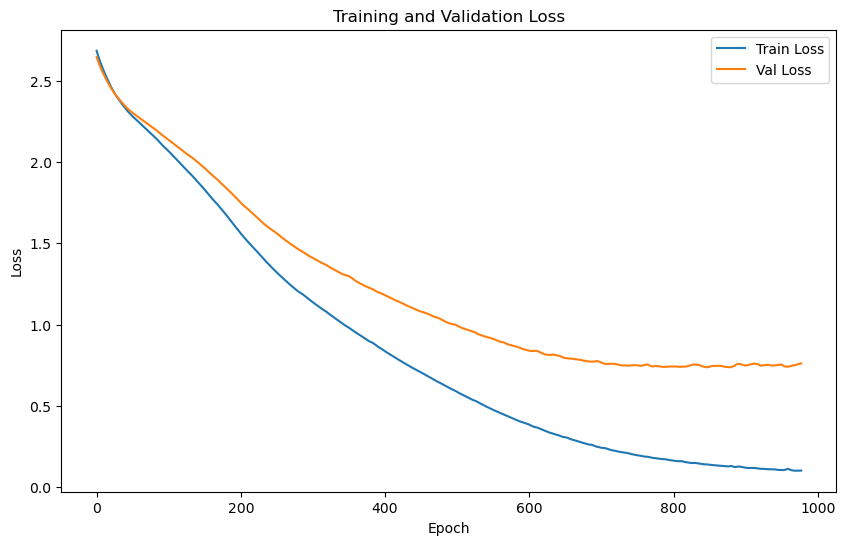

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 1.0568 | Test Accuracy: 70.50%


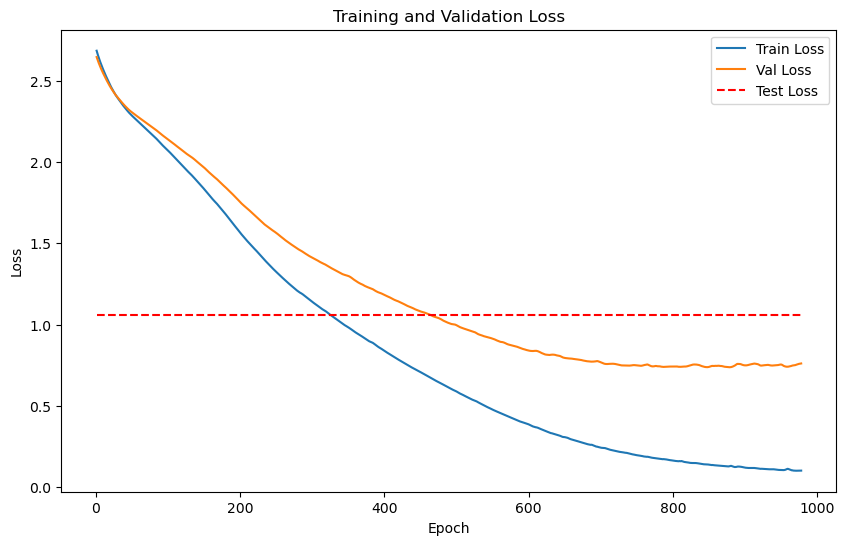

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 70 samples with 64 features each
LOG: Labels shape: (70,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 3108 samples with 64 features each
LOG: Labels shape: (3108,)


Train embeddings shape: (70, 64), 
Train labels shape: (70,)


Val embeddings shape: (70, 64), 
Val labels shape: (70,)


Test embeddings shape: (3108, 64), 
Test labels shape: (3108,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 5, 1: 5, 2: 5, 3: 5, 4: 5, 5: 5, 6: 5, 7: 5, 8: 5, 9: 5, 10: 5, 11: 5, 12: 5, 13: 5}
Training batch size: 70


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/1], Train Loss: 0.4843
LOG: Epoch [1/2000] - Validation
    Batch [1/2], Val Loss: 0.4682
    Batch [2/2], Val Loss: 0.1913
Epoch [1/2000], Avg Train Loss: 0.4843, Avg Val Loss: 0.3298

Validation loss improved from inf to 0.3298. Saving model...
LOG: Epoch [2/2000] - Training


    Batch [1/1], Train Loss: 0.4983
LOG: Epoch [2/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.1919
Epoch [2/2000], Avg Train Loss: 0.4983, Avg Val Loss: 0.3300

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [3/2000] - Training


    Batch [1/1], Train Loss: 0.4848
LOG: Epoch [3/2000] - Validation
    Batch [1/2], Val Loss: 0.4681
    Batch [2/2], Val Loss: 0.1919
Epoch [3/2000], Avg Train Loss: 0.4848, Avg Val Loss: 0.3300

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [4/2000] - Training


    Batch [1/1], Train Loss: 0.4922
LOG: Epoch [4/2000] - Validation
    Batch [1/2], Val Loss: 0.4680
    Batch [2/2], Val Loss: 0.1926
Epoch [4/2000], Avg Train Loss: 0.4922, Avg Val Loss: 0.3303

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [5/2000] - Training


    Batch [1/1], Train Loss: 0.4894
LOG: Epoch [5/2000] - Validation
    Batch [1/2], Val Loss: 0.4678
    Batch [2/2], Val Loss: 0.1929
Epoch [5/2000], Avg Train Loss: 0.4894, Avg Val Loss: 0.3304

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [6/2000] - Training


    Batch [1/1], Train Loss: 0.4890
LOG: Epoch [6/2000] - Validation
    Batch [1/2], Val Loss: 0.4674
    Batch [2/2], Val Loss: 0.1926
Epoch [6/2000], Avg Train Loss: 0.4890, Avg Val Loss: 0.3300

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [7/2000] - Training


    Batch [1/1], Train Loss: 0.4787
LOG: Epoch [7/2000] - Validation
    Batch [1/2], Val Loss: 0.4669
    Batch [2/2], Val Loss: 0.1910
Epoch [7/2000], Avg Train Loss: 0.4787, Avg Val Loss: 0.3290

Validation loss improved from 0.3298 to 0.3290. Saving model...
LOG: Epoch [8/2000] - Training


    Batch [1/1], Train Loss: 0.4864
LOG: Epoch [8/2000] - Validation
    Batch [1/2], Val Loss: 0.4665
    Batch [2/2], Val Loss: 0.1882
Epoch [8/2000], Avg Train Loss: 0.4864, Avg Val Loss: 0.3273

Validation loss improved from 0.3290 to 0.3273. Saving model...
LOG: Epoch [9/2000] - Training


    Batch [1/1], Train Loss: 0.4880
LOG: Epoch [9/2000] - Validation
    Batch [1/2], Val Loss: 0.4661
    Batch [2/2], Val Loss: 0.1843
Epoch [9/2000], Avg Train Loss: 0.4880, Avg Val Loss: 0.3252

Validation loss improved from 0.3273 to 0.3252. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/1], Train Loss: 0.4865
LOG: Epoch [10/2000] - Validation
    Batch [1/2], Val Loss: 0.4658
    Batch [2/2], Val Loss: 0.1793
Epoch [10/2000], Avg Train Loss: 0.4865, Avg Val Loss: 0.3225

Validation loss improved from 0.3252 to 0.3225. Saving model...
LOG: Epoch [11/2000] - Training


    Batch [1/1], Train Loss: 0.4856
LOG: Epoch [11/2000] - Validation
    Batch [1/2], Val Loss: 0.4661
    Batch [2/2], Val Loss: 0.1739
Epoch [11/2000], Avg Train Loss: 0.4856, Avg Val Loss: 0.3200

Validation loss improved from 0.3225 to 0.3200. Saving model...
LOG: Epoch [12/2000] - Training


    Batch [1/1], Train Loss: 0.4869
LOG: Epoch [12/2000] - Validation
    Batch [1/2], Val Loss: 0.4662
    Batch [2/2], Val Loss: 0.1707
Epoch [12/2000], Avg Train Loss: 0.4869, Avg Val Loss: 0.3185

Validation loss improved from 0.3200 to 0.3185. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/1], Train Loss: 0.4752
LOG: Epoch [13/2000] - Validation
    Batch [1/2], Val Loss: 0.4660
    Batch [2/2], Val Loss: 0.1710
Epoch [13/2000], Avg Train Loss: 0.4752, Avg Val Loss: 0.3185

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [14/2000] - Training


    Batch [1/1], Train Loss: 0.4834
LOG: Epoch [14/2000] - Validation
    Batch [1/2], Val Loss: 0.4662
    Batch [2/2], Val Loss: 0.1740
Epoch [14/2000], Avg Train Loss: 0.4834, Avg Val Loss: 0.3201

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [15/2000] - Training


    Batch [1/1], Train Loss: 0.4745
LOG: Epoch [15/2000] - Validation
    Batch [1/2], Val Loss: 0.4659
    Batch [2/2], Val Loss: 0.1764
Epoch [15/2000], Avg Train Loss: 0.4745, Avg Val Loss: 0.3212

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [16/2000] - Training


    Batch [1/1], Train Loss: 0.4777
LOG: Epoch [16/2000] - Validation
    Batch [1/2], Val Loss: 0.4654
    Batch [2/2], Val Loss: 0.1750
Epoch [16/2000], Avg Train Loss: 0.4777, Avg Val Loss: 0.3202

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [17/2000] - Training


    Batch [1/1], Train Loss: 0.4739
LOG: Epoch [17/2000] - Validation
    Batch [1/2], Val Loss: 0.4650
    Batch [2/2], Val Loss: 0.1717
Epoch [17/2000], Avg Train Loss: 0.4739, Avg Val Loss: 0.3183

Validation loss improved from 0.3185 to 0.3183. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/1], Train Loss: 0.4778
LOG: Epoch [18/2000] - Validation
    Batch [1/2], Val Loss: 0.4636
    Batch [2/2], Val Loss: 0.1675
Epoch [18/2000], Avg Train Loss: 0.4778, Avg Val Loss: 0.3156

Validation loss improved from 0.3183 to 0.3156. Saving model...
LOG: Epoch [19/2000] - Training


    Batch [1/1], Train Loss: 0.4795
LOG: Epoch [19/2000] - Validation
    Batch [1/2], Val Loss: 0.4627
    Batch [2/2], Val Loss: 0.1657
Epoch [19/2000], Avg Train Loss: 0.4795, Avg Val Loss: 0.3142

Validation loss improved from 0.3156 to 0.3142. Saving model...
LOG: Epoch [20/2000] - Training


    Batch [1/1], Train Loss: 0.4750
LOG: Epoch [20/2000] - Validation
    Batch [1/2], Val Loss: 0.4622
    Batch [2/2], Val Loss: 0.1650
Epoch [20/2000], Avg Train Loss: 0.4750, Avg Val Loss: 0.3136

Validation loss improved from 0.3142 to 0.3136. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/1], Train Loss: 0.4776
LOG: Epoch [21/2000] - Validation
    Batch [1/2], Val Loss: 0.4607
    Batch [2/2], Val Loss: 0.1625
Epoch [21/2000], Avg Train Loss: 0.4776, Avg Val Loss: 0.3116

Validation loss improved from 0.3136 to 0.3116. Saving model...
LOG: Epoch [22/2000] - Training


    Batch [1/1], Train Loss: 0.4826
LOG: Epoch [22/2000] - Validation
    Batch [1/2], Val Loss: 0.4589
    Batch [2/2], Val Loss: 0.1583
Epoch [22/2000], Avg Train Loss: 0.4826, Avg Val Loss: 0.3086

Validation loss improved from 0.3116 to 0.3086. Saving model...
LOG: Epoch [23/2000] - Training


    Batch [1/1], Train Loss: 0.4779
LOG: Epoch [23/2000] - Validation
    Batch [1/2], Val Loss: 0.4574
    Batch [2/2], Val Loss: 0.1535
Epoch [23/2000], Avg Train Loss: 0.4779, Avg Val Loss: 0.3055

Validation loss improved from 0.3086 to 0.3055. Saving model...
LOG: Epoch [24/2000] - Training


    Batch [1/1], Train Loss: 0.4689
LOG: Epoch [24/2000] - Validation
    Batch [1/2], Val Loss: 0.4569
    Batch [2/2], Val Loss: 0.1484
Epoch [24/2000], Avg Train Loss: 0.4689, Avg Val Loss: 0.3026

Validation loss improved from 0.3055 to 0.3026. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/1], Train Loss: 0.4735
LOG: Epoch [25/2000] - Validation
    Batch [1/2], Val Loss: 0.4556
    Batch [2/2], Val Loss: 0.1438
Epoch [25/2000], Avg Train Loss: 0.4735, Avg Val Loss: 0.2997

Validation loss improved from 0.3026 to 0.2997. Saving model...
LOG: Epoch [26/2000] - Training


    Batch [1/1], Train Loss: 0.4731
LOG: Epoch [26/2000] - Validation
    Batch [1/2], Val Loss: 0.4546
    Batch [2/2], Val Loss: 0.1402
Epoch [26/2000], Avg Train Loss: 0.4731, Avg Val Loss: 0.2974

Validation loss improved from 0.2997 to 0.2974. Saving model...
LOG: Epoch [27/2000] - Training


    Batch [1/1], Train Loss: 0.4698
LOG: Epoch [27/2000] - Validation
    Batch [1/2], Val Loss: 0.4539
    Batch [2/2], Val Loss: 0.1374
Epoch [27/2000], Avg Train Loss: 0.4698, Avg Val Loss: 0.2956

Validation loss improved from 0.2974 to 0.2956. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/1], Train Loss: 0.4740
LOG: Epoch [28/2000] - Validation
    Batch [1/2], Val Loss: 0.4524
    Batch [2/2], Val Loss: 0.1348
Epoch [28/2000], Avg Train Loss: 0.4740, Avg Val Loss: 0.2936

Validation loss improved from 0.2956 to 0.2936. Saving model...
LOG: Epoch [29/2000] - Training
    Batch [1/1], Train Loss: 0.4664
LOG: Epoch [29/2000] - Validation


    Batch [1/2], Val Loss: 0.4511
    Batch [2/2], Val Loss: 0.1324
Epoch [29/2000], Avg Train Loss: 0.4664, Avg Val Loss: 0.2918

Validation loss improved from 0.2936 to 0.2918. Saving model...
LOG: Epoch [30/2000] - Training
    Batch [1/1], Train Loss: 0.4710
LOG: Epoch [30/2000] - Validation


    Batch [1/2], Val Loss: 0.4497
    Batch [2/2], Val Loss: 0.1319
Epoch [30/2000], Avg Train Loss: 0.4710, Avg Val Loss: 0.2908

Validation loss improved from 0.2918 to 0.2908. Saving model...
LOG: Epoch [31/2000] - Training
    Batch [1/1], Train Loss: 0.4643
LOG: Epoch [31/2000] - Validation


    Batch [1/2], Val Loss: 0.4486
    Batch [2/2], Val Loss: 0.1325
Epoch [31/2000], Avg Train Loss: 0.4643, Avg Val Loss: 0.2905

Validation loss improved from 0.2908 to 0.2905. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/1], Train Loss: 0.4662
LOG: Epoch [32/2000] - Validation
    Batch [1/2], Val Loss: 0.4474
    Batch [2/2], Val Loss: 0.1336
Epoch [32/2000], Avg Train Loss: 0.4662, Avg Val Loss: 0.2905

Validation loss improved from 0.2905 to 0.2905. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/1], Train Loss: 0.4672
LOG: Epoch [33/2000] - Validation
    Batch [1/2], Val Loss: 0.4467
    Batch [2/2], Val Loss: 0.1346
Epoch [33/2000], Avg Train Loss: 0.4672, Avg Val Loss: 0.2906

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [34/2000] - Training


    Batch [1/1], Train Loss: 0.4676
LOG: Epoch [34/2000] - Validation
    Batch [1/2], Val Loss: 0.4462
    Batch [2/2], Val Loss: 0.1357
Epoch [34/2000], Avg Train Loss: 0.4676, Avg Val Loss: 0.2910

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [35/2000] - Training


    Batch [1/1], Train Loss: 0.4668
LOG: Epoch [35/2000] - Validation
    Batch [1/2], Val Loss: 0.4461
    Batch [2/2], Val Loss: 0.1375
Epoch [35/2000], Avg Train Loss: 0.4668, Avg Val Loss: 0.2918

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [36/2000] - Training


    Batch [1/1], Train Loss: 0.4635
LOG: Epoch [36/2000] - Validation
    Batch [1/2], Val Loss: 0.4461
    Batch [2/2], Val Loss: 0.1396
Epoch [36/2000], Avg Train Loss: 0.4635, Avg Val Loss: 0.2929

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [37/2000] - Training
    Batch [1/1], Train Loss: 0.4611
LOG: Epoch [37/2000] - Validation


    Batch [1/2], Val Loss: 0.4459
    Batch [2/2], Val Loss: 0.1413
Epoch [37/2000], Avg Train Loss: 0.4611, Avg Val Loss: 0.2936

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [38/2000] - Training
    Batch [1/1], Train Loss: 0.4617
LOG: Epoch [38/2000] - Validation


    Batch [1/2], Val Loss: 0.4453
    Batch [2/2], Val Loss: 0.1430
Epoch [38/2000], Avg Train Loss: 0.4617, Avg Val Loss: 0.2942

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [39/2000] - Training
    Batch [1/1], Train Loss: 0.4516
LOG: Epoch [39/2000] - Validation


    Batch [1/2], Val Loss: 0.4446
    Batch [2/2], Val Loss: 0.1447
Epoch [39/2000], Avg Train Loss: 0.4516, Avg Val Loss: 0.2946

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [40/2000] - Training
    Batch [1/1], Train Loss: 0.4570
LOG: Epoch [40/2000] - Validation


    Batch [1/2], Val Loss: 0.4438
    Batch [2/2], Val Loss: 0.1469
Epoch [40/2000], Avg Train Loss: 0.4570, Avg Val Loss: 0.2954

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [41/2000] - Training
    Batch [1/1], Train Loss: 0.4523
LOG: Epoch [41/2000] - Validation


    Batch [1/2], Val Loss: 0.4432
    Batch [2/2], Val Loss: 0.1492
Epoch [41/2000], Avg Train Loss: 0.4523, Avg Val Loss: 0.2962

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [42/2000] - Training
    Batch [1/1], Train Loss: 0.4543
LOG: Epoch [42/2000] - Validation


    Batch [1/2], Val Loss: 0.4427
    Batch [2/2], Val Loss: 0.1515
Epoch [42/2000], Avg Train Loss: 0.4543, Avg Val Loss: 0.2971

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [43/2000] - Training
    Batch [1/1], Train Loss: 0.4497
LOG: Epoch [43/2000] - Validation


    Batch [1/2], Val Loss: 0.4421
    Batch [2/2], Val Loss: 0.1539
Epoch [43/2000], Avg Train Loss: 0.4497, Avg Val Loss: 0.2980

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [44/2000] - Training
    Batch [1/1], Train Loss: 0.4506
LOG: Epoch [44/2000] - Validation


    Batch [1/2], Val Loss: 0.4416
    Batch [2/2], Val Loss: 0.1560
Epoch [44/2000], Avg Train Loss: 0.4506, Avg Val Loss: 0.2988

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [45/2000] - Training
    Batch [1/1], Train Loss: 0.4536
LOG: Epoch [45/2000] - Validation


    Batch [1/2], Val Loss: 0.4410
    Batch [2/2], Val Loss: 0.1585
Epoch [45/2000], Avg Train Loss: 0.4536, Avg Val Loss: 0.2997

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [46/2000] - Training
    Batch [1/1], Train Loss: 0.4496
LOG: Epoch [46/2000] - Validation


    Batch [1/2], Val Loss: 0.4402
    Batch [2/2], Val Loss: 0.1606
Epoch [46/2000], Avg Train Loss: 0.4496, Avg Val Loss: 0.3004

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [47/2000] - Training
    Batch [1/1], Train Loss: 0.4460
LOG: Epoch [47/2000] - Validation


    Batch [1/2], Val Loss: 0.4397
    Batch [2/2], Val Loss: 0.1629
Epoch [47/2000], Avg Train Loss: 0.4460, Avg Val Loss: 0.3013

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [48/2000] - Training


    Batch [1/1], Train Loss: 0.4531
LOG: Epoch [48/2000] - Validation
    Batch [1/2], Val Loss: 0.4393
    Batch [2/2], Val Loss: 0.1643
Epoch [48/2000], Avg Train Loss: 0.4531, Avg Val Loss: 0.3018

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [49/2000] - Training


    Batch [1/1], Train Loss: 0.4601
LOG: Epoch [49/2000] - Validation
    Batch [1/2], Val Loss: 0.4390
    Batch [2/2], Val Loss: 0.1652
Epoch [49/2000], Avg Train Loss: 0.4601, Avg Val Loss: 0.3021

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [50/2000] - Training


    Batch [1/1], Train Loss: 0.4503
LOG: Epoch [50/2000] - Validation
    Batch [1/2], Val Loss: 0.4387
    Batch [2/2], Val Loss: 0.1655
Epoch [50/2000], Avg Train Loss: 0.4503, Avg Val Loss: 0.3021

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [51/2000] - Training


    Batch [1/1], Train Loss: 0.4436
LOG: Epoch [51/2000] - Validation
    Batch [1/2], Val Loss: 0.4385
    Batch [2/2], Val Loss: 0.1654
Epoch [51/2000], Avg Train Loss: 0.4436, Avg Val Loss: 0.3020

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [52/2000] - Training


    Batch [1/1], Train Loss: 0.4537
LOG: Epoch [52/2000] - Validation
    Batch [1/2], Val Loss: 0.4381
    Batch [2/2], Val Loss: 0.1652
Epoch [52/2000], Avg Train Loss: 0.4537, Avg Val Loss: 0.3017

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [53/2000] - Training


    Batch [1/1], Train Loss: 0.4482
LOG: Epoch [53/2000] - Validation
    Batch [1/2], Val Loss: 0.4376
    Batch [2/2], Val Loss: 0.1644
Epoch [53/2000], Avg Train Loss: 0.4482, Avg Val Loss: 0.3010

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [54/2000] - Training
    Batch [1/1], Train Loss: 0.4376
LOG: Epoch [54/2000] - Validation


    Batch [1/2], Val Loss: 0.4372
    Batch [2/2], Val Loss: 0.1636
Epoch [54/2000], Avg Train Loss: 0.4376, Avg Val Loss: 0.3004

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [55/2000] - Training
    Batch [1/1], Train Loss: 0.4502
LOG: Epoch [55/2000] - Validation


    Batch [1/2], Val Loss: 0.4368
    Batch [2/2], Val Loss: 0.1625
Epoch [55/2000], Avg Train Loss: 0.4502, Avg Val Loss: 0.2996

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [56/2000] - Training


    Batch [1/1], Train Loss: 0.4470
LOG: Epoch [56/2000] - Validation
    Batch [1/2], Val Loss: 0.4361
    Batch [2/2], Val Loss: 0.1613
Epoch [56/2000], Avg Train Loss: 0.4470, Avg Val Loss: 0.2987

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [57/2000] - Training


    Batch [1/1], Train Loss: 0.4385
LOG: Epoch [57/2000] - Validation
    Batch [1/2], Val Loss: 0.4355
    Batch [2/2], Val Loss: 0.1601
Epoch [57/2000], Avg Train Loss: 0.4385, Avg Val Loss: 0.2978

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [58/2000] - Training


    Batch [1/1], Train Loss: 0.4421
LOG: Epoch [58/2000] - Validation
    Batch [1/2], Val Loss: 0.4352
    Batch [2/2], Val Loss: 0.1583
Epoch [58/2000], Avg Train Loss: 0.4421, Avg Val Loss: 0.2968

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [59/2000] - Training


    Batch [1/1], Train Loss: 0.4431
LOG: Epoch [59/2000] - Validation
    Batch [1/2], Val Loss: 0.4340
    Batch [2/2], Val Loss: 0.1576
Epoch [59/2000], Avg Train Loss: 0.4431, Avg Val Loss: 0.2958

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [60/2000] - Training


    Batch [1/1], Train Loss: 0.4488
LOG: Epoch [60/2000] - Validation
    Batch [1/2], Val Loss: 0.4329
    Batch [2/2], Val Loss: 0.1569
Epoch [60/2000], Avg Train Loss: 0.4488, Avg Val Loss: 0.2949

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [61/2000] - Training


    Batch [1/1], Train Loss: 0.4432
LOG: Epoch [61/2000] - Validation
    Batch [1/2], Val Loss: 0.4319
    Batch [2/2], Val Loss: 0.1563
Epoch [61/2000], Avg Train Loss: 0.4432, Avg Val Loss: 0.2941

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [62/2000] - Training


    Batch [1/1], Train Loss: 0.4301
LOG: Epoch [62/2000] - Validation
    Batch [1/2], Val Loss: 0.4314
    Batch [2/2], Val Loss: 0.1558
Epoch [62/2000], Avg Train Loss: 0.4301, Avg Val Loss: 0.2936

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [63/2000] - Training


    Batch [1/1], Train Loss: 0.4397
LOG: Epoch [63/2000] - Validation
    Batch [1/2], Val Loss: 0.4310
    Batch [2/2], Val Loss: 0.1552
Epoch [63/2000], Avg Train Loss: 0.4397, Avg Val Loss: 0.2931

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [64/2000] - Training


    Batch [1/1], Train Loss: 0.4449
LOG: Epoch [64/2000] - Validation
    Batch [1/2], Val Loss: 0.4307
    Batch [2/2], Val Loss: 0.1545
Epoch [64/2000], Avg Train Loss: 0.4449, Avg Val Loss: 0.2926

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [65/2000] - Training


    Batch [1/1], Train Loss: 0.4389
LOG: Epoch [65/2000] - Validation
    Batch [1/2], Val Loss: 0.4306
    Batch [2/2], Val Loss: 0.1537
Epoch [65/2000], Avg Train Loss: 0.4389, Avg Val Loss: 0.2922

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [66/2000] - Training


    Batch [1/1], Train Loss: 0.4466
LOG: Epoch [66/2000] - Validation
    Batch [1/2], Val Loss: 0.4304
    Batch [2/2], Val Loss: 0.1529
Epoch [66/2000], Avg Train Loss: 0.4466, Avg Val Loss: 0.2916

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [67/2000] - Training


    Batch [1/1], Train Loss: 0.4469
LOG: Epoch [67/2000] - Validation
    Batch [1/2], Val Loss: 0.4302
    Batch [2/2], Val Loss: 0.1519
Epoch [67/2000], Avg Train Loss: 0.4469, Avg Val Loss: 0.2910

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [68/2000] - Training


    Batch [1/1], Train Loss: 0.4457
LOG: Epoch [68/2000] - Validation
    Batch [1/2], Val Loss: 0.4299
    Batch [2/2], Val Loss: 0.1508
Epoch [68/2000], Avg Train Loss: 0.4457, Avg Val Loss: 0.2904

Validation loss improved from 0.2905 to 0.2904. Saving model...
LOG: Epoch [69/2000] - Training


    Batch [1/1], Train Loss: 0.4436
LOG: Epoch [69/2000] - Validation
    Batch [1/2], Val Loss: 0.4296
    Batch [2/2], Val Loss: 0.1499
Epoch [69/2000], Avg Train Loss: 0.4436, Avg Val Loss: 0.2897

Validation loss improved from 0.2904 to 0.2897. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/1], Train Loss: 0.4387
LOG: Epoch [70/2000] - Validation
    Batch [1/2], Val Loss: 0.4294
    Batch [2/2], Val Loss: 0.1490
Epoch [70/2000], Avg Train Loss: 0.4387, Avg Val Loss: 0.2892

Validation loss improved from 0.2897 to 0.2892. Saving model...
LOG: Epoch [71/2000] - Training


    Batch [1/1], Train Loss: 0.4435
LOG: Epoch [71/2000] - Validation
    Batch [1/2], Val Loss: 0.4290
    Batch [2/2], Val Loss: 0.1484
Epoch [71/2000], Avg Train Loss: 0.4435, Avg Val Loss: 0.2887

Validation loss improved from 0.2892 to 0.2887. Saving model...
LOG: Epoch [72/2000] - Training


    Batch [1/1], Train Loss: 0.4348
LOG: Epoch [72/2000] - Validation
    Batch [1/2], Val Loss: 0.4286
    Batch [2/2], Val Loss: 0.1478
Epoch [72/2000], Avg Train Loss: 0.4348, Avg Val Loss: 0.2882

Validation loss improved from 0.2887 to 0.2882. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/1], Train Loss: 0.4476
LOG: Epoch [73/2000] - Validation
    Batch [1/2], Val Loss: 0.4282
    Batch [2/2], Val Loss: 0.1473
Epoch [73/2000], Avg Train Loss: 0.4476, Avg Val Loss: 0.2877

Validation loss improved from 0.2882 to 0.2877. Saving model...
LOG: Epoch [74/2000] - Training


    Batch [1/1], Train Loss: 0.4433
LOG: Epoch [74/2000] - Validation
    Batch [1/2], Val Loss: 0.4277
    Batch [2/2], Val Loss: 0.1470
Epoch [74/2000], Avg Train Loss: 0.4433, Avg Val Loss: 0.2873

Validation loss improved from 0.2877 to 0.2873. Saving model...
LOG: Epoch [75/2000] - Training


    Batch [1/1], Train Loss: 0.4375
LOG: Epoch [75/2000] - Validation
    Batch [1/2], Val Loss: 0.4273
    Batch [2/2], Val Loss: 0.1467
Epoch [75/2000], Avg Train Loss: 0.4375, Avg Val Loss: 0.2870

Validation loss improved from 0.2873 to 0.2870. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/1], Train Loss: 0.4352
LOG: Epoch [76/2000] - Validation
    Batch [1/2], Val Loss: 0.4268
    Batch [2/2], Val Loss: 0.1465
Epoch [76/2000], Avg Train Loss: 0.4352, Avg Val Loss: 0.2866

Validation loss improved from 0.2870 to 0.2866. Saving model...
LOG: Epoch [77/2000] - Training


    Batch [1/1], Train Loss: 0.4409
LOG: Epoch [77/2000] - Validation
    Batch [1/2], Val Loss: 0.4264
    Batch [2/2], Val Loss: 0.1463
Epoch [77/2000], Avg Train Loss: 0.4409, Avg Val Loss: 0.2863

Validation loss improved from 0.2866 to 0.2863. Saving model...
LOG: Epoch [78/2000] - Training


    Batch [1/1], Train Loss: 0.4341
LOG: Epoch [78/2000] - Validation
    Batch [1/2], Val Loss: 0.4261
    Batch [2/2], Val Loss: 0.1461
Epoch [78/2000], Avg Train Loss: 0.4341, Avg Val Loss: 0.2861

Validation loss improved from 0.2863 to 0.2861. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/1], Train Loss: 0.4416
LOG: Epoch [79/2000] - Validation
    Batch [1/2], Val Loss: 0.4258
    Batch [2/2], Val Loss: 0.1460
Epoch [79/2000], Avg Train Loss: 0.4416, Avg Val Loss: 0.2859

Validation loss improved from 0.2861 to 0.2859. Saving model...
LOG: Epoch [80/2000] - Training


    Batch [1/1], Train Loss: 0.4416
LOG: Epoch [80/2000] - Validation
    Batch [1/2], Val Loss: 0.4256
    Batch [2/2], Val Loss: 0.1460
Epoch [80/2000], Avg Train Loss: 0.4416, Avg Val Loss: 0.2858

Validation loss improved from 0.2859 to 0.2858. Saving model...
LOG: Epoch [81/2000] - Training


    Batch [1/1], Train Loss: 0.4380
LOG: Epoch [81/2000] - Validation
    Batch [1/2], Val Loss: 0.4253
    Batch [2/2], Val Loss: 0.1459
Epoch [81/2000], Avg Train Loss: 0.4380, Avg Val Loss: 0.2856

Validation loss improved from 0.2858 to 0.2856. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/1], Train Loss: 0.4430
LOG: Epoch [82/2000] - Validation
    Batch [1/2], Val Loss: 0.4251
    Batch [2/2], Val Loss: 0.1460
Epoch [82/2000], Avg Train Loss: 0.4430, Avg Val Loss: 0.2856

Validation loss improved from 0.2856 to 0.2856. Saving model...
LOG: Epoch [83/2000] - Training


    Batch [1/1], Train Loss: 0.4363
LOG: Epoch [83/2000] - Validation
    Batch [1/2], Val Loss: 0.4249
    Batch [2/2], Val Loss: 0.1461
Epoch [83/2000], Avg Train Loss: 0.4363, Avg Val Loss: 0.2855

Validation loss improved from 0.2856 to 0.2855. Saving model...
LOG: Epoch [84/2000] - Training


    Batch [1/1], Train Loss: 0.4500
LOG: Epoch [84/2000] - Validation
    Batch [1/2], Val Loss: 0.4247
    Batch [2/2], Val Loss: 0.1462
Epoch [84/2000], Avg Train Loss: 0.4500, Avg Val Loss: 0.2855

Validation loss improved from 0.2855 to 0.2855. Saving model...
LOG: Epoch [85/2000] - Training


    Batch [1/1], Train Loss: 0.4467
LOG: Epoch [85/2000] - Validation
    Batch [1/2], Val Loss: 0.4246
    Batch [2/2], Val Loss: 0.1462
Epoch [85/2000], Avg Train Loss: 0.4467, Avg Val Loss: 0.2854

Validation loss improved from 0.2855 to 0.2854. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/1], Train Loss: 0.4421
LOG: Epoch [86/2000] - Validation
    Batch [1/2], Val Loss: 0.4244
    Batch [2/2], Val Loss: 0.1463
Epoch [86/2000], Avg Train Loss: 0.4421, Avg Val Loss: 0.2853

Validation loss improved from 0.2854 to 0.2853. Saving model...
LOG: Epoch [87/2000] - Training


    Batch [1/1], Train Loss: 0.4398
LOG: Epoch [87/2000] - Validation
    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1463
Epoch [87/2000], Avg Train Loss: 0.4398, Avg Val Loss: 0.2853

Validation loss improved from 0.2853 to 0.2853. Saving model...
LOG: Epoch [88/2000] - Training


    Batch [1/1], Train Loss: 0.4398
LOG: Epoch [88/2000] - Validation
    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1463
Epoch [88/2000], Avg Train Loss: 0.4398, Avg Val Loss: 0.2853

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [89/2000] - Training


    Batch [1/1], Train Loss: 0.4414
LOG: Epoch [89/2000] - Validation
    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1464
Epoch [89/2000], Avg Train Loss: 0.4414, Avg Val Loss: 0.2853

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [90/2000] - Training


    Batch [1/1], Train Loss: 0.4389
LOG: Epoch [90/2000] - Validation
    Batch [1/2], Val Loss: 0.4242
    Batch [2/2], Val Loss: 0.1464
Epoch [90/2000], Avg Train Loss: 0.4389, Avg Val Loss: 0.2853

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [91/2000] - Training


    Batch [1/1], Train Loss: 0.4394
LOG: Epoch [91/2000] - Validation
    Batch [1/2], Val Loss: 0.4242
    Batch [2/2], Val Loss: 0.1464
Epoch [91/2000], Avg Train Loss: 0.4394, Avg Val Loss: 0.2853

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [92/2000] - Training


    Batch [1/1], Train Loss: 0.4390
LOG: Epoch [92/2000] - Validation
    Batch [1/2], Val Loss: 0.4242
    Batch [2/2], Val Loss: 0.1464
Epoch [92/2000], Avg Train Loss: 0.4390, Avg Val Loss: 0.2853

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [93/2000] - Training


    Batch [1/1], Train Loss: 0.4382
LOG: Epoch [93/2000] - Validation
    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1465
Epoch [93/2000], Avg Train Loss: 0.4382, Avg Val Loss: 0.2854

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [94/2000] - Training


    Batch [1/1], Train Loss: 0.4419
LOG: Epoch [94/2000] - Validation
    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1465
Epoch [94/2000], Avg Train Loss: 0.4419, Avg Val Loss: 0.2854

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [95/2000] - Training


    Batch [1/1], Train Loss: 0.4365
LOG: Epoch [95/2000] - Validation
    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1466
Epoch [95/2000], Avg Train Loss: 0.4365, Avg Val Loss: 0.2855

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [96/2000] - Training


    Batch [1/1], Train Loss: 0.4309
LOG: Epoch [96/2000] - Validation
    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1467
Epoch [96/2000], Avg Train Loss: 0.4309, Avg Val Loss: 0.2855

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [97/2000] - Training


    Batch [1/1], Train Loss: 0.4328
LOG: Epoch [97/2000] - Validation
    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1468
Epoch [97/2000], Avg Train Loss: 0.4328, Avg Val Loss: 0.2855

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [98/2000] - Training


    Batch [1/1], Train Loss: 0.4374
LOG: Epoch [98/2000] - Validation
    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1470
Epoch [98/2000], Avg Train Loss: 0.4374, Avg Val Loss: 0.2856

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [99/2000] - Training


    Batch [1/1], Train Loss: 0.4425
LOG: Epoch [99/2000] - Validation
    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1471
Epoch [99/2000], Avg Train Loss: 0.4425, Avg Val Loss: 0.2857

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [100/2000] - Training
    Batch [1/1], Train Loss: 0.4412
LOG: Epoch [100/2000] - Validation


    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1472
Epoch [100/2000], Avg Train Loss: 0.4412, Avg Val Loss: 0.2857

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [101/2000] - Training
    Batch [1/1], Train Loss: 0.4421
LOG: Epoch [101/2000] - Validation


    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1472
Epoch [101/2000], Avg Train Loss: 0.4421, Avg Val Loss: 0.2858

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [102/2000] - Training


    Batch [1/1], Train Loss: 0.4320
LOG: Epoch [102/2000] - Validation
    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1472
Epoch [102/2000], Avg Train Loss: 0.4320, Avg Val Loss: 0.2858

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [103/2000] - Training


    Batch [1/1], Train Loss: 0.4369
LOG: Epoch [103/2000] - Validation
    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1473
Epoch [103/2000], Avg Train Loss: 0.4369, Avg Val Loss: 0.2858

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [104/2000] - Training


    Batch [1/1], Train Loss: 0.4399
LOG: Epoch [104/2000] - Validation
    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1473
Epoch [104/2000], Avg Train Loss: 0.4399, Avg Val Loss: 0.2858

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [105/2000] - Training


    Batch [1/1], Train Loss: 0.4450
LOG: Epoch [105/2000] - Validation
    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1473
Epoch [105/2000], Avg Train Loss: 0.4450, Avg Val Loss: 0.2858

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [106/2000] - Training


    Batch [1/1], Train Loss: 0.4403
LOG: Epoch [106/2000] - Validation
    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1474
Epoch [106/2000], Avg Train Loss: 0.4403, Avg Val Loss: 0.2858

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [107/2000] - Training


    Batch [1/1], Train Loss: 0.4353
LOG: Epoch [107/2000] - Validation
    Batch [1/2], Val Loss: 0.4244
    Batch [2/2], Val Loss: 0.1474
Epoch [107/2000], Avg Train Loss: 0.4353, Avg Val Loss: 0.2859

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [108/2000] - Training


    Batch [1/1], Train Loss: 0.4396
LOG: Epoch [108/2000] - Validation
    Batch [1/2], Val Loss: 0.4244
    Batch [2/2], Val Loss: 0.1473
Epoch [108/2000], Avg Train Loss: 0.4396, Avg Val Loss: 0.2859

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [109/2000] - Training


    Batch [1/1], Train Loss: 0.4362
LOG: Epoch [109/2000] - Validation
    Batch [1/2], Val Loss: 0.4245
    Batch [2/2], Val Loss: 0.1473
Epoch [109/2000], Avg Train Loss: 0.4362, Avg Val Loss: 0.2859

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [110/2000] - Training


    Batch [1/1], Train Loss: 0.4388
LOG: Epoch [110/2000] - Validation
    Batch [1/2], Val Loss: 0.4245
    Batch [2/2], Val Loss: 0.1472
Epoch [110/2000], Avg Train Loss: 0.4388, Avg Val Loss: 0.2859

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [111/2000] - Training


    Batch [1/1], Train Loss: 0.4335
LOG: Epoch [111/2000] - Validation
    Batch [1/2], Val Loss: 0.4245
    Batch [2/2], Val Loss: 0.1472
Epoch [111/2000], Avg Train Loss: 0.4335, Avg Val Loss: 0.2858

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [112/2000] - Training


    Batch [1/1], Train Loss: 0.4434
LOG: Epoch [112/2000] - Validation
    Batch [1/2], Val Loss: 0.4245
    Batch [2/2], Val Loss: 0.1470
Epoch [112/2000], Avg Train Loss: 0.4434, Avg Val Loss: 0.2857

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [113/2000] - Training
    Batch [1/1], Train Loss: 0.4290
LOG: Epoch [113/2000] - Validation


    Batch [1/2], Val Loss: 0.4244
    Batch [2/2], Val Loss: 0.1470
Epoch [113/2000], Avg Train Loss: 0.4290, Avg Val Loss: 0.2857

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [114/2000] - Training
    Batch [1/1], Train Loss: 0.4456
LOG: Epoch [114/2000] - Validation


    Batch [1/2], Val Loss: 0.4243
    Batch [2/2], Val Loss: 0.1470
Epoch [114/2000], Avg Train Loss: 0.4456, Avg Val Loss: 0.2857

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [115/2000] - Training
    Batch [1/1], Train Loss: 0.4339
LOG: Epoch [115/2000] - Validation


    Batch [1/2], Val Loss: 0.4242
    Batch [2/2], Val Loss: 0.1471
Epoch [115/2000], Avg Train Loss: 0.4339, Avg Val Loss: 0.2856

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [116/2000] - Training
    Batch [1/1], Train Loss: 0.4385
LOG: Epoch [116/2000] - Validation


    Batch [1/2], Val Loss: 0.4241
    Batch [2/2], Val Loss: 0.1472
Epoch [116/2000], Avg Train Loss: 0.4385, Avg Val Loss: 0.2856

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [117/2000] - Training
    Batch [1/1], Train Loss: 0.4475
LOG: Epoch [117/2000] - Validation


    Batch [1/2], Val Loss: 0.4240
    Batch [2/2], Val Loss: 0.1473
Epoch [117/2000], Avg Train Loss: 0.4475, Avg Val Loss: 0.2856

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [118/2000] - Training
    Batch [1/1], Train Loss: 0.4369
LOG: Epoch [118/2000] - Validation


    Batch [1/2], Val Loss: 0.4240
    Batch [2/2], Val Loss: 0.1473
Epoch [118/2000], Avg Train Loss: 0.4369, Avg Val Loss: 0.2856

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [119/2000] - Training
    Batch [1/1], Train Loss: 0.4432
LOG: Epoch [119/2000] - Validation


    Batch [1/2], Val Loss: 0.4239
    Batch [2/2], Val Loss: 0.1474
Epoch [119/2000], Avg Train Loss: 0.4432, Avg Val Loss: 0.2857

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [120/2000] - Training
    Batch [1/1], Train Loss: 0.4407
LOG: Epoch [120/2000] - Validation


    Batch [1/2], Val Loss: 0.4239
    Batch [2/2], Val Loss: 0.1475
Epoch [120/2000], Avg Train Loss: 0.4407, Avg Val Loss: 0.2857

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [121/2000] - Training
    Batch [1/1], Train Loss: 0.4408
LOG: Epoch [121/2000] - Validation


    Batch [1/2], Val Loss: 0.4238
    Batch [2/2], Val Loss: 0.1475
Epoch [121/2000], Avg Train Loss: 0.4408, Avg Val Loss: 0.2857

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [122/2000] - Training
    Batch [1/1], Train Loss: 0.4399
LOG: Epoch [122/2000] - Validation


    Batch [1/2], Val Loss: 0.4238
    Batch [2/2], Val Loss: 0.1476
Epoch [122/2000], Avg Train Loss: 0.4399, Avg Val Loss: 0.2857

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [123/2000] - Training


    Batch [1/1], Train Loss: 0.4451
LOG: Epoch [123/2000] - Validation
    Batch [1/2], Val Loss: 0.4237
    Batch [2/2], Val Loss: 0.1477
Epoch [123/2000], Avg Train Loss: 0.4451, Avg Val Loss: 0.2857

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [124/2000] - Training


    Batch [1/1], Train Loss: 0.4363
LOG: Epoch [124/2000] - Validation
    Batch [1/2], Val Loss: 0.4237
    Batch [2/2], Val Loss: 0.1477
Epoch [124/2000], Avg Train Loss: 0.4363, Avg Val Loss: 0.2857

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [125/2000] - Training


    Batch [1/1], Train Loss: 0.4433
LOG: Epoch [125/2000] - Validation
    Batch [1/2], Val Loss: 0.4237
    Batch [2/2], Val Loss: 0.1478
Epoch [125/2000], Avg Train Loss: 0.4433, Avg Val Loss: 0.2857

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [126/2000] - Training


    Batch [1/1], Train Loss: 0.4422
LOG: Epoch [126/2000] - Validation
    Batch [1/2], Val Loss: 0.4236
    Batch [2/2], Val Loss: 0.1478
Epoch [126/2000], Avg Train Loss: 0.4422, Avg Val Loss: 0.2857

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [127/2000] - Training


    Batch [1/1], Train Loss: 0.4377
LOG: Epoch [127/2000] - Validation
    Batch [1/2], Val Loss: 0.4236
    Batch [2/2], Val Loss: 0.1478
Epoch [127/2000], Avg Train Loss: 0.4377, Avg Val Loss: 0.2857

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [128/2000] - Training


    Batch [1/1], Train Loss: 0.4550
LOG: Epoch [128/2000] - Validation
    Batch [1/2], Val Loss: 0.4236
    Batch [2/2], Val Loss: 0.1479
Epoch [128/2000], Avg Train Loss: 0.4550, Avg Val Loss: 0.2857

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [129/2000] - Training


    Batch [1/1], Train Loss: 0.4412
LOG: Epoch [129/2000] - Validation
    Batch [1/2], Val Loss: 0.4236
    Batch [2/2], Val Loss: 0.1479
Epoch [129/2000], Avg Train Loss: 0.4412, Avg Val Loss: 0.2857

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [130/2000] - Training


    Batch [1/1], Train Loss: 0.4320
LOG: Epoch [130/2000] - Validation
    Batch [1/2], Val Loss: 0.4235
    Batch [2/2], Val Loss: 0.1479
Epoch [130/2000], Avg Train Loss: 0.4320, Avg Val Loss: 0.2857

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [131/2000] - Training


    Batch [1/1], Train Loss: 0.4428
LOG: Epoch [131/2000] - Validation
    Batch [1/2], Val Loss: 0.4235
    Batch [2/2], Val Loss: 0.1479
Epoch [131/2000], Avg Train Loss: 0.4428, Avg Val Loss: 0.2857

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [132/2000] - Training


    Batch [1/1], Train Loss: 0.4376
LOG: Epoch [132/2000] - Validation
    Batch [1/2], Val Loss: 0.4235
    Batch [2/2], Val Loss: 0.1479
Epoch [132/2000], Avg Train Loss: 0.4376, Avg Val Loss: 0.2857

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [133/2000] - Training


    Batch [1/1], Train Loss: 0.4366
LOG: Epoch [133/2000] - Validation
    Batch [1/2], Val Loss: 0.4235
    Batch [2/2], Val Loss: 0.1480
Epoch [133/2000], Avg Train Loss: 0.4366, Avg Val Loss: 0.2857

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [134/2000] - Training


    Batch [1/1], Train Loss: 0.4409
LOG: Epoch [134/2000] - Validation
    Batch [1/2], Val Loss: 0.4235
    Batch [2/2], Val Loss: 0.1480
Epoch [134/2000], Avg Train Loss: 0.4409, Avg Val Loss: 0.2857

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [135/2000] - Training


    Batch [1/1], Train Loss: 0.4495
LOG: Epoch [135/2000] - Validation
    Batch [1/2], Val Loss: 0.4234
    Batch [2/2], Val Loss: 0.1480
Epoch [135/2000], Avg Train Loss: 0.4495, Avg Val Loss: 0.2857

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [136/2000] - Training


    Batch [1/1], Train Loss: 0.4331
LOG: Epoch [136/2000] - Validation
    Batch [1/2], Val Loss: 0.4234
    Batch [2/2], Val Loss: 0.1480
Epoch [136/2000], Avg Train Loss: 0.4331, Avg Val Loss: 0.2857

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [137/2000] - Training


    Batch [1/1], Train Loss: 0.4387
LOG: Epoch [137/2000] - Validation
    Batch [1/2], Val Loss: 0.4234
    Batch [2/2], Val Loss: 0.1480
Epoch [137/2000], Avg Train Loss: 0.4387, Avg Val Loss: 0.2857

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [138/2000] - Training


    Batch [1/1], Train Loss: 0.4445
LOG: Epoch [138/2000] - Validation
    Batch [1/2], Val Loss: 0.4234
    Batch [2/2], Val Loss: 0.1480
Epoch [138/2000], Avg Train Loss: 0.4445, Avg Val Loss: 0.2857

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [139/2000] - Training


    Batch [1/1], Train Loss: 0.4396
LOG: Epoch [139/2000] - Validation
    Batch [1/2], Val Loss: 0.4234
    Batch [2/2], Val Loss: 0.1480
Epoch [139/2000], Avg Train Loss: 0.4396, Avg Val Loss: 0.2857

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [140/2000] - Training


    Batch [1/1], Train Loss: 0.4394
LOG: Epoch [140/2000] - Validation
    Batch [1/2], Val Loss: 0.4234
    Batch [2/2], Val Loss: 0.1481
Epoch [140/2000], Avg Train Loss: 0.4394, Avg Val Loss: 0.2857

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [141/2000] - Training


    Batch [1/1], Train Loss: 0.4348
LOG: Epoch [141/2000] - Validation
    Batch [1/2], Val Loss: 0.4234
    Batch [2/2], Val Loss: 0.1481
Epoch [141/2000], Avg Train Loss: 0.4348, Avg Val Loss: 0.2857

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [142/2000] - Training


    Batch [1/1], Train Loss: 0.4297
LOG: Epoch [142/2000] - Validation
    Batch [1/2], Val Loss: 0.4234
    Batch [2/2], Val Loss: 0.1481
Epoch [142/2000], Avg Train Loss: 0.4297, Avg Val Loss: 0.2857

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [143/2000] - Training


    Batch [1/1], Train Loss: 0.4410
LOG: Epoch [143/2000] - Validation
    Batch [1/2], Val Loss: 0.4234
    Batch [2/2], Val Loss: 0.1481
Epoch [143/2000], Avg Train Loss: 0.4410, Avg Val Loss: 0.2857

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [144/2000] - Training
    Batch [1/1], Train Loss: 0.4453
LOG: Epoch [144/2000] - Validation


    Batch [1/2], Val Loss: 0.4234
    Batch [2/2], Val Loss: 0.1481
Epoch [144/2000], Avg Train Loss: 0.4453, Avg Val Loss: 0.2858

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [145/2000] - Training
    Batch [1/1], Train Loss: 0.4355
LOG: Epoch [145/2000] - Validation


    Batch [1/2], Val Loss: 0.4234
    Batch [2/2], Val Loss: 0.1482
Epoch [145/2000], Avg Train Loss: 0.4355, Avg Val Loss: 0.2858

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [146/2000] - Training
    Batch [1/1], Train Loss: 0.4438
LOG: Epoch [146/2000] - Validation


    Batch [1/2], Val Loss: 0.4234
    Batch [2/2], Val Loss: 0.1482
Epoch [146/2000], Avg Train Loss: 0.4438, Avg Val Loss: 0.2858

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [147/2000] - Training
    Batch [1/1], Train Loss: 0.4390
LOG: Epoch [147/2000] - Validation


    Batch [1/2], Val Loss: 0.4234
    Batch [2/2], Val Loss: 0.1482
Epoch [147/2000], Avg Train Loss: 0.4390, Avg Val Loss: 0.2858

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [148/2000] - Training


    Batch [1/1], Train Loss: 0.4443
LOG: Epoch [148/2000] - Validation
    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.1482
Epoch [148/2000], Avg Train Loss: 0.4443, Avg Val Loss: 0.2858

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [149/2000] - Training


    Batch [1/1], Train Loss: 0.4370
LOG: Epoch [149/2000] - Validation
    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.1482
Epoch [149/2000], Avg Train Loss: 0.4370, Avg Val Loss: 0.2858

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [150/2000] - Training


    Batch [1/1], Train Loss: 0.4375
LOG: Epoch [150/2000] - Validation
    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.1482
Epoch [150/2000], Avg Train Loss: 0.4375, Avg Val Loss: 0.2858

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [151/2000] - Training


    Batch [1/1], Train Loss: 0.4453
LOG: Epoch [151/2000] - Validation
    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.1482
Epoch [151/2000], Avg Train Loss: 0.4453, Avg Val Loss: 0.2858

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [152/2000] - Training


    Batch [1/1], Train Loss: 0.4415
LOG: Epoch [152/2000] - Validation
    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.1482
Epoch [152/2000], Avg Train Loss: 0.4415, Avg Val Loss: 0.2858

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [153/2000] - Training


    Batch [1/1], Train Loss: 0.4345
LOG: Epoch [153/2000] - Validation
    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.1482
Epoch [153/2000], Avg Train Loss: 0.4345, Avg Val Loss: 0.2858

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [154/2000] - Training


    Batch [1/1], Train Loss: 0.4397
LOG: Epoch [154/2000] - Validation
    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.1483
Epoch [154/2000], Avg Train Loss: 0.4397, Avg Val Loss: 0.2858

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [155/2000] - Training


    Batch [1/1], Train Loss: 0.4413
LOG: Epoch [155/2000] - Validation
    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.1483
Epoch [155/2000], Avg Train Loss: 0.4413, Avg Val Loss: 0.2858

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [156/2000] - Training


    Batch [1/1], Train Loss: 0.4447
LOG: Epoch [156/2000] - Validation
    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.1483
Epoch [156/2000], Avg Train Loss: 0.4447, Avg Val Loss: 0.2858

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [157/2000] - Training
    Batch [1/1], Train Loss: 0.4338
LOG: Epoch [157/2000] - Validation


    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.1483
Epoch [157/2000], Avg Train Loss: 0.4338, Avg Val Loss: 0.2858

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [158/2000] - Training
    Batch [1/1], Train Loss: 0.4287
LOG: Epoch [158/2000] - Validation


    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.1483
Epoch [158/2000], Avg Train Loss: 0.4287, Avg Val Loss: 0.2858

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [159/2000] - Training


    Batch [1/1], Train Loss: 0.4273
LOG: Epoch [159/2000] - Validation
    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.1483
Epoch [159/2000], Avg Train Loss: 0.4273, Avg Val Loss: 0.2858

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [160/2000] - Training


    Batch [1/1], Train Loss: 0.4427
LOG: Epoch [160/2000] - Validation
    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.1483
Epoch [160/2000], Avg Train Loss: 0.4427, Avg Val Loss: 0.2858

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [161/2000] - Training


    Batch [1/1], Train Loss: 0.4328
LOG: Epoch [161/2000] - Validation
    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.1483
Epoch [161/2000], Avg Train Loss: 0.4328, Avg Val Loss: 0.2858

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [162/2000] - Training


    Batch [1/1], Train Loss: 0.4366
LOG: Epoch [162/2000] - Validation
    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.1483
Epoch [162/2000], Avg Train Loss: 0.4366, Avg Val Loss: 0.2858

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [163/2000] - Training


    Batch [1/1], Train Loss: 0.4332
LOG: Epoch [163/2000] - Validation
    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.1483
Epoch [163/2000], Avg Train Loss: 0.4332, Avg Val Loss: 0.2858

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [164/2000] - Training


    Batch [1/1], Train Loss: 0.4454
LOG: Epoch [164/2000] - Validation
    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.1483
Epoch [164/2000], Avg Train Loss: 0.4454, Avg Val Loss: 0.2858

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [165/2000] - Training


    Batch [1/1], Train Loss: 0.4359
LOG: Epoch [165/2000] - Validation
    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.1483
Epoch [165/2000], Avg Train Loss: 0.4359, Avg Val Loss: 0.2858

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [166/2000] - Training


    Batch [1/1], Train Loss: 0.4403
LOG: Epoch [166/2000] - Validation
    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.1483
Epoch [166/2000], Avg Train Loss: 0.4403, Avg Val Loss: 0.2858

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [167/2000] - Training


    Batch [1/1], Train Loss: 0.4319
LOG: Epoch [167/2000] - Validation
    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.1483
Epoch [167/2000], Avg Train Loss: 0.4319, Avg Val Loss: 0.2858

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [168/2000] - Training


    Batch [1/1], Train Loss: 0.4385
LOG: Epoch [168/2000] - Validation
    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.1483
Epoch [168/2000], Avg Train Loss: 0.4385, Avg Val Loss: 0.2858

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [169/2000] - Training


    Batch [1/1], Train Loss: 0.4437
LOG: Epoch [169/2000] - Validation
    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.1483
Epoch [169/2000], Avg Train Loss: 0.4437, Avg Val Loss: 0.2858

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [170/2000] - Training


    Batch [1/1], Train Loss: 0.4354
LOG: Epoch [170/2000] - Validation
    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.1483
Epoch [170/2000], Avg Train Loss: 0.4354, Avg Val Loss: 0.2858

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [171/2000] - Training


    Batch [1/1], Train Loss: 0.4288
LOG: Epoch [171/2000] - Validation
    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.1483
Epoch [171/2000], Avg Train Loss: 0.4288, Avg Val Loss: 0.2858

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [172/2000] - Training


    Batch [1/1], Train Loss: 0.4408
LOG: Epoch [172/2000] - Validation
    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.1483
Epoch [172/2000], Avg Train Loss: 0.4408, Avg Val Loss: 0.2858

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [173/2000] - Training


    Batch [1/1], Train Loss: 0.4256
LOG: Epoch [173/2000] - Validation
    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.1483
Epoch [173/2000], Avg Train Loss: 0.4256, Avg Val Loss: 0.2858

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [174/2000] - Training


    Batch [1/1], Train Loss: 0.4422
LOG: Epoch [174/2000] - Validation
    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.1483
Epoch [174/2000], Avg Train Loss: 0.4422, Avg Val Loss: 0.2858

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [175/2000] - Training


    Batch [1/1], Train Loss: 0.4401
LOG: Epoch [175/2000] - Validation
    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.1483
Epoch [175/2000], Avg Train Loss: 0.4401, Avg Val Loss: 0.2858

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [176/2000] - Training


    Batch [1/1], Train Loss: 0.4345
LOG: Epoch [176/2000] - Validation
    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.1483
Epoch [176/2000], Avg Train Loss: 0.4345, Avg Val Loss: 0.2858

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [177/2000] - Training


    Batch [1/1], Train Loss: 0.4476
LOG: Epoch [177/2000] - Validation
    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.1483
Epoch [177/2000], Avg Train Loss: 0.4476, Avg Val Loss: 0.2858

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [178/2000] - Training


    Batch [1/1], Train Loss: 0.4394
LOG: Epoch [178/2000] - Validation
    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.1483
Epoch [178/2000], Avg Train Loss: 0.4394, Avg Val Loss: 0.2858

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [179/2000] - Training


    Batch [1/1], Train Loss: 0.4398
LOG: Epoch [179/2000] - Validation
    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.1483
Epoch [179/2000], Avg Train Loss: 0.4398, Avg Val Loss: 0.2858

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [180/2000] - Training


    Batch [1/1], Train Loss: 0.4387
LOG: Epoch [180/2000] - Validation
    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.1483
Epoch [180/2000], Avg Train Loss: 0.4387, Avg Val Loss: 0.2858

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [181/2000] - Training
    Batch [1/1], Train Loss: 0.4465
LOG: Epoch [181/2000] - Validation


    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.1483
Epoch [181/2000], Avg Train Loss: 0.4465, Avg Val Loss: 0.2858

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [182/2000] - Training
    Batch [1/1], Train Loss: 0.4375
LOG: Epoch [182/2000] - Validation


    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.1483
Epoch [182/2000], Avg Train Loss: 0.4375, Avg Val Loss: 0.2858

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [183/2000] - Training
    Batch [1/1], Train Loss: 0.4286
LOG: Epoch [183/2000] - Validation


    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.1483
Epoch [183/2000], Avg Train Loss: 0.4286, Avg Val Loss: 0.2858

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [184/2000] - Training
    Batch [1/1], Train Loss: 0.4367
LOG: Epoch [184/2000] - Validation


    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.1483
Epoch [184/2000], Avg Train Loss: 0.4367, Avg Val Loss: 0.2858

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [185/2000] - Training
    Batch [1/1], Train Loss: 0.4395
LOG: Epoch [185/2000] - Validation


    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.1483
Epoch [185/2000], Avg Train Loss: 0.4395, Avg Val Loss: 0.2858

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [186/2000] - Training
    Batch [1/1], Train Loss: 0.4394
LOG: Epoch [186/2000] - Validation


    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.1483
Epoch [186/2000], Avg Train Loss: 0.4394, Avg Val Loss: 0.2858

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [187/2000] - Training
    Batch [1/1], Train Loss: 0.4313
LOG: Epoch [187/2000] - Validation


    Batch [1/2], Val Loss: 0.4233
    Batch [2/2], Val Loss: 0.1483
Epoch [187/2000], Avg Train Loss: 0.4313, Avg Val Loss: 0.2858

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 187!!
No improvement for 100 epochs


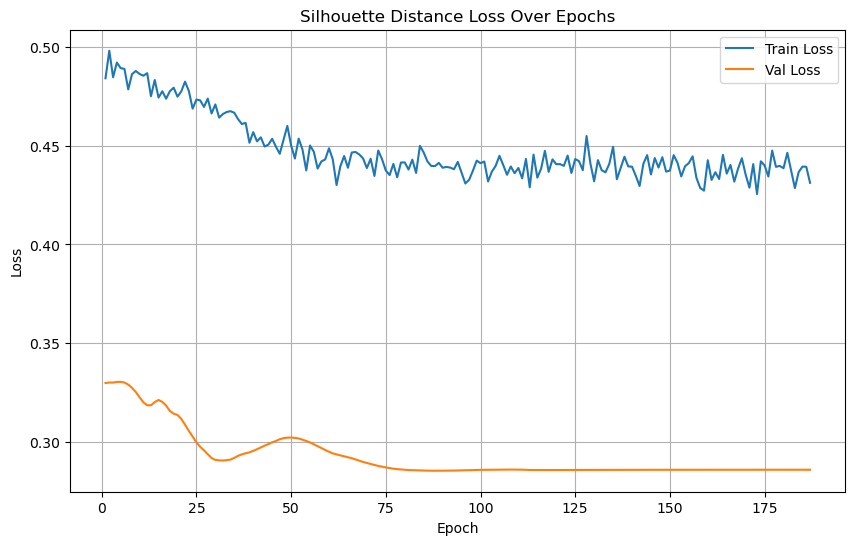

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/49], Loss: 0.2161
Test Batch [20/49], Loss: 0.2984
Test Batch [30/49], Loss: 0.3752
Test Batch [40/49], Loss: 0.2408



Test Loss: 0.3424


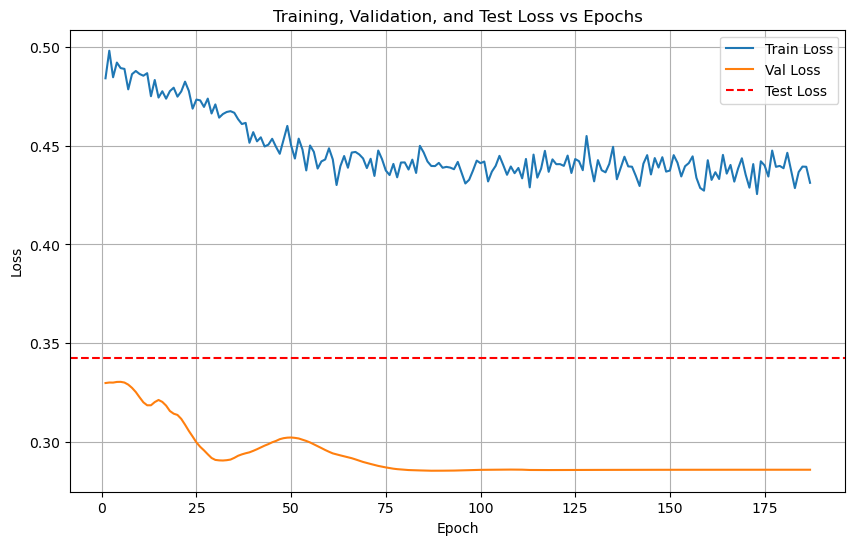

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/49 for test dataset.


  Processed batch 20/49 for test dataset.


  Processed batch 30/49 for test dataset.
  Processed batch 40/49 for test dataset.


Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (70, 128)
Train labels shape: (70,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (3108, 128)
Test labels shape: (3108,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 71.43%

Validation Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         5
           1       0.80      0.80      0.80         5
           2       0.67      0.80      0.73         5
           3       0.67      0.80      0.73         5
           4       0.00      0.00      0.00         5
           5       0.75      0.60      0.67         5
           6       1.00      1.00      1.00         5
           7       0.80      0.80      0.80         5
           8       0.40      0.40      0.40         5
           9       0.38      1.00      0.56         5
          10       1.00      0.80      0.89         5
          11       1.00      1.00      1.00         5
          12       0.00      0.00      0.00         5
          13       1.0

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (70, 128)
Train labels shape: (70,)
Val reps shape: (70, 128)
Val labels shape: (70,)
Test reps shape: (3108, 128)
Test labels shape: (3108,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.6448  |  Val Loss: 2.6309
Validation loss improved from inf to 2.6309.
[Epoch 2/1000] Train Loss: 2.6376  |  Val Loss: 2.6256
Validation loss improved from 2.6309 to 2.6256.
[Epoch 3/1000] Train Loss: 2.6315  |  Val Loss: 2.6206
Validation loss improved from 2.6256 to 2.6206.
[Epoch 4/1000] Train Loss: 2.6265  |  Val Loss: 2.6158
Validation loss improved from 2.6206 to 2.6158.
[Epoch 5/1000] Train Loss: 2.6213  |  Val Loss: 2.6116
Validation loss improved from 2.6158 to 2.6116.
[Epoch 6/1000] Train Loss: 2.6162  |  Val Loss: 2.6076
Validation loss improved from 2.6116 to 2.6076.
[Epoch 7/1000] Train Loss: 2.6119  |  Val Loss: 2.6037
Validation loss improved from 2.6076 to 2.6037.
[Epoch 8/1000] Train Loss: 2.6071  |  Val Loss: 2.5998
Validation loss improved from 2.6037 to 2.5998.
[Epoch 9/1000] Train Loss: 2.6030  |  Val Loss: 2.5958
Validation loss improved from 2.5998 to 2.5958.
[Epoch 10/1000] Train Loss: 2.5987  |  Val Loss: 2.5921
Validation loss impr

[Epoch 23/1000] Train Loss: 2.5512  |  Val Loss: 2.5505
Validation loss improved from 2.5537 to 2.5505.
[Epoch 24/1000] Train Loss: 2.5470  |  Val Loss: 2.5472
Validation loss improved from 2.5505 to 2.5472.
[Epoch 25/1000] Train Loss: 2.5431  |  Val Loss: 2.5438
Validation loss improved from 2.5472 to 2.5438.
[Epoch 26/1000] Train Loss: 2.5388  |  Val Loss: 2.5403
Validation loss improved from 2.5438 to 2.5403.
[Epoch 27/1000] Train Loss: 2.5344  |  Val Loss: 2.5366
Validation loss improved from 2.5403 to 2.5366.
[Epoch 28/1000] Train Loss: 2.5301  |  Val Loss: 2.5328
Validation loss improved from 2.5366 to 2.5328.
[Epoch 29/1000] Train Loss: 2.5257  |  Val Loss: 2.5291
Validation loss improved from 2.5328 to 2.5291.
[Epoch 30/1000] Train Loss: 2.5213  |  Val Loss: 2.5254
Validation loss improved from 2.5291 to 2.5254.
[Epoch 31/1000] Train Loss: 2.5167  |  Val Loss: 2.5216
Validation loss improved from 2.5254 to 2.5216.
[Epoch 32/1000] Train Loss: 2.5123  |  Val Loss: 2.5176
Validati

[Epoch 35/1000] Train Loss: 2.4985  |  Val Loss: 2.5059
Validation loss improved from 2.5097 to 2.5059.
[Epoch 36/1000] Train Loss: 2.4941  |  Val Loss: 2.5021
Validation loss improved from 2.5059 to 2.5021.
[Epoch 37/1000] Train Loss: 2.4899  |  Val Loss: 2.4984
Validation loss improved from 2.5021 to 2.4984.
[Epoch 38/1000] Train Loss: 2.4855  |  Val Loss: 2.4948
Validation loss improved from 2.4984 to 2.4948.
[Epoch 39/1000] Train Loss: 2.4811  |  Val Loss: 2.4912
Validation loss improved from 2.4948 to 2.4912.
[Epoch 40/1000] Train Loss: 2.4771  |  Val Loss: 2.4875
Validation loss improved from 2.4912 to 2.4875.
[Epoch 41/1000] Train Loss: 2.4726  |  Val Loss: 2.4839
Validation loss improved from 2.4875 to 2.4839.
[Epoch 42/1000] Train Loss: 2.4683  |  Val Loss: 2.4802
Validation loss improved from 2.4839 to 2.4802.
[Epoch 43/1000] Train Loss: 2.4638  |  Val Loss: 2.4761
Validation loss improved from 2.4802 to 2.4761.
[Epoch 44/1000] Train Loss: 2.4592  |  Val Loss: 2.4719
Validati

[Epoch 65/1000] Train Loss: 2.3587  |  Val Loss: 2.3840
Validation loss improved from 2.3883 to 2.3840.
[Epoch 66/1000] Train Loss: 2.3535  |  Val Loss: 2.3797
Validation loss improved from 2.3840 to 2.3797.
[Epoch 67/1000] Train Loss: 2.3484  |  Val Loss: 2.3754
Validation loss improved from 2.3797 to 2.3754.
[Epoch 68/1000] Train Loss: 2.3432  |  Val Loss: 2.3712
Validation loss improved from 2.3754 to 2.3712.
[Epoch 69/1000] Train Loss: 2.3381  |  Val Loss: 2.3672
Validation loss improved from 2.3712 to 2.3672.
[Epoch 70/1000] Train Loss: 2.3331  |  Val Loss: 2.3633
Validation loss improved from 2.3672 to 2.3633.
[Epoch 71/1000] Train Loss: 2.3283  |  Val Loss: 2.3594
Validation loss improved from 2.3633 to 2.3594.
[Epoch 72/1000] Train Loss: 2.3234  |  Val Loss: 2.3552
Validation loss improved from 2.3594 to 2.3552.
[Epoch 73/1000] Train Loss: 2.3186  |  Val Loss: 2.3508
Validation loss improved from 2.3552 to 2.3508.
[Epoch 74/1000] Train Loss: 2.3131  |  Val Loss: 2.3465
Validati

[Epoch 77/1000] Train Loss: 2.2976  |  Val Loss: 2.3330
Validation loss improved from 2.3375 to 2.3330.
[Epoch 78/1000] Train Loss: 2.2923  |  Val Loss: 2.3286
Validation loss improved from 2.3330 to 2.3286.
[Epoch 79/1000] Train Loss: 2.2871  |  Val Loss: 2.3244
Validation loss improved from 2.3286 to 2.3244.
[Epoch 80/1000] Train Loss: 2.2823  |  Val Loss: 2.3202
Validation loss improved from 2.3244 to 2.3202.
[Epoch 81/1000] Train Loss: 2.2771  |  Val Loss: 2.3160
Validation loss improved from 2.3202 to 2.3160.
[Epoch 82/1000] Train Loss: 2.2724  |  Val Loss: 2.3118
Validation loss improved from 2.3160 to 2.3118.
[Epoch 83/1000] Train Loss: 2.2674  |  Val Loss: 2.3077
Validation loss improved from 2.3118 to 2.3077.
[Epoch 84/1000] Train Loss: 2.2627  |  Val Loss: 2.3037
Validation loss improved from 2.3077 to 2.3037.
[Epoch 85/1000] Train Loss: 2.2578  |  Val Loss: 2.2997
Validation loss improved from 2.3037 to 2.2997.
[Epoch 86/1000] Train Loss: 2.2534  |  Val Loss: 2.2957
Validati

[Epoch 106/1000] Train Loss: 2.1618  |  Val Loss: 2.2181
Validation loss improved from 2.2222 to 2.2181.
[Epoch 107/1000] Train Loss: 2.1571  |  Val Loss: 2.2141
Validation loss improved from 2.2181 to 2.2141.
[Epoch 108/1000] Train Loss: 2.1523  |  Val Loss: 2.2100
Validation loss improved from 2.2141 to 2.2100.
[Epoch 109/1000] Train Loss: 2.1476  |  Val Loss: 2.2060
Validation loss improved from 2.2100 to 2.2060.
[Epoch 110/1000] Train Loss: 2.1430  |  Val Loss: 2.2021
Validation loss improved from 2.2060 to 2.2021.
[Epoch 111/1000] Train Loss: 2.1382  |  Val Loss: 2.1985
Validation loss improved from 2.2021 to 2.1985.
[Epoch 112/1000] Train Loss: 2.1336  |  Val Loss: 2.1950
Validation loss improved from 2.1985 to 2.1950.
[Epoch 113/1000] Train Loss: 2.1291  |  Val Loss: 2.1915
Validation loss improved from 2.1950 to 2.1915.
[Epoch 114/1000] Train Loss: 2.1248  |  Val Loss: 2.1881
Validation loss improved from 2.1915 to 2.1881.
[Epoch 115/1000] Train Loss: 2.1205  |  Val Loss: 2.184

[Epoch 118/1000] Train Loss: 2.1076  |  Val Loss: 2.1746
Validation loss improved from 2.1780 to 2.1746.
[Epoch 119/1000] Train Loss: 2.1032  |  Val Loss: 2.1711
Validation loss improved from 2.1746 to 2.1711.
[Epoch 120/1000] Train Loss: 2.0988  |  Val Loss: 2.1677
Validation loss improved from 2.1711 to 2.1677.
[Epoch 121/1000] Train Loss: 2.0943  |  Val Loss: 2.1644
Validation loss improved from 2.1677 to 2.1644.
[Epoch 122/1000] Train Loss: 2.0899  |  Val Loss: 2.1610
Validation loss improved from 2.1644 to 2.1610.
[Epoch 123/1000] Train Loss: 2.0854  |  Val Loss: 2.1576
Validation loss improved from 2.1610 to 2.1576.
[Epoch 124/1000] Train Loss: 2.0808  |  Val Loss: 2.1541
Validation loss improved from 2.1576 to 2.1541.
[Epoch 125/1000] Train Loss: 2.0763  |  Val Loss: 2.1505
Validation loss improved from 2.1541 to 2.1505.
[Epoch 126/1000] Train Loss: 2.0716  |  Val Loss: 2.1470
Validation loss improved from 2.1505 to 2.1470.
[Epoch 127/1000] Train Loss: 2.0670  |  Val Loss: 2.143

[Epoch 145/1000] Train Loss: 1.9789  |  Val Loss: 2.0734
Validation loss improved from 2.0778 to 2.0734.
[Epoch 146/1000] Train Loss: 1.9737  |  Val Loss: 2.0690
Validation loss improved from 2.0734 to 2.0690.
[Epoch 147/1000] Train Loss: 1.9683  |  Val Loss: 2.0646
Validation loss improved from 2.0690 to 2.0646.
[Epoch 148/1000] Train Loss: 1.9632  |  Val Loss: 2.0605
Validation loss improved from 2.0646 to 2.0605.
[Epoch 149/1000] Train Loss: 1.9581  |  Val Loss: 2.0564
Validation loss improved from 2.0605 to 2.0564.
[Epoch 150/1000] Train Loss: 1.9531  |  Val Loss: 2.0524
Validation loss improved from 2.0564 to 2.0524.
[Epoch 151/1000] Train Loss: 1.9482  |  Val Loss: 2.0484
Validation loss improved from 2.0524 to 2.0484.
[Epoch 152/1000] Train Loss: 1.9432  |  Val Loss: 2.0444
Validation loss improved from 2.0484 to 2.0444.
[Epoch 153/1000] Train Loss: 1.9381  |  Val Loss: 2.0404
Validation loss improved from 2.0444 to 2.0404.
[Epoch 154/1000] Train Loss: 1.9330  |  Val Loss: 2.036

[Epoch 160/1000] Train Loss: 1.9016  |  Val Loss: 2.0125
Validation loss improved from 2.0166 to 2.0125.
[Epoch 161/1000] Train Loss: 1.8962  |  Val Loss: 2.0084
Validation loss improved from 2.0125 to 2.0084.
[Epoch 162/1000] Train Loss: 1.8911  |  Val Loss: 2.0042
Validation loss improved from 2.0084 to 2.0042.
[Epoch 163/1000] Train Loss: 1.8856  |  Val Loss: 1.9999
Validation loss improved from 2.0042 to 1.9999.
[Epoch 164/1000] Train Loss: 1.8804  |  Val Loss: 1.9958
Validation loss improved from 1.9999 to 1.9958.
[Epoch 165/1000] Train Loss: 1.8750  |  Val Loss: 1.9918
Validation loss improved from 1.9958 to 1.9918.
[Epoch 166/1000] Train Loss: 1.8697  |  Val Loss: 1.9879
Validation loss improved from 1.9918 to 1.9879.
[Epoch 167/1000] Train Loss: 1.8644  |  Val Loss: 1.9839
Validation loss improved from 1.9879 to 1.9839.
[Epoch 168/1000] Train Loss: 1.8592  |  Val Loss: 1.9799
Validation loss improved from 1.9839 to 1.9799.
[Epoch 169/1000] Train Loss: 1.8536  |  Val Loss: 1.975

[Epoch 185/1000] Train Loss: 1.7676  |  Val Loss: 1.9102
Validation loss improved from 1.9146 to 1.9102.
[Epoch 186/1000] Train Loss: 1.7622  |  Val Loss: 1.9058
Validation loss improved from 1.9102 to 1.9058.
[Epoch 187/1000] Train Loss: 1.7564  |  Val Loss: 1.9015
Validation loss improved from 1.9058 to 1.9015.
[Epoch 188/1000] Train Loss: 1.7508  |  Val Loss: 1.8972
Validation loss improved from 1.9015 to 1.8972.
[Epoch 189/1000] Train Loss: 1.7451  |  Val Loss: 1.8929
Validation loss improved from 1.8972 to 1.8929.
[Epoch 190/1000] Train Loss: 1.7396  |  Val Loss: 1.8887
Validation loss improved from 1.8929 to 1.8887.
[Epoch 191/1000] Train Loss: 1.7339  |  Val Loss: 1.8844
Validation loss improved from 1.8887 to 1.8844.
[Epoch 192/1000] Train Loss: 1.7282  |  Val Loss: 1.8800
Validation loss improved from 1.8844 to 1.8800.
[Epoch 193/1000] Train Loss: 1.7228  |  Val Loss: 1.8756
Validation loss improved from 1.8800 to 1.8756.
[Epoch 194/1000] Train Loss: 1.7170  |  Val Loss: 1.871

[Epoch 201/1000] Train Loss: 1.6785  |  Val Loss: 1.8418
Validation loss improved from 1.8460 to 1.8418.
[Epoch 202/1000] Train Loss: 1.6733  |  Val Loss: 1.8375
Validation loss improved from 1.8418 to 1.8375.
[Epoch 203/1000] Train Loss: 1.6678  |  Val Loss: 1.8333
Validation loss improved from 1.8375 to 1.8333.
[Epoch 204/1000] Train Loss: 1.6625  |  Val Loss: 1.8288
Validation loss improved from 1.8333 to 1.8288.
[Epoch 205/1000] Train Loss: 1.6573  |  Val Loss: 1.8243
Validation loss improved from 1.8288 to 1.8243.
[Epoch 206/1000] Train Loss: 1.6517  |  Val Loss: 1.8198
Validation loss improved from 1.8243 to 1.8198.
[Epoch 207/1000] Train Loss: 1.6459  |  Val Loss: 1.8152
Validation loss improved from 1.8198 to 1.8152.
[Epoch 208/1000] Train Loss: 1.6401  |  Val Loss: 1.8106
Validation loss improved from 1.8152 to 1.8106.
[Epoch 209/1000] Train Loss: 1.6344  |  Val Loss: 1.8062
Validation loss improved from 1.8106 to 1.8062.
[Epoch 210/1000] Train Loss: 1.6285  |  Val Loss: 1.801

[Epoch 230/1000] Train Loss: 1.5123  |  Val Loss: 1.7085
Validation loss improved from 1.7130 to 1.7085.
[Epoch 231/1000] Train Loss: 1.5066  |  Val Loss: 1.7039
Validation loss improved from 1.7085 to 1.7039.
[Epoch 232/1000] Train Loss: 1.5010  |  Val Loss: 1.6993
Validation loss improved from 1.7039 to 1.6993.
[Epoch 233/1000] Train Loss: 1.4954  |  Val Loss: 1.6947
Validation loss improved from 1.6993 to 1.6947.
[Epoch 234/1000] Train Loss: 1.4898  |  Val Loss: 1.6902
Validation loss improved from 1.6947 to 1.6902.
[Epoch 235/1000] Train Loss: 1.4842  |  Val Loss: 1.6856
Validation loss improved from 1.6902 to 1.6856.
[Epoch 236/1000] Train Loss: 1.4785  |  Val Loss: 1.6811
Validation loss improved from 1.6856 to 1.6811.
[Epoch 237/1000] Train Loss: 1.4729  |  Val Loss: 1.6765
Validation loss improved from 1.6811 to 1.6765.
[Epoch 238/1000] Train Loss: 1.4673  |  Val Loss: 1.6720
Validation loss improved from 1.6765 to 1.6720.
[Epoch 239/1000] Train Loss: 1.4619  |  Val Loss: 1.667

[Epoch 245/1000] Train Loss: 1.4284  |  Val Loss: 1.6411
Validation loss improved from 1.6454 to 1.6411.
[Epoch 246/1000] Train Loss: 1.4229  |  Val Loss: 1.6367
Validation loss improved from 1.6411 to 1.6367.
[Epoch 247/1000] Train Loss: 1.4176  |  Val Loss: 1.6325
Validation loss improved from 1.6367 to 1.6325.
[Epoch 248/1000] Train Loss: 1.4122  |  Val Loss: 1.6283
Validation loss improved from 1.6325 to 1.6283.
[Epoch 249/1000] Train Loss: 1.4071  |  Val Loss: 1.6240
Validation loss improved from 1.6283 to 1.6240.
[Epoch 250/1000] Train Loss: 1.4020  |  Val Loss: 1.6199
Validation loss improved from 1.6240 to 1.6199.
[Epoch 251/1000] Train Loss: 1.3967  |  Val Loss: 1.6157
Validation loss improved from 1.6199 to 1.6157.
[Epoch 252/1000] Train Loss: 1.3917  |  Val Loss: 1.6116
Validation loss improved from 1.6157 to 1.6116.
[Epoch 253/1000] Train Loss: 1.3864  |  Val Loss: 1.6075
Validation loss improved from 1.6116 to 1.6075.
[Epoch 254/1000] Train Loss: 1.3815  |  Val Loss: 1.603

[Epoch 271/1000] Train Loss: 1.2936  |  Val Loss: 1.5318
Validation loss improved from 1.5361 to 1.5318.
[Epoch 272/1000] Train Loss: 1.2885  |  Val Loss: 1.5277
Validation loss improved from 1.5318 to 1.5277.
[Epoch 273/1000] Train Loss: 1.2834  |  Val Loss: 1.5236
Validation loss improved from 1.5277 to 1.5236.
[Epoch 274/1000] Train Loss: 1.2785  |  Val Loss: 1.5195
Validation loss improved from 1.5236 to 1.5195.
[Epoch 275/1000] Train Loss: 1.2735  |  Val Loss: 1.5155
Validation loss improved from 1.5195 to 1.5155.
[Epoch 276/1000] Train Loss: 1.2685  |  Val Loss: 1.5115
Validation loss improved from 1.5155 to 1.5115.
[Epoch 277/1000] Train Loss: 1.2635  |  Val Loss: 1.5076
Validation loss improved from 1.5115 to 1.5076.
[Epoch 278/1000] Train Loss: 1.2584  |  Val Loss: 1.5037
Validation loss improved from 1.5076 to 1.5037.
[Epoch 279/1000] Train Loss: 1.2533  |  Val Loss: 1.4997
Validation loss improved from 1.5037 to 1.4997.
[Epoch 280/1000] Train Loss: 1.2479  |  Val Loss: 1.495

[Epoch 283/1000] Train Loss: 1.2325  |  Val Loss: 1.4836
Validation loss improved from 1.4875 to 1.4836.
[Epoch 284/1000] Train Loss: 1.2276  |  Val Loss: 1.4798
Validation loss improved from 1.4836 to 1.4798.
[Epoch 285/1000] Train Loss: 1.2229  |  Val Loss: 1.4760
Validation loss improved from 1.4798 to 1.4760.
[Epoch 286/1000] Train Loss: 1.2181  |  Val Loss: 1.4723
Validation loss improved from 1.4760 to 1.4723.
[Epoch 287/1000] Train Loss: 1.2133  |  Val Loss: 1.4686
Validation loss improved from 1.4723 to 1.4686.
[Epoch 288/1000] Train Loss: 1.2085  |  Val Loss: 1.4650
Validation loss improved from 1.4686 to 1.4650.
[Epoch 289/1000] Train Loss: 1.2038  |  Val Loss: 1.4612
Validation loss improved from 1.4650 to 1.4612.
[Epoch 290/1000] Train Loss: 1.1989  |  Val Loss: 1.4574
Validation loss improved from 1.4612 to 1.4574.
[Epoch 291/1000] Train Loss: 1.1940  |  Val Loss: 1.4536
Validation loss improved from 1.4574 to 1.4536.
[Epoch 292/1000] Train Loss: 1.1893  |  Val Loss: 1.449

[Epoch 313/1000] Train Loss: 1.0871  |  Val Loss: 1.3740
Validation loss improved from 1.3776 to 1.3740.
[Epoch 314/1000] Train Loss: 1.0821  |  Val Loss: 1.3705
Validation loss improved from 1.3740 to 1.3705.
[Epoch 315/1000] Train Loss: 1.0771  |  Val Loss: 1.3669
Validation loss improved from 1.3705 to 1.3669.
[Epoch 316/1000] Train Loss: 1.0724  |  Val Loss: 1.3634
Validation loss improved from 1.3669 to 1.3634.
[Epoch 317/1000] Train Loss: 1.0677  |  Val Loss: 1.3598
Validation loss improved from 1.3634 to 1.3598.
[Epoch 318/1000] Train Loss: 1.0629  |  Val Loss: 1.3559
Validation loss improved from 1.3598 to 1.3559.
[Epoch 319/1000] Train Loss: 1.0582  |  Val Loss: 1.3521
Validation loss improved from 1.3559 to 1.3521.
[Epoch 320/1000] Train Loss: 1.0533  |  Val Loss: 1.3483
Validation loss improved from 1.3521 to 1.3483.
[Epoch 321/1000] Train Loss: 1.0484  |  Val Loss: 1.3447
Validation loss improved from 1.3483 to 1.3447.
[Epoch 322/1000] Train Loss: 1.0436  |  Val Loss: 1.341

[Epoch 324/1000] Train Loss: 1.0341  |  Val Loss: 1.3347
Validation loss improved from 1.3380 to 1.3347.
[Epoch 325/1000] Train Loss: 1.0295  |  Val Loss: 1.3316
Validation loss improved from 1.3347 to 1.3316.
[Epoch 326/1000] Train Loss: 1.0249  |  Val Loss: 1.3284
Validation loss improved from 1.3316 to 1.3284.
[Epoch 327/1000] Train Loss: 1.0201  |  Val Loss: 1.3251
Validation loss improved from 1.3284 to 1.3251.
[Epoch 328/1000] Train Loss: 1.0155  |  Val Loss: 1.3218
Validation loss improved from 1.3251 to 1.3218.
[Epoch 329/1000] Train Loss: 1.0109  |  Val Loss: 1.3184
Validation loss improved from 1.3218 to 1.3184.
[Epoch 330/1000] Train Loss: 1.0062  |  Val Loss: 1.3151
Validation loss improved from 1.3184 to 1.3151.
[Epoch 331/1000] Train Loss: 1.0016  |  Val Loss: 1.3119
Validation loss improved from 1.3151 to 1.3119.
[Epoch 332/1000] Train Loss: 0.9971  |  Val Loss: 1.3088
Validation loss improved from 1.3119 to 1.3088.
[Epoch 333/1000] Train Loss: 0.9927  |  Val Loss: 1.305

[Epoch 352/1000] Train Loss: 0.9083  |  Val Loss: 1.2410
Validation loss improved from 1.2443 to 1.2410.
[Epoch 353/1000] Train Loss: 0.9039  |  Val Loss: 1.2378
Validation loss improved from 1.2410 to 1.2378.
[Epoch 354/1000] Train Loss: 0.8993  |  Val Loss: 1.2347
Validation loss improved from 1.2378 to 1.2347.
[Epoch 355/1000] Train Loss: 0.8949  |  Val Loss: 1.2316
Validation loss improved from 1.2347 to 1.2316.
[Epoch 356/1000] Train Loss: 0.8907  |  Val Loss: 1.2286
Validation loss improved from 1.2316 to 1.2286.
[Epoch 357/1000] Train Loss: 0.8861  |  Val Loss: 1.2256
Validation loss improved from 1.2286 to 1.2256.
[Epoch 358/1000] Train Loss: 0.8819  |  Val Loss: 1.2226
Validation loss improved from 1.2256 to 1.2226.
[Epoch 359/1000] Train Loss: 0.8779  |  Val Loss: 1.2195
Validation loss improved from 1.2226 to 1.2195.
[Epoch 360/1000] Train Loss: 0.8734  |  Val Loss: 1.2162
Validation loss improved from 1.2195 to 1.2162.
[Epoch 361/1000] Train Loss: 0.8692  |  Val Loss: 1.212

[Epoch 363/1000] Train Loss: 0.8607  |  Val Loss: 1.2058
Validation loss improved from 1.2093 to 1.2058.
[Epoch 364/1000] Train Loss: 0.8563  |  Val Loss: 1.2025
Validation loss improved from 1.2058 to 1.2025.
[Epoch 365/1000] Train Loss: 0.8520  |  Val Loss: 1.1992
Validation loss improved from 1.2025 to 1.1992.
[Epoch 366/1000] Train Loss: 0.8480  |  Val Loss: 1.1959
Validation loss improved from 1.1992 to 1.1959.
[Epoch 367/1000] Train Loss: 0.8438  |  Val Loss: 1.1929
Validation loss improved from 1.1959 to 1.1929.
[Epoch 368/1000] Train Loss: 0.8396  |  Val Loss: 1.1899
Validation loss improved from 1.1929 to 1.1899.
[Epoch 369/1000] Train Loss: 0.8354  |  Val Loss: 1.1867
Validation loss improved from 1.1899 to 1.1867.
[Epoch 370/1000] Train Loss: 0.8310  |  Val Loss: 1.1835
Validation loss improved from 1.1867 to 1.1835.
[Epoch 371/1000] Train Loss: 0.8265  |  Val Loss: 1.1805
Validation loss improved from 1.1835 to 1.1805.
[Epoch 372/1000] Train Loss: 0.8225  |  Val Loss: 1.177

[Epoch 396/1000] Train Loss: 0.7261  |  Val Loss: 1.1075
Validation loss improved from 1.1101 to 1.1075.
[Epoch 397/1000] Train Loss: 0.7226  |  Val Loss: 1.1047
Validation loss improved from 1.1075 to 1.1047.
[Epoch 398/1000] Train Loss: 0.7190  |  Val Loss: 1.1021
Validation loss improved from 1.1047 to 1.1021.
[Epoch 399/1000] Train Loss: 0.7153  |  Val Loss: 1.0994
Validation loss improved from 1.1021 to 1.0994.
[Epoch 400/1000] Train Loss: 0.7117  |  Val Loss: 1.0965
Validation loss improved from 1.0994 to 1.0965.
[Epoch 401/1000] Train Loss: 0.7080  |  Val Loss: 1.0936
Validation loss improved from 1.0965 to 1.0936.
[Epoch 402/1000] Train Loss: 0.7041  |  Val Loss: 1.0907
Validation loss improved from 1.0936 to 1.0907.
[Epoch 403/1000] Train Loss: 0.7002  |  Val Loss: 1.0878
Validation loss improved from 1.0907 to 1.0878.
[Epoch 404/1000] Train Loss: 0.6966  |  Val Loss: 1.0852
Validation loss improved from 1.0878 to 1.0852.


[Epoch 405/1000] Train Loss: 0.6926  |  Val Loss: 1.0827
Validation loss improved from 1.0852 to 1.0827.
[Epoch 406/1000] Train Loss: 0.6893  |  Val Loss: 1.0802
Validation loss improved from 1.0827 to 1.0802.
[Epoch 407/1000] Train Loss: 0.6859  |  Val Loss: 1.0779
Validation loss improved from 1.0802 to 1.0779.
[Epoch 408/1000] Train Loss: 0.6821  |  Val Loss: 1.0756
Validation loss improved from 1.0779 to 1.0756.
[Epoch 409/1000] Train Loss: 0.6789  |  Val Loss: 1.0732
Validation loss improved from 1.0756 to 1.0732.
[Epoch 410/1000] Train Loss: 0.6752  |  Val Loss: 1.0706
Validation loss improved from 1.0732 to 1.0706.
[Epoch 411/1000] Train Loss: 0.6720  |  Val Loss: 1.0680
Validation loss improved from 1.0706 to 1.0680.
[Epoch 412/1000] Train Loss: 0.6687  |  Val Loss: 1.0656
Validation loss improved from 1.0680 to 1.0656.
[Epoch 413/1000] Train Loss: 0.6654  |  Val Loss: 1.0633
Validation loss improved from 1.0656 to 1.0633.
[Epoch 414/1000] Train Loss: 0.6619  |  Val Loss: 1.061

[Epoch 437/1000] Train Loss: 0.5891  |  Val Loss: 1.0087
Validation loss improved from 1.0110 to 1.0087.
[Epoch 438/1000] Train Loss: 0.5856  |  Val Loss: 1.0064
Validation loss improved from 1.0087 to 1.0064.
[Epoch 439/1000] Train Loss: 0.5824  |  Val Loss: 1.0043
Validation loss improved from 1.0064 to 1.0043.
[Epoch 440/1000] Train Loss: 0.5793  |  Val Loss: 1.0023
Validation loss improved from 1.0043 to 1.0023.
[Epoch 441/1000] Train Loss: 0.5763  |  Val Loss: 1.0001
Validation loss improved from 1.0023 to 1.0001.
[Epoch 442/1000] Train Loss: 0.5733  |  Val Loss: 0.9978
Validation loss improved from 1.0001 to 0.9978.
[Epoch 443/1000] Train Loss: 0.5703  |  Val Loss: 0.9956
Validation loss improved from 0.9978 to 0.9956.
[Epoch 444/1000] Train Loss: 0.5674  |  Val Loss: 0.9934
Validation loss improved from 0.9956 to 0.9934.
[Epoch 445/1000] Train Loss: 0.5646  |  Val Loss: 0.9912
Validation loss improved from 0.9934 to 0.9912.


[Epoch 446/1000] Train Loss: 0.5616  |  Val Loss: 0.9894
Validation loss improved from 0.9912 to 0.9894.
[Epoch 447/1000] Train Loss: 0.5588  |  Val Loss: 0.9877
Validation loss improved from 0.9894 to 0.9877.
[Epoch 448/1000] Train Loss: 0.5560  |  Val Loss: 0.9859
Validation loss improved from 0.9877 to 0.9859.
[Epoch 449/1000] Train Loss: 0.5533  |  Val Loss: 0.9842
Validation loss improved from 0.9859 to 0.9842.
[Epoch 450/1000] Train Loss: 0.5506  |  Val Loss: 0.9825
Validation loss improved from 0.9842 to 0.9825.
[Epoch 451/1000] Train Loss: 0.5478  |  Val Loss: 0.9807
Validation loss improved from 0.9825 to 0.9807.
[Epoch 452/1000] Train Loss: 0.5450  |  Val Loss: 0.9789
Validation loss improved from 0.9807 to 0.9789.
[Epoch 453/1000] Train Loss: 0.5424  |  Val Loss: 0.9771
Validation loss improved from 0.9789 to 0.9771.
[Epoch 454/1000] Train Loss: 0.5398  |  Val Loss: 0.9751
Validation loss improved from 0.9771 to 0.9751.
[Epoch 455/1000] Train Loss: 0.5373  |  Val Loss: 0.973

[Epoch 479/1000] Train Loss: 0.4770  |  Val Loss: 0.9325
Validation loss improved from 0.9343 to 0.9325.
[Epoch 480/1000] Train Loss: 0.4745  |  Val Loss: 0.9306
Validation loss improved from 0.9325 to 0.9306.
[Epoch 481/1000] Train Loss: 0.4722  |  Val Loss: 0.9286
Validation loss improved from 0.9306 to 0.9286.
[Epoch 482/1000] Train Loss: 0.4703  |  Val Loss: 0.9264
Validation loss improved from 0.9286 to 0.9264.
[Epoch 483/1000] Train Loss: 0.4682  |  Val Loss: 0.9244
Validation loss improved from 0.9264 to 0.9244.
[Epoch 484/1000] Train Loss: 0.4663  |  Val Loss: 0.9225
Validation loss improved from 0.9244 to 0.9225.
[Epoch 485/1000] Train Loss: 0.4642  |  Val Loss: 0.9208
Validation loss improved from 0.9225 to 0.9208.


[Epoch 486/1000] Train Loss: 0.4621  |  Val Loss: 0.9190
Validation loss improved from 0.9208 to 0.9190.
[Epoch 487/1000] Train Loss: 0.4601  |  Val Loss: 0.9174
Validation loss improved from 0.9190 to 0.9174.
[Epoch 488/1000] Train Loss: 0.4580  |  Val Loss: 0.9160
Validation loss improved from 0.9174 to 0.9160.
[Epoch 489/1000] Train Loss: 0.4558  |  Val Loss: 0.9147
Validation loss improved from 0.9160 to 0.9147.
[Epoch 490/1000] Train Loss: 0.4536  |  Val Loss: 0.9134
Validation loss improved from 0.9147 to 0.9134.
[Epoch 491/1000] Train Loss: 0.4514  |  Val Loss: 0.9121
Validation loss improved from 0.9134 to 0.9121.
[Epoch 492/1000] Train Loss: 0.4490  |  Val Loss: 0.9111
Validation loss improved from 0.9121 to 0.9111.
[Epoch 493/1000] Train Loss: 0.4467  |  Val Loss: 0.9102
Validation loss improved from 0.9111 to 0.9102.
[Epoch 494/1000] Train Loss: 0.4445  |  Val Loss: 0.9094
Validation loss improved from 0.9102 to 0.9094.
[Epoch 495/1000] Train Loss: 0.4422  |  Val Loss: 0.908

[Epoch 516/1000] Train Loss: 0.4010  |  Val Loss: 0.8874
Validation loss improved from 0.8882 to 0.8874.
[Epoch 517/1000] Train Loss: 0.3992  |  Val Loss: 0.8864
Validation loss improved from 0.8874 to 0.8864.
[Epoch 518/1000] Train Loss: 0.3973  |  Val Loss: 0.8853
Validation loss improved from 0.8864 to 0.8853.
[Epoch 519/1000] Train Loss: 0.3955  |  Val Loss: 0.8844
Validation loss improved from 0.8853 to 0.8844.
[Epoch 520/1000] Train Loss: 0.3937  |  Val Loss: 0.8836
Validation loss improved from 0.8844 to 0.8836.
[Epoch 521/1000] Train Loss: 0.3919  |  Val Loss: 0.8827
Validation loss improved from 0.8836 to 0.8827.
[Epoch 522/1000] Train Loss: 0.3901  |  Val Loss: 0.8818
Validation loss improved from 0.8827 to 0.8818.
[Epoch 523/1000] Train Loss: 0.3884  |  Val Loss: 0.8810
Validation loss improved from 0.8818 to 0.8810.


[Epoch 524/1000] Train Loss: 0.3868  |  Val Loss: 0.8803
Validation loss improved from 0.8810 to 0.8803.
[Epoch 525/1000] Train Loss: 0.3851  |  Val Loss: 0.8795
Validation loss improved from 0.8803 to 0.8795.
[Epoch 526/1000] Train Loss: 0.3834  |  Val Loss: 0.8786
Validation loss improved from 0.8795 to 0.8786.
[Epoch 527/1000] Train Loss: 0.3818  |  Val Loss: 0.8777
Validation loss improved from 0.8786 to 0.8777.
[Epoch 528/1000] Train Loss: 0.3801  |  Val Loss: 0.8766
Validation loss improved from 0.8777 to 0.8766.
[Epoch 529/1000] Train Loss: 0.3784  |  Val Loss: 0.8755
Validation loss improved from 0.8766 to 0.8755.
[Epoch 530/1000] Train Loss: 0.3768  |  Val Loss: 0.8745
Validation loss improved from 0.8755 to 0.8745.
[Epoch 531/1000] Train Loss: 0.3751  |  Val Loss: 0.8735
Validation loss improved from 0.8745 to 0.8735.
[Epoch 532/1000] Train Loss: 0.3735  |  Val Loss: 0.8725
Validation loss improved from 0.8735 to 0.8725.
[Epoch 533/1000] Train Loss: 0.3720  |  Val Loss: 0.871

[Epoch 562/1000] Train Loss: 0.3273  |  Val Loss: 0.8446
Validation loss improved from 0.8463 to 0.8446.
[Epoch 563/1000] Train Loss: 0.3258  |  Val Loss: 0.8429
Validation loss improved from 0.8446 to 0.8429.
[Epoch 564/1000] Train Loss: 0.3243  |  Val Loss: 0.8412
Validation loss improved from 0.8429 to 0.8412.
[Epoch 565/1000] Train Loss: 0.3230  |  Val Loss: 0.8393
Validation loss improved from 0.8412 to 0.8393.
[Epoch 566/1000] Train Loss: 0.3215  |  Val Loss: 0.8373
Validation loss improved from 0.8393 to 0.8373.
[Epoch 567/1000] Train Loss: 0.3200  |  Val Loss: 0.8354
Validation loss improved from 0.8373 to 0.8354.
[Epoch 568/1000] Train Loss: 0.3187  |  Val Loss: 0.8338
Validation loss improved from 0.8354 to 0.8338.
[Epoch 569/1000] Train Loss: 0.3173  |  Val Loss: 0.8324
Validation loss improved from 0.8338 to 0.8324.
[Epoch 570/1000] Train Loss: 0.3161  |  Val Loss: 0.8310
Validation loss improved from 0.8324 to 0.8310.
[Epoch 571/1000] Train Loss: 0.3146  |  Val Loss: 0.829

[Epoch 604/1000] Train Loss: 0.2759  |  Val Loss: 0.8124
Validation loss improved from 0.8131 to 0.8124.
[Epoch 605/1000] Train Loss: 0.2749  |  Val Loss: 0.8116
Validation loss improved from 0.8124 to 0.8116.
[Epoch 606/1000] Train Loss: 0.2738  |  Val Loss: 0.8111
Validation loss improved from 0.8116 to 0.8111.
[Epoch 607/1000] Train Loss: 0.2728  |  Val Loss: 0.8107
Validation loss improved from 0.8111 to 0.8107.
[Epoch 608/1000] Train Loss: 0.2718  |  Val Loss: 0.8103
Validation loss improved from 0.8107 to 0.8103.
[Epoch 609/1000] Train Loss: 0.2708  |  Val Loss: 0.8099
Validation loss improved from 0.8103 to 0.8099.
[Epoch 610/1000] Train Loss: 0.2699  |  Val Loss: 0.8095
Validation loss improved from 0.8099 to 0.8095.
[Epoch 611/1000] Train Loss: 0.2690  |  Val Loss: 0.8090
Validation loss improved from 0.8095 to 0.8090.
[Epoch 612/1000] Train Loss: 0.2680  |  Val Loss: 0.8084
Validation loss improved from 0.8090 to 0.8084.
[Epoch 613/1000] Train Loss: 0.2671  |  Val Loss: 0.807

[Epoch 648/1000] Train Loss: 0.2363  |  Val Loss: 0.7883
Validation loss improved from 0.7886 to 0.7883.
[Epoch 649/1000] Train Loss: 0.2355  |  Val Loss: 0.7877
Validation loss improved from 0.7883 to 0.7877.
[Epoch 650/1000] Train Loss: 0.2348  |  Val Loss: 0.7873
Validation loss improved from 0.7877 to 0.7873.
[Epoch 651/1000] Train Loss: 0.2340  |  Val Loss: 0.7869
Validation loss improved from 0.7873 to 0.7869.
[Epoch 652/1000] Train Loss: 0.2331  |  Val Loss: 0.7865
Validation loss improved from 0.7869 to 0.7865.
[Epoch 653/1000] Train Loss: 0.2321  |  Val Loss: 0.7860
Validation loss improved from 0.7865 to 0.7860.
[Epoch 654/1000] Train Loss: 0.2312  |  Val Loss: 0.7856
Validation loss improved from 0.7860 to 0.7856.
[Epoch 655/1000] Train Loss: 0.2300  |  Val Loss: 0.7850
Validation loss improved from 0.7856 to 0.7850.
[Epoch 656/1000] Train Loss: 0.2292  |  Val Loss: 0.7843
Validation loss improved from 0.7850 to 0.7843.
[Epoch 657/1000] Train Loss: 0.2280  |  Val Loss: 0.784

[Epoch 692/1000] Train Loss: 0.2000  |  Val Loss: 0.7757
Validation loss improved from 0.7760 to 0.7757.
[Epoch 693/1000] Train Loss: 0.1994  |  Val Loss: 0.7755
Validation loss improved from 0.7757 to 0.7755.
[Epoch 694/1000] Train Loss: 0.1987  |  Val Loss: 0.7753
Validation loss improved from 0.7755 to 0.7753.
[Epoch 695/1000] Train Loss: 0.1980  |  Val Loss: 0.7750
Validation loss improved from 0.7753 to 0.7750.
[Epoch 696/1000] Train Loss: 0.1974  |  Val Loss: 0.7748
Validation loss improved from 0.7750 to 0.7748.
[Epoch 697/1000] Train Loss: 0.1966  |  Val Loss: 0.7745
Validation loss improved from 0.7748 to 0.7745.
[Epoch 698/1000] Train Loss: 0.1960  |  Val Loss: 0.7745
Validation loss improved from 0.7745 to 0.7745.
[Epoch 699/1000] Train Loss: 0.1953  |  Val Loss: 0.7745
Validation loss improved from 0.7745 to 0.7745.
[Epoch 700/1000] Train Loss: 0.1946  |  Val Loss: 0.7742
Validation loss improved from 0.7745 to 0.7742.
[Epoch 701/1000] Train Loss: 0.1940  |  Val Loss: 0.773

[Epoch 730/1000] Train Loss: 0.1765  |  Val Loss: 0.7645
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 731/1000] Train Loss: 0.1759  |  Val Loss: 0.7647
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 732/1000] Train Loss: 0.1753  |  Val Loss: 0.7649
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 733/1000] Train Loss: 0.1747  |  Val Loss: 0.7652
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 734/1000] Train Loss: 0.1743  |  Val Loss: 0.7655
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 735/1000] Train Loss: 0.1736  |  Val Loss: 0.7656
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 736/1000] Train Loss: 0.1730  |  Val Loss: 0.7655
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 737/1000] Train Loss: 0.1722  |  Val Loss: 0.7652
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 738/1000] Train Loss: 0.1716  |  Val Loss: 0.7648
!! Validation loss did NOT improve !! Patience: 9/100
[

[Epoch 771/1000] Train Loss: 0.1546  |  Val Loss: 0.7581
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 772/1000] Train Loss: 0.1538  |  Val Loss: 0.7582
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 773/1000] Train Loss: 0.1532  |  Val Loss: 0.7585
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 774/1000] Train Loss: 0.1526  |  Val Loss: 0.7590
!! Validation loss did NOT improve !! Patience: 17/100
[Epoch 775/1000] Train Loss: 0.1521  |  Val Loss: 0.7597
!! Validation loss did NOT improve !! Patience: 18/100
[Epoch 776/1000] Train Loss: 0.1516  |  Val Loss: 0.7604
!! Validation loss did NOT improve !! Patience: 19/100
[Epoch 777/1000] Train Loss: 0.1512  |  Val Loss: 0.7607
!! Validation loss did NOT improve !! Patience: 20/100
[Epoch 778/1000] Train Loss: 0.1508  |  Val Loss: 0.7609
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 779/1000] Train Loss: 0.1504  |  Val Loss: 0.7611
!! Validation loss did NOT improve !! Patience:

[Epoch 812/1000] Train Loss: 0.1358  |  Val Loss: 0.7619
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 813/1000] Train Loss: 0.1353  |  Val Loss: 0.7609
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 814/1000] Train Loss: 0.1348  |  Val Loss: 0.7601
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 815/1000] Train Loss: 0.1344  |  Val Loss: 0.7595
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 816/1000] Train Loss: 0.1340  |  Val Loss: 0.7592
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 817/1000] Train Loss: 0.1335  |  Val Loss: 0.7592
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 818/1000] Train Loss: 0.1331  |  Val Loss: 0.7596
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 819/1000] Train Loss: 0.1327  |  Val Loss: 0.7604
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 820/1000] Train Loss: 0.1324  |  Val Loss: 0.7608
!! Validation loss did NOT improve !! Patience:

[Epoch 856/1000] Train Loss: 0.1191  |  Val Loss: 0.7491
Validation loss improved from 0.7491 to 0.7491.
[Epoch 857/1000] Train Loss: 0.1188  |  Val Loss: 0.7492
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 858/1000] Train Loss: 0.1184  |  Val Loss: 0.7495
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 859/1000] Train Loss: 0.1182  |  Val Loss: 0.7498
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 860/1000] Train Loss: 0.1178  |  Val Loss: 0.7504
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 861/1000] Train Loss: 0.1176  |  Val Loss: 0.7510
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 862/1000] Train Loss: 0.1172  |  Val Loss: 0.7516
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 863/1000] Train Loss: 0.1168  |  Val Loss: 0.7525
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 864/1000] Train Loss: 0.1166  |  Val Loss: 0.7528
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 

[Epoch 897/1000] Train Loss: 0.1063  |  Val Loss: 0.7433
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 898/1000] Train Loss: 0.1059  |  Val Loss: 0.7437
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 899/1000] Train Loss: 0.1054  |  Val Loss: 0.7441
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 900/1000] Train Loss: 0.1050  |  Val Loss: 0.7446
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 901/1000] Train Loss: 0.1045  |  Val Loss: 0.7450
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 902/1000] Train Loss: 0.1041  |  Val Loss: 0.7455
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 903/1000] Train Loss: 0.1038  |  Val Loss: 0.7461
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 904/1000] Train Loss: 0.1034  |  Val Loss: 0.7468
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 905/1000] Train Loss: 0.1031  |  Val Loss: 0.7479
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 935/1000] Train Loss: 0.0945  |  Val Loss: 0.7548
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 936/1000] Train Loss: 0.0943  |  Val Loss: 0.7545
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 937/1000] Train Loss: 0.0941  |  Val Loss: 0.7540
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 938/1000] Train Loss: 0.0938  |  Val Loss: 0.7538
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 939/1000] Train Loss: 0.0936  |  Val Loss: 0.7537
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 940/1000] Train Loss: 0.0933  |  Val Loss: 0.7539
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 941/1000] Train Loss: 0.0930  |  Val Loss: 0.7542
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 942/1000] Train Loss: 0.0927  |  Val Loss: 0.7546
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 943/1000] Train Loss: 0.0924  |  Val Loss: 0.7550
!! Validation loss did NOT improve !! Patience:

[Epoch 974/1000] Train Loss: 0.0843  |  Val Loss: 0.7596
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 975/1000] Train Loss: 0.0842  |  Val Loss: 0.7599
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 976/1000] Train Loss: 0.0840  |  Val Loss: 0.7599
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 977/1000] Train Loss: 0.0837  |  Val Loss: 0.7599
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 978/1000] Train Loss: 0.0835  |  Val Loss: 0.7603
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 979/1000] Train Loss: 0.0832  |  Val Loss: 0.7608
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 980/1000] Train Loss: 0.0830  |  Val Loss: 0.7611
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 981/1000] Train Loss: 0.0828  |  Val Loss: 0.7608
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 982/1000] Train Loss: 0.0825  |  Val Loss: 0.7603
!! Validation loss did NOT improve !! Patience:

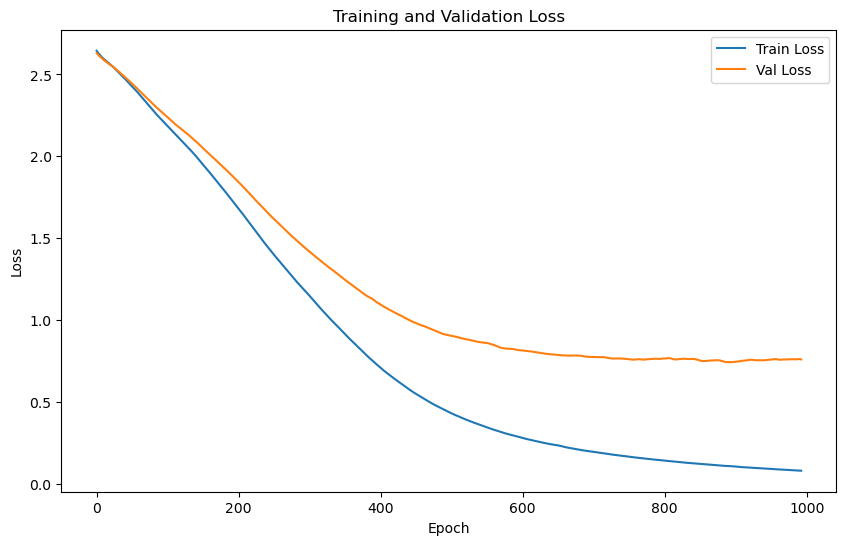

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.7615 | Test Accuracy: 74.20%


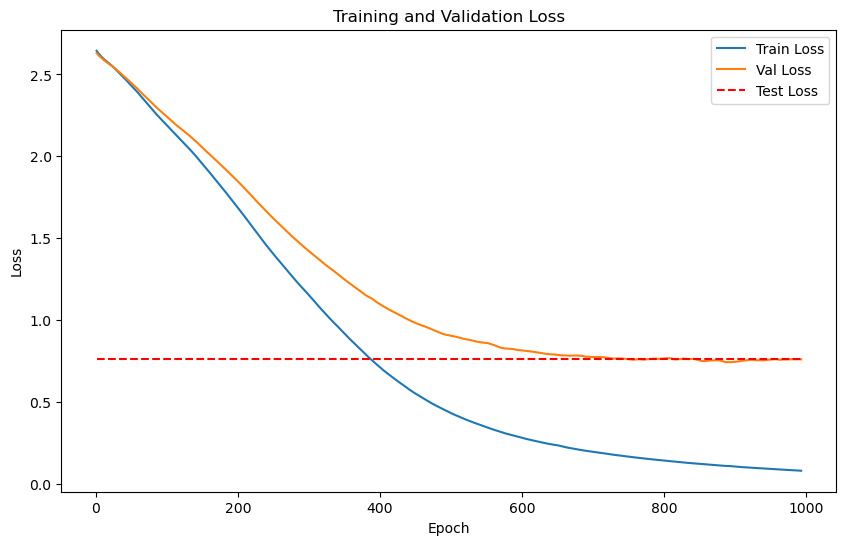

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


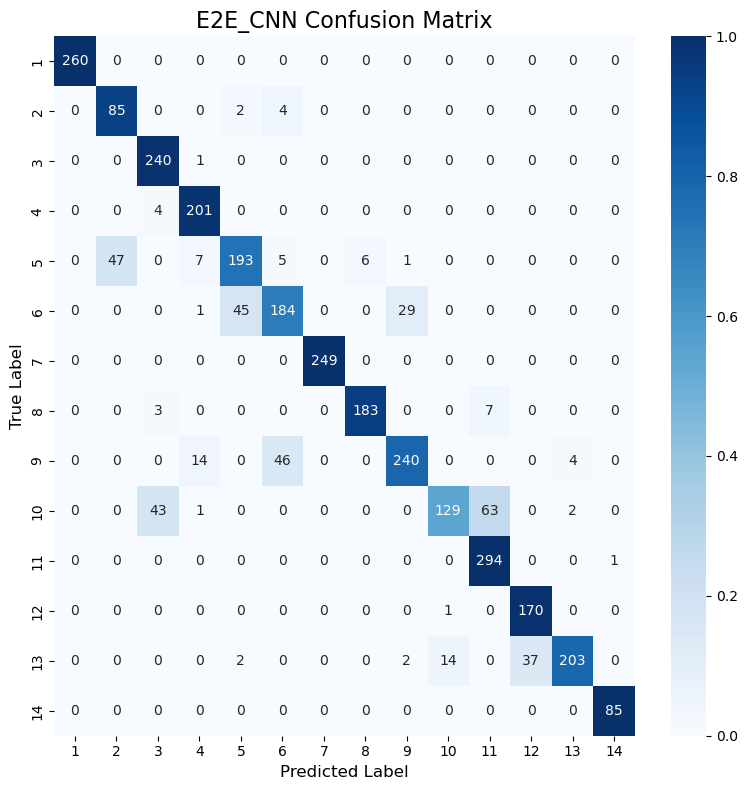

Classification Accuracy: 87.39%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


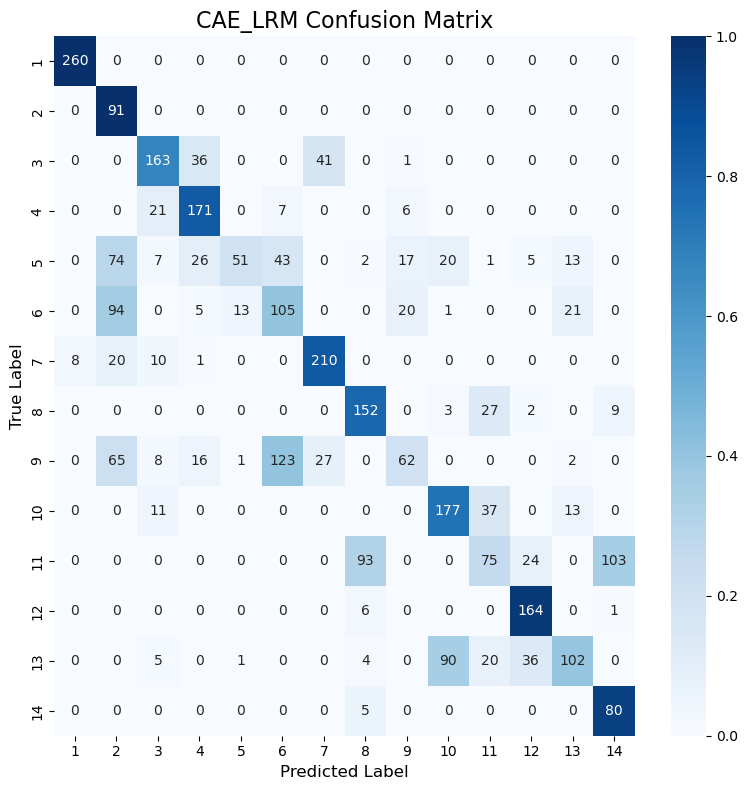

Classification Accuracy: 59.94%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


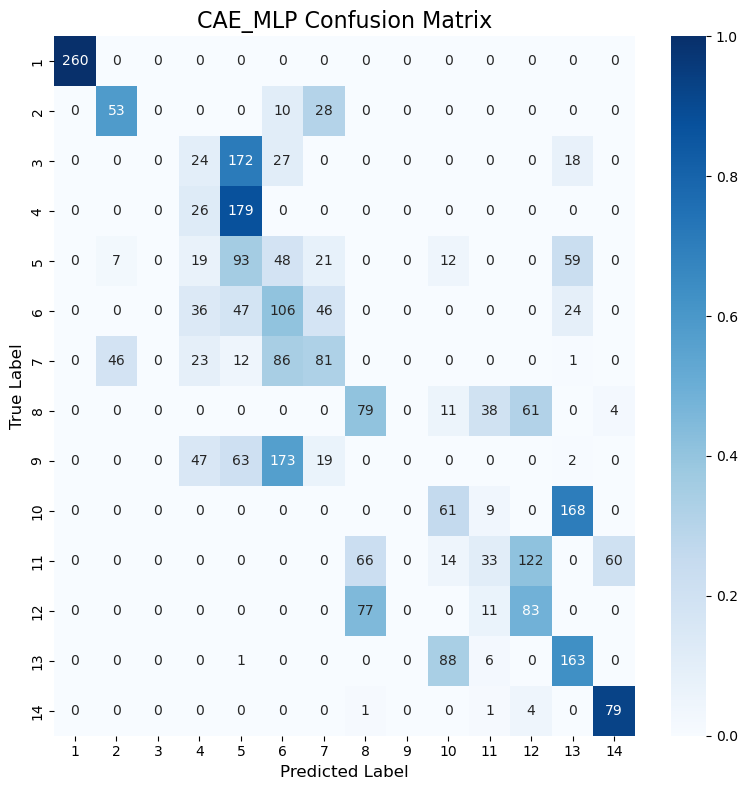

Classification Accuracy: 35.94%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


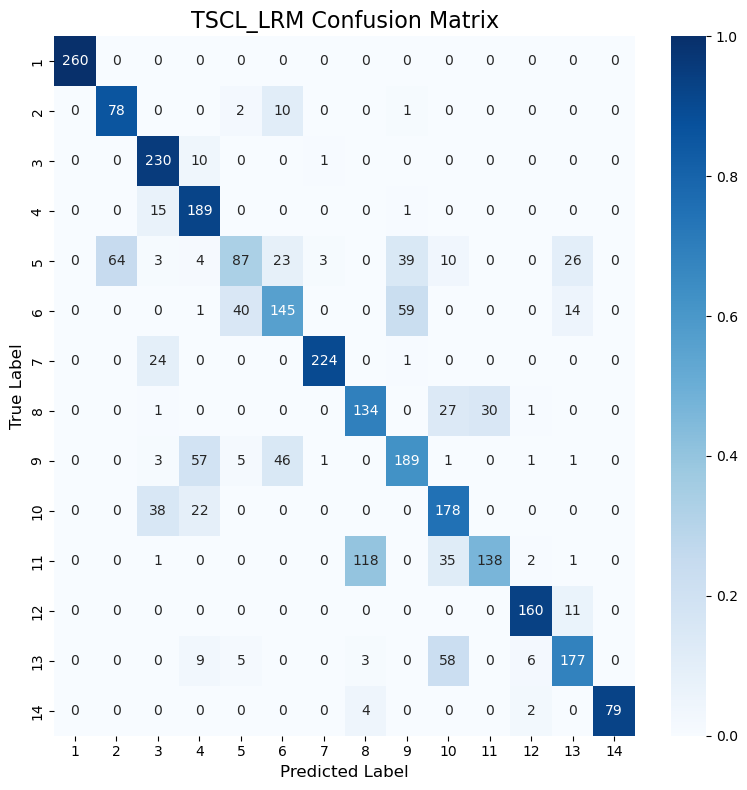

Classification Accuracy: 72.97%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


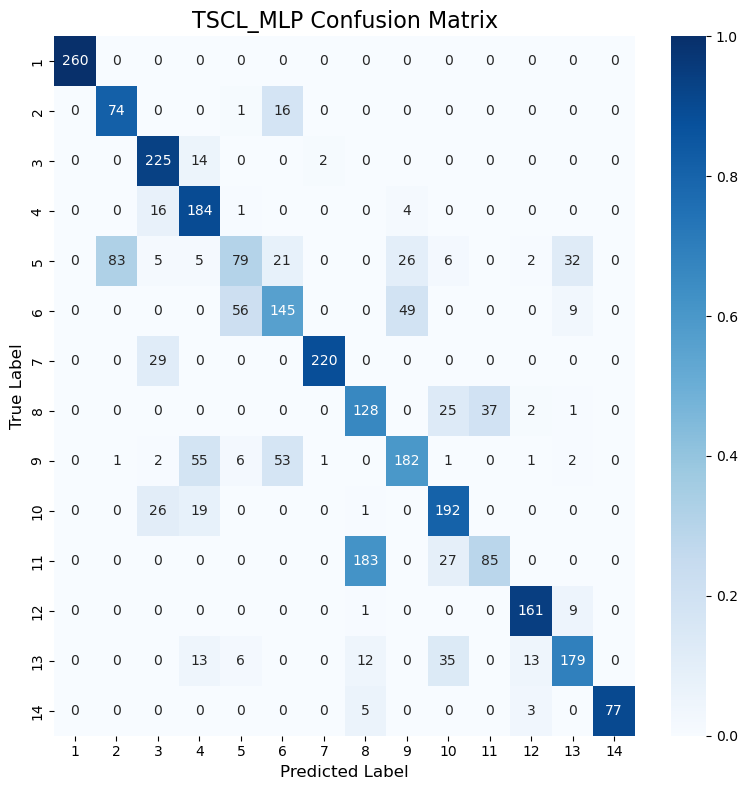

Classification Accuracy: 70.50%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


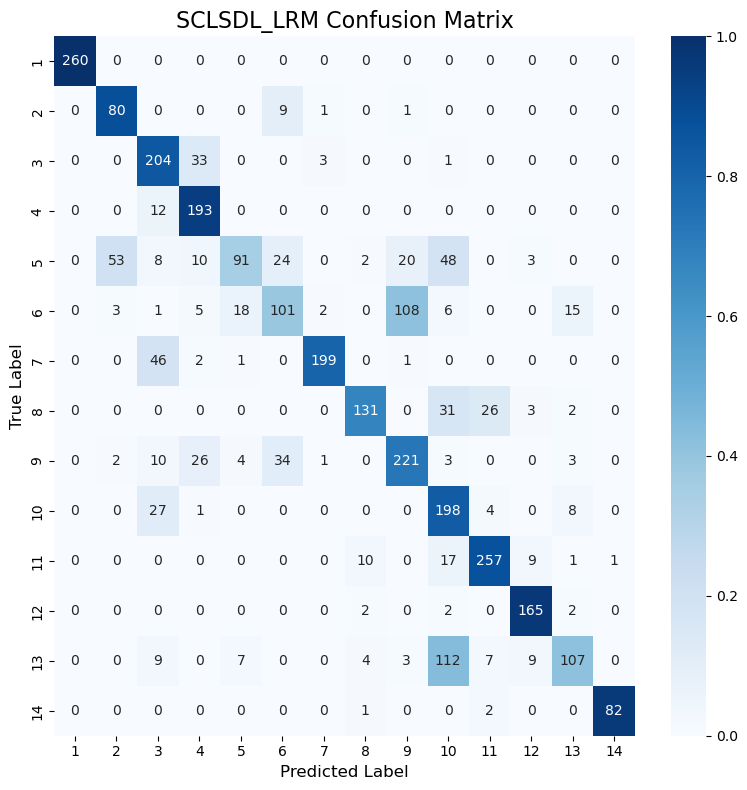

Classification Accuracy: 73.65%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


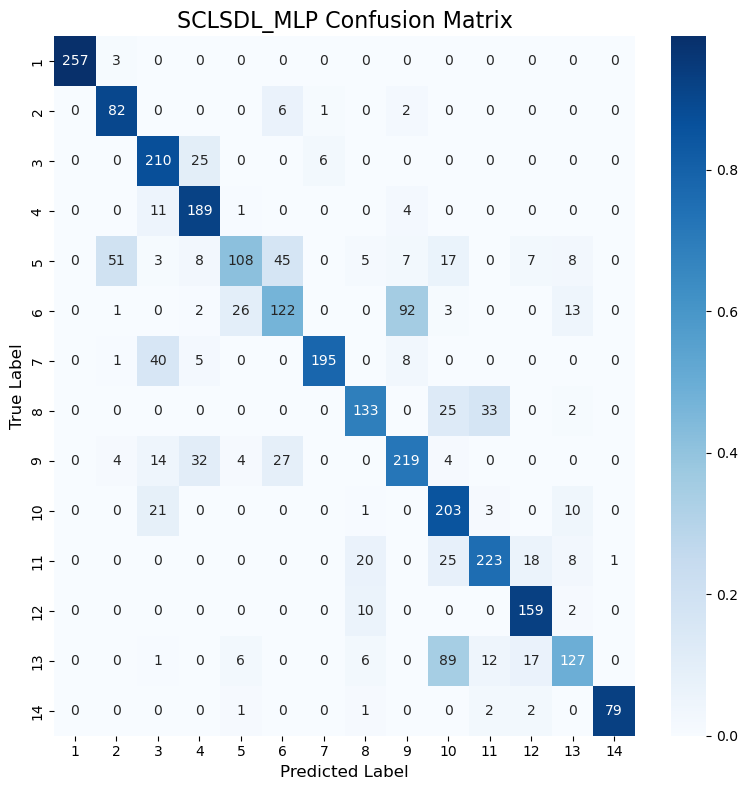

Classification Accuracy: 74.20%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          87.39
1    LRM (CAE)          59.94
2    MLP (CAE)          35.94
3     TSCL LRM          72.97
4     TSCL MLP          70.50
5  SCL_SDL LRM          73.65
6  SCL_SDL MLP          74.20

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          87.39
6  SCL_SDL MLP          74.20
5  SCL_SDL LRM          73.65
3     TSCL LRM          72.97
4     TSCL MLP          70.50
1    LRM (CAE)          59.94
2    MLP (CAE)          35.94
